# Biological Ground Truth data from Rebecca

In [1]:
# external dependencies
import os
import sys
import gc
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
import logging
from tqdm.auto import tqdm, trange

# scientific python
import matplotlib.pylab as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.patches as mpatches 
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.stats import describe as describe_stats
#from scipy.stats import mannwhitneyu
from scipy.special import logit
RAND_SEED = 28
np.random.seed(RAND_SEED)

# Scanpy modules
import scanpy as sc
import anndata

logger = logging.getLogger()
utils.matplotlib_settings()
utils.print_module_versions([sc, anndata])

import warnings
warnings.filterwarnings("ignore")

scanpy    : 1.8.1
anndata   : 0.7.6


## Load the data

In [2]:
dirname = f'/home/jupyter/ViziBead/data/Rebecca/'
# Load
adata_full = sc.read(os.path.join(dirname, 'rebecca_summer2020_foraleks_adata_cd138_groundtruthlabeled.h5ad'))
adata_full

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'person', 'age', 'batch', 'sorting_tag', 'disease_stage', 'sex', 'disease_stage_short', 'SAMPLE', 'sample_id', 'Type', 'Gender', 'Age at Dx', 'Diagnosis date', 'Race', 'Type.1', 'FISH 1', 'FISH 1 Date', 'FISH 2', 'FISH 2 Date', 'FISH 3', 'FISH 3 Date', 'FISH 4', 'FISH 4 Date', 'BM at Diagnosis', 'M Protein when sample was taken', 'Date of BM Aspirate used for single-cell RNA Seq', 'Infiltration of Used BM or Aspirate', 'BM Transplant', 'Transplant Date', 'Induction', 'XRT', 'Maintenance Tx', 'Relapse Date', 'Total # cells', 'CD138+', 'CD45+', 'CD45-', 'PMH', 'Family Hx', 'Smoking', 'Alcohol', 'Previous Chemo', 'n_genes', 'percent_mito', 'n_counts', 'possible_doublet', 'S_score', 'G2M_score', 'phase', 'prolif_idx', 'EMT_score', 'leiden', '__is_in_cluster__', 'ground_truth', 'ncells_persample', 'hemoglobin_score', 'person_group', 'sample_purity', 'person_oldnames', 'tx', 'HRD', 'driver event'
    var: 'gene_ids', 'n_cells', 'hig

## Remove cells with missing ground truth annotation

In [3]:
adata_full = adata_full[~adata_full.obs['ground_truth'].isna()]

* 'NBM': normal bone marrow
* 'MGUS': The earliest stage of myeloma is not cancer at all. Rather, this stage is a benign condition called monoclonal gammopathy of undetermined significance. Shortened as MGUS.
* 'SMM': Smoldering multiple myeloma (SMM) is asymptomatic; an intermediate stage of myeloma between MGUS and active myeloma.
* 'MM': multiple myeloma

# Counts ground_truth by person

In [4]:
infos = []
for index, grp_df in adata_full.obs.groupby('person'):    
    infos.append({'person':index, 
                 'malignant':(grp_df['ground_truth']=='malignant').sum(),
                 'healthy':(grp_df['ground_truth']=='healthy plasma').sum()})
pd.DataFrame(infos)

person  malignant  healthy
0    NBM-1          0      760
1    NBM-2          0      857
2    NBM-3          0       51
3    NBM-4          0      160
4    NBM-6          0      679
5    NBM-7          0     1569
6    NBM-8          0     1807
7   NBM-10          0     2606
8   NBM-11          0      840
9   MGUS-1          0      133
10  MGUS-2         35       81
11  MGUS-3        205      166
12  MGUS-4          0       62
13  MGUS-5          0       53
14  MGUS-6         67       15
15   SMM-1        439        0
16   SMM-2       1721      136
17   SMM-3        283       66
18   SMM-4        136        0
19   SMM-5         40        0
20   SMM-6       1140        0
21   SMM-7       2049        0
22   SMM-8        579      132
23   SMM-9       1106      147
24  SMM-10         39       28
25  SMM-11        106        0
26  SMM-12        284        0
27    MM-1       2887        0
28    MM-2       3414        0
29    MM-3        944        6
30    MM-4        581       10
31    MM-5       1463        0
32    MM-6        817       15
33    MM-7        100        0
34    MM-8        553        0

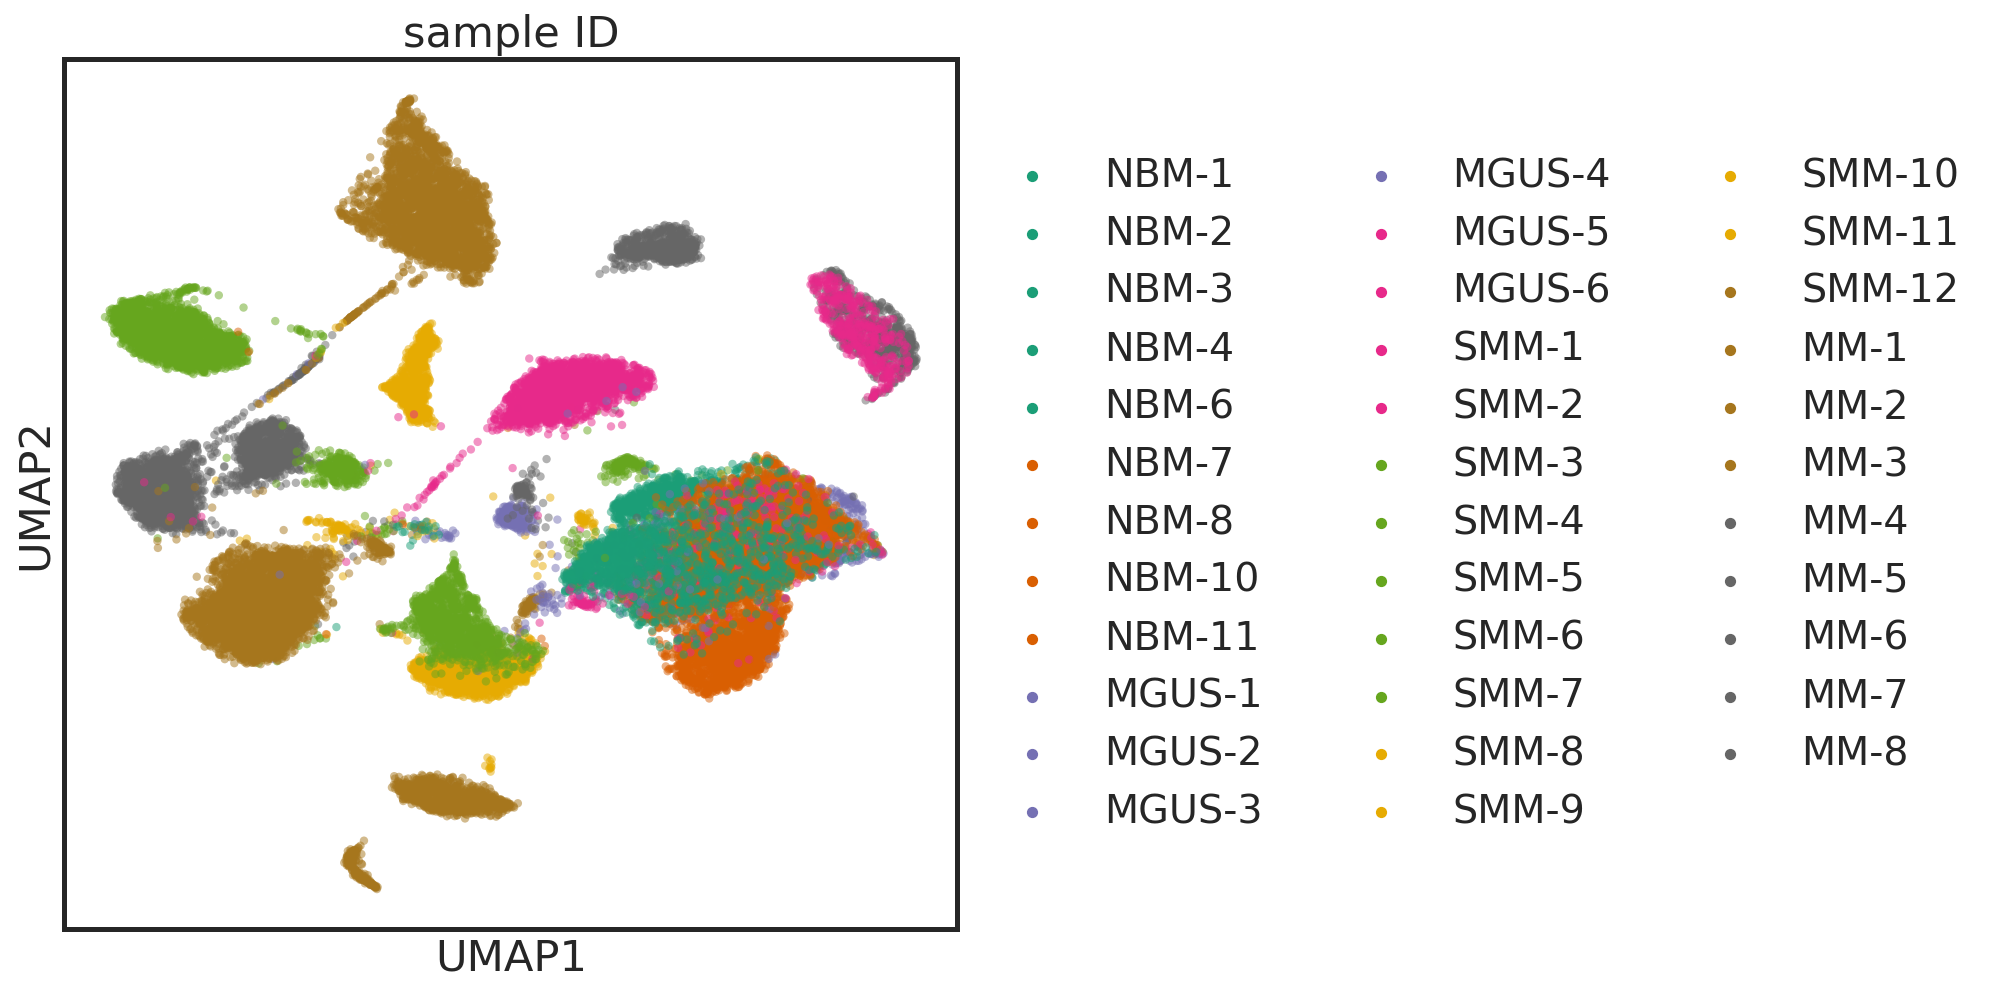

In [24]:
_, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(adata_full, color=['person'], s=70, alpha=0.5, title=f'sample ID', palette='Dark2', save="_patient.png", ax=ax)

# Function definitions

In [5]:
# Subset the data

def subset_and_preprocess(adata_full, nbm_samples, precursor_samples, mm_sample):
    
    adata = adata_full[adata_full.obs['person'].isin(nbm_samples + precursor_samples + mm_sample)]
    subset_title_str = f'all NBM, all precursor samples, {mm_sample}'
    adata.X = adata.raw.X.todense()

    #sc.pp.filter_cells(adata, min_genes=20)
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    #sc.pp.highly_variable_genes(adata)
    #adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    #sc.pl.umap(adata, color=['ground_truth', 'disease_stage', 'person'], s=70, alpha=0.5, title=subset_title_str)#,save=f'_{subset_title_str}.png')
    
    return adata

In [6]:
# HiDDEN functions

def standalone_logistic(X, y):
    
    clf = LogisticRegression(random_state=RAND_SEED, penalty='none').fit(X, y)
    predicted_label = clf.predict(X)
    predicted_prob = clf.predict_proba(X)
    return predicted_prob[:,1]

def PCA_logistic_kmeans(adata, num_pcs, case_cond):
    
    p_hat = standalone_logistic(adata.obsm['X_pca'][:, 0:num_pcs], adata.obs['status'].values)
    df_p_hat = pd.DataFrame()
    df_p_hat['p_hat'] = p_hat
    df_p_hat['status'] = adata.obs['status'].values
    adata.obs['p_hat'] = p_hat

    kmeans_case = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(p_hat)[(adata.obs['status']==case_cond).values])
    mean_p_hat_kmeans_label0 = np.mean(p_hat[(adata.obs['status']==case_cond).values][kmeans_case.labels_==0]) 
    mean_p_hat_kmeans_label1 = np.mean(p_hat[(adata.obs['status']==case_cond).values][kmeans_case.labels_==1])
    zero_lab_has_lower_mean = mean_p_hat_kmeans_label0 < mean_p_hat_kmeans_label1

    df_p_hat_clust_case = df_p_hat.copy()
    df_p_hat_clust_case['kmeans'] = 0
    df_p_hat_clust_case['kmeans'][(adata.obs['status']==case_cond).values] = [1 if x==int(zero_lab_has_lower_mean) else 0 for x in kmeans_case.labels_]
    
    return p_hat, df_p_hat_clust_case['kmeans']

def PCA_logistic_kmeans_precursorperson(adata, num_pcs):
    
    p_hat = standalone_logistic(adata.obsm['X_pca'][:, 0:num_pcs], adata.obs['status'].values)
    df_p_hat = pd.DataFrame()
    df_p_hat['p_hat'] = p_hat
    df_p_hat['status'] = adata.obs['status'].values
    df_p_hat['person'] = adata.obs['person'].values
    adata.obs['p_hat'] = p_hat
    df_p_hat_clust_precursorperson = df_p_hat.copy()
    df_p_hat_clust_precursorperson['kmeans'] = 0
    df_p_hat_clust_precursorperson['kmeans'][adata.obs['disease_stage'].isin(['MM']).values] = 1

    # kmeans clustering for each precursor sample individually
    precursor_samples_list = [k for k in np.unique(adata.obs['person']) if 'SMM' in k or 'MGUS' in k]
    for precursor_sample in precursor_samples_list:
        kmeans_precursorperson = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(p_hat)[(adata.obs['person']==precursor_sample).values])
        mean_p_hat_kmeans_label0 = np.mean(p_hat[(adata.obs['person']==precursor_sample).values][kmeans_precursorperson.labels_==0]) 
        mean_p_hat_kmeans_label1 = np.mean(p_hat[(adata.obs['person']==precursor_sample).values][kmeans_precursorperson.labels_==1])
        zero_lab_has_lower_mean = mean_p_hat_kmeans_label0 < mean_p_hat_kmeans_label1
        df_p_hat_clust_precursorperson['kmeans'][(adata.obs['person']==precursor_sample).values] = [1 if x==int(zero_lab_has_lower_mean) else 0 for x in kmeans_precursorperson.labels_]
    
    return p_hat, df_p_hat_clust_precursorperson['kmeans']

In [7]:
# Helper functions

CONSISTENCY_THRESH=0.7

def max_abs_lfc(x, majority_thresh=CONSISTENCY_THRESH):
    
    lfc_sign = 1 if (np.mean(x<0)<=(1-majority_thresh)) else -1 if (np.mean(x<0)>=majority_thresh) else np.nan
    return lfc_sign*x.abs().max()

# Run for all NBM, one Precursor, and all MM samples

## Choose optimal NUM_PCS

In [ ]:
# All NBM, One Precursor, All MM

NBM_samples = ['NBM-1', 'NBM-2', 'NBM-3',  'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11']
Precursor_samples = ['SMM-3']
MM_samples = ['MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8']

num_pcs_vec = []
num_DEs_vec = []
num_pcs_de_dict = {'num_pcs':num_pcs_vec, 'num_DEs': num_DEs_vec}
num_pcs_de_dict

for num_pcs in tqdm(np.arange(1, 100, 1)):
    
    NUM_PCS = num_pcs
    print(f"{num_pcs} PCs")
    adata = subset_and_preprocess(adata_full, NBM_samples, Precursor_samples, MM_samples)
    #adata = adata_full
    subset_title_str = f'All NBM, All Precursor, All MM'
    # Define healthy and disease original labels ('NMB' being 'healthy', and everything else being 'disease')
    adata.obs['status'] = adata.obs.disease_stage.apply(lambda x: 0 if x=='NBM' else 1)
    adata.obs['status'] = adata.obs['status'].astype('int').values
    p_hat, new_labels = PCA_logistic_kmeans_precursorperson(adata, NUM_PCS)
    adata.obs['new_labels'] = new_labels.values

    # Find DE genes per patient and take a union across patients
    # Use this as the heuristic decision criterion for NUM_PCS: choose the NUM_PCS that maximizes the number of DE genes
    # Maximum log-fold change across patients using original labels

    lfc_new_p_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)
    lfc_new_l_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)
    
    # max abs(log-fold change) over samples for the selected genes
    lfc_ground_truth_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')
    lfc_new_labels_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')

    for precursor_sample in Precursor_samples:

        adata_de = adata[adata.obs['person'].isin([precursor_sample])]
        if (min(np.sum(adata_de.obs['new_labels']==1), np.sum(adata_de.obs['new_labels']==0)) < 10):
            print(f"{num_pcs} PCs, Sample {precursor_sample} has mostly homogenous labels and DE analysis will be skipped for it")
        else:
            adata_de.obs['new_labels'] = adata_de.obs['new_labels'].astype('category')
            sc.tl.rank_genes_groups(adata_de, 'new_labels', method='t-test')
            #sc.pl.rank_genes_groups(adata_de, n_genes=25, sharey=False)

            result = adata_de.uns['rank_genes_groups']
            groups = result['names'].dtype.names
            result_df = pd.DataFrame(
                {group + '_' + key[:1]: result[key][group]
                for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

            lfc_malignant_df = result_df[['1_n', '1_p', '1_l']]
            lfc_healthy_df = result_df[['0_n', '0_p', '0_l']]
            lfc_healthy_df = lfc_healthy_df.set_index('0_n')
            lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
            lfc_malignant_df = lfc_malignant_df.set_index('1_n')
            lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
            lfc_malignant_df.columns = [f'1_p_{precursor_sample}', f'1_l_{precursor_sample}']

            lfc_new_p_df = lfc_new_p_df.join(lfc_malignant_df[f'1_p_{precursor_sample}'])
            lfc_new_l_df = lfc_new_l_df.join(lfc_malignant_df[f'1_l_{precursor_sample}'])

            adata_plot = adata[adata.obs['person'].isin([precursor_sample])]
            #df_X = pd.DataFrame(adata_plot.layers['lognorm'].todense()) # log-normalized expression
            df_X = pd.DataFrame(adata_plot.layers['counts'].todense()) # raw expression
            df_X = df_X.div(df_X.sum(axis=1), axis=0) # TODO try both ways with normalizing and without
            df_X.columns = adata_plot.var.index
            eps = 0#1e-15

            lfc_ground_truth = np.log2((np.mean(df_X.values[adata_plot.obs['ground_truth']=='malignant'], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['ground_truth']!='malignant'], axis=0)+eps))
            lfc_new_labels = np.log2((np.mean(df_X.values[adata_plot.obs['new_labels']==1], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['new_labels']!=1], axis=0)+eps))
            lfc_ground_truth_df[f"{precursor_sample}"] = lfc_ground_truth
            lfc_new_labels_df[f"{precursor_sample}"] = lfc_new_labels

    max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    
    max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    # Number of DE genes with new labels
    lfc_new_p_df = lfc_new_p_df
    DE_new_bool = np.logical_and(max_abs_lfc_new_labels.abs()>1.5, lfc_new_p_df.min(axis=1)<0.05)
    DE_new = lfc_new_p_df.index.values[DE_new_bool]

    num_pcs_vec.append(NUM_PCS)
    num_DEs_vec.append(len(DE_new))
    
    del adata
    del adata_de
    del adata_plot
    gc.collect()


  0%|          | 0/99 [00:00<?, ?it/s]

1 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


2 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


3 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


4 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


5 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


6 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


7 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


8 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


9 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


10 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


11 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


12 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


13 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


14 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


15 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


16 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


17 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


18 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


19 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


20 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


21 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


22 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


23 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


24 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


25 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


26 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


27 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


28 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


29 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


30 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


31 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


32 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


33 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


34 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


35 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


36 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


37 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


38 PCs


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


39 PCs


Trying to set attribute `.obs` of view, copying.


In [11]:
print(num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])])
print(num_pcs_de_dict['num_DEs'][np.argmax(num_pcs_de_dict['num_DEs'])])

48
1447


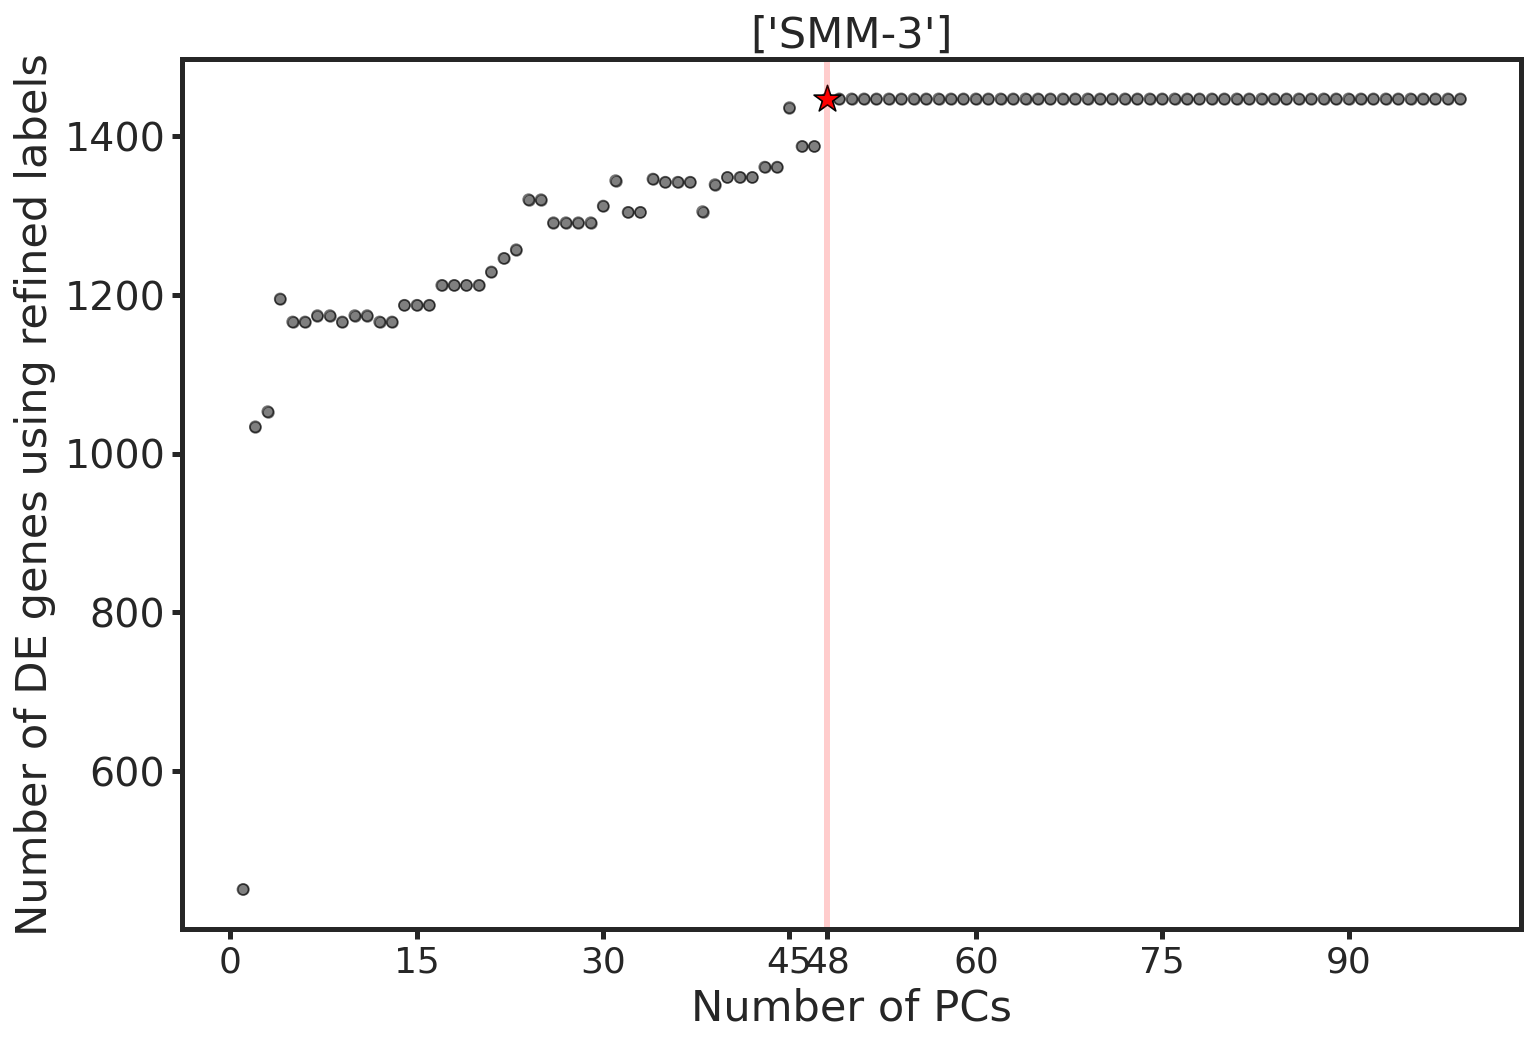

In [12]:
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='k', alpha=0.5)
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='none', alpha=0.5, edgecolors='k')
plt.axvline(x = num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])], color = 'r', alpha=0.2)
plt.scatter(num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])], 
            num_pcs_de_dict['num_DEs'][np.argmax(num_pcs_de_dict['num_DEs'])], 
            s=200, c='r', marker='*', edgecolors='k')
plt.xticks(np.append(np.arange(0, 101, 15), num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])]), fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('Number of DE genes using refined labels')
plt.title(f'{Precursor_samples}')
plt.savefig(f'figures/ChoosingoptimalNUM_PCS_AllNBM_OnePrecursor{Precursor_samples}_AllMM.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/ChoosingoptimalNUM_PCS_AllNBM_OnePrecursor{Precursor_samples}_AllMM.svg', 
            transparent=True, bbox_inches='tight')
plt.show()

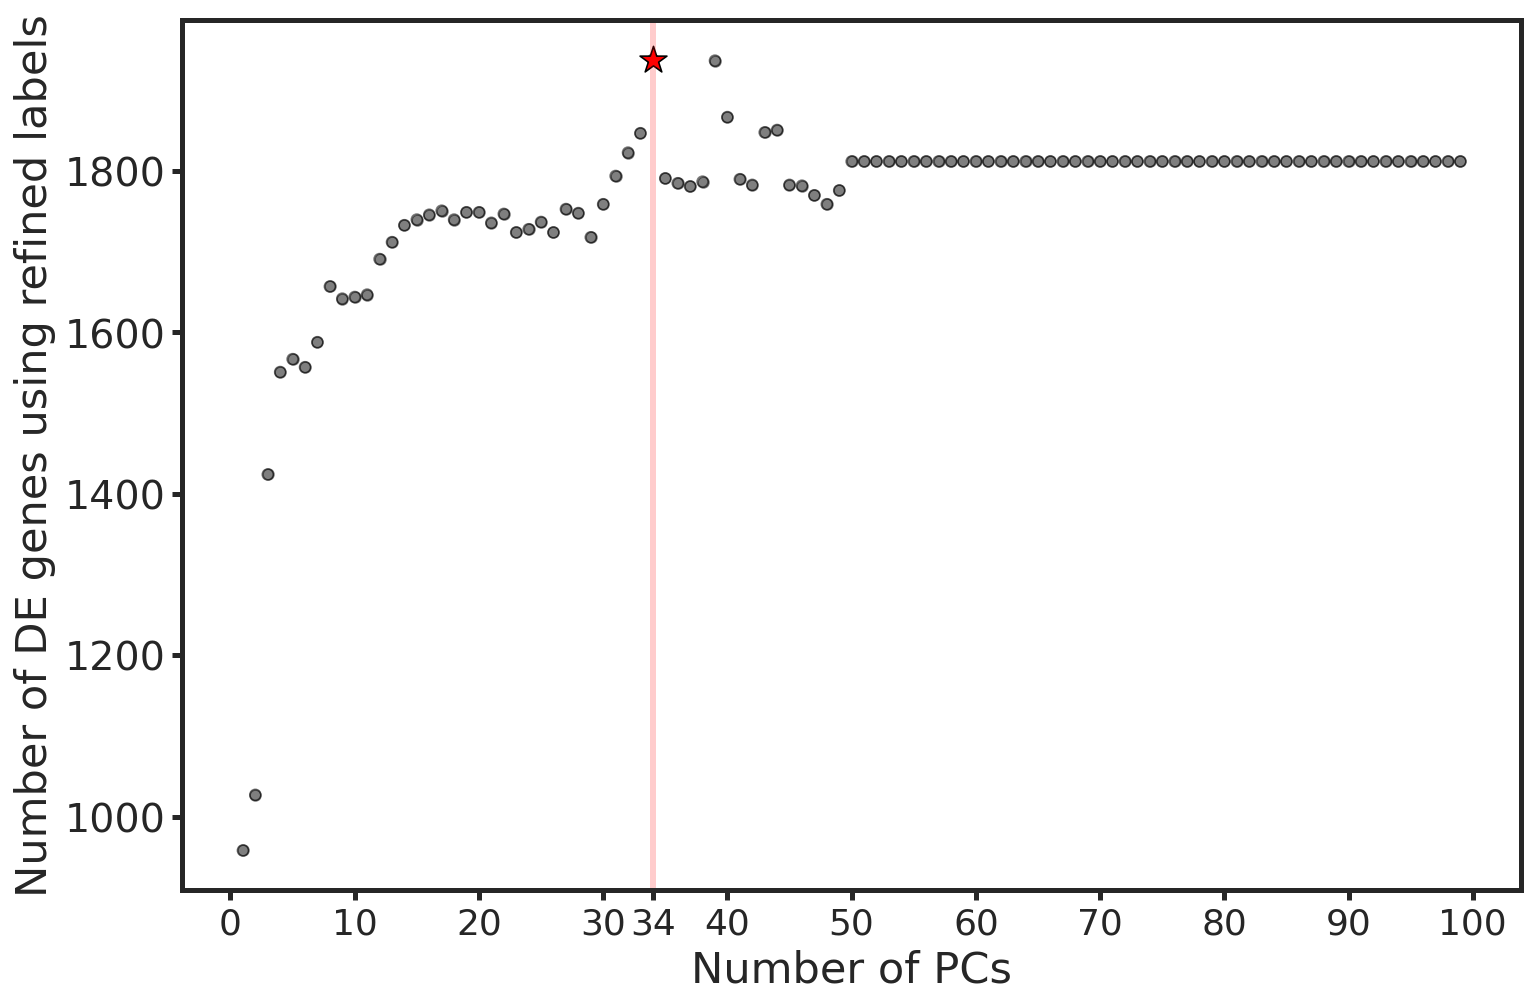

In [1069]:
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='k', alpha=0.5)
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='none', alpha=0.5, edgecolors='k')
#plt.axvline(x = 34, color = 'r', alpha=0.2)
#plt.scatter(34, 1938, s=200, c='r', marker='*', edgecolors='k')
plt.xticks(np.append(np.arange(0, 101, 10), 34), fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('Number of DE genes using refined labels')
#plt.title('Choosing the optimal NUM_PCS')
plt.savefig('figures/ChoosingoptimalNUM_PCS_AllNBM_MixedonlyPrecursor_AllMM.png', 
            dpi=300, transparent=False, bbox_inches='tight')
plt.savefig('figures/ChoosingoptimalNUM_PCS_AllNBM_MixedonlyPrecursor_AllMM.svg', 
            transparent=False, bbox_inches='tight')
plt.show()

## Run with a chosen value for NUM_PCS

In [83]:
optimal_NUM_PCS_dict = {'MGUS-1':4,
                        'MGUS-2':5,
                        'MGUS-3':50,
                        'MGUS-4':20,
                        'MGUS-5':4,
                        'MGUS-6':21,
                        'SMM-2':41,
                        'SMM-3':48,
                        'SMM-8':2,
                        'SMM-9':41,
                        'SMM-10':43}

In [84]:
# All NBM, One Precursor, All MM

NBM_samples = ['NBM-1', 'NBM-2', 'NBM-3',  'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11']
Precursor_samples = ['SMM-3']
MM_samples = ['MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8']

NUM_PCS = optimal_NUM_PCS_dict[Precursor_samples[0]] # num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])]

adata = subset_and_preprocess(adata_full, NBM_samples, Precursor_samples, MM_samples)
#adata = adata_full
subset_title_str = f'All NBM, {Precursor_samples}, All MM'
# Define healthy and disease original labels ('NMB' being 'healthy', and everything else being 'disease')
adata.obs['status'] = adata.obs.disease_stage.apply(lambda x: 0 if x=='NBM' else 1)
adata.obs['status'] = adata.obs['status'].astype('int').values
p_hat, new_labels = PCA_logistic_kmeans_precursorperson(adata, NUM_PCS)
adata.obs['new_labels'] = new_labels.values

Trying to set attribute `.obs` of view, copying.


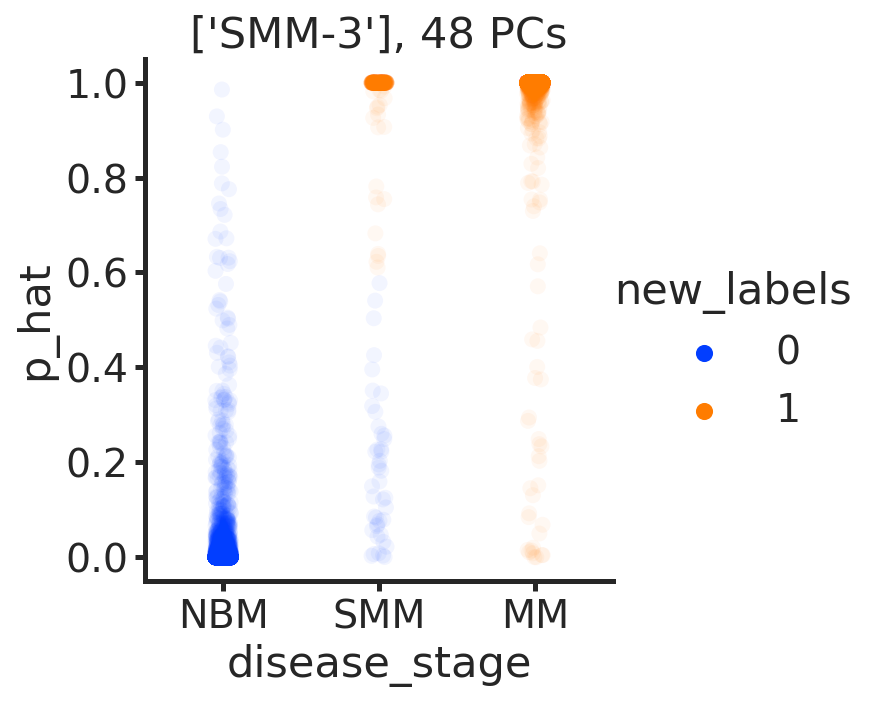

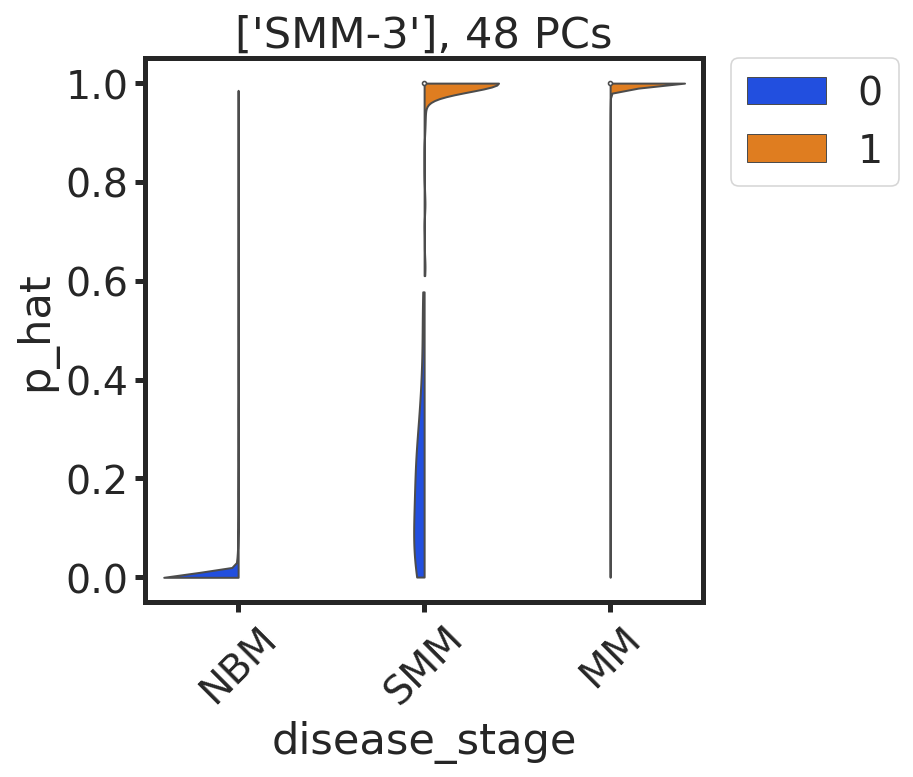

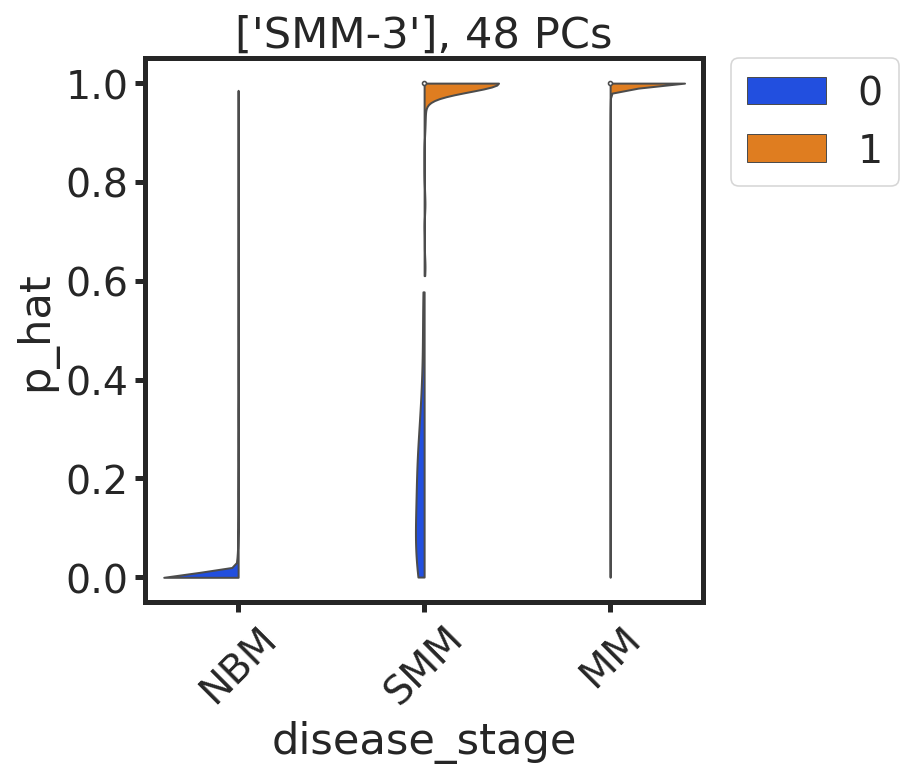

In [85]:
g = sns.catplot(x='disease_stage', y='p_hat', kind='strip', hue='new_labels', data=adata.obs, jitter=0.05, s=8, alpha=0.05)
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5))
g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='count')#, scale_hue=False) 
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5))
g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='area')#, scale_hue=False) 
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

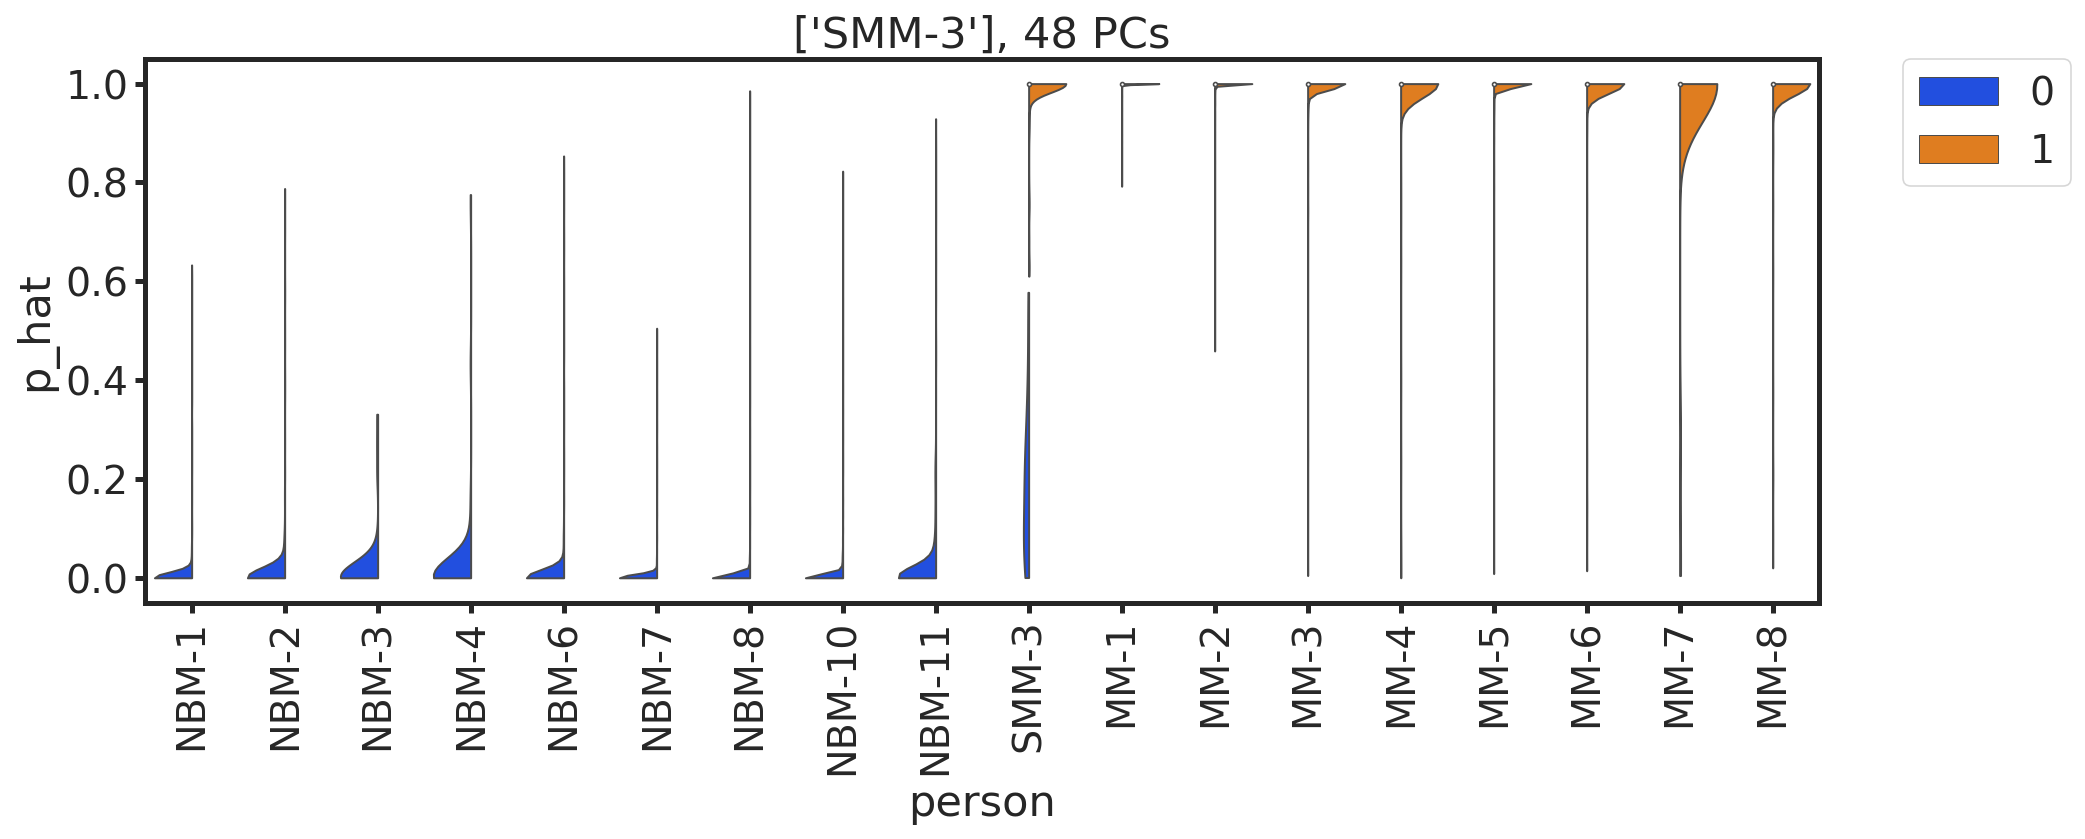

In [99]:
#g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='area')#, scale_hue=False) 

plt.figure(figsize=(15, 5))
g = sns.violinplot(data=adata.obs, x='person', y='p_hat', hue='new_labels', linewidth=1, split=True, cut=0, jitter=0.05, scale='count')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

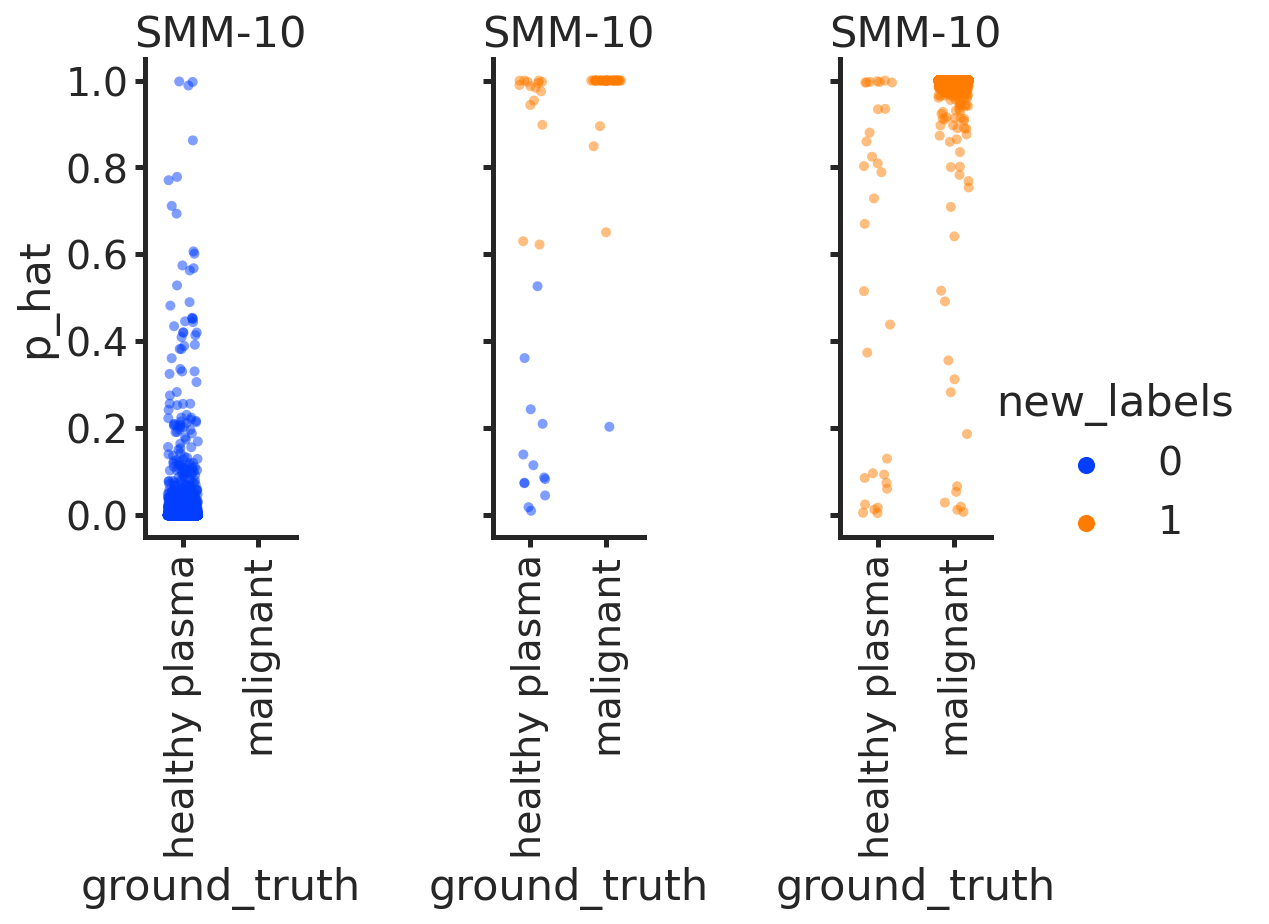

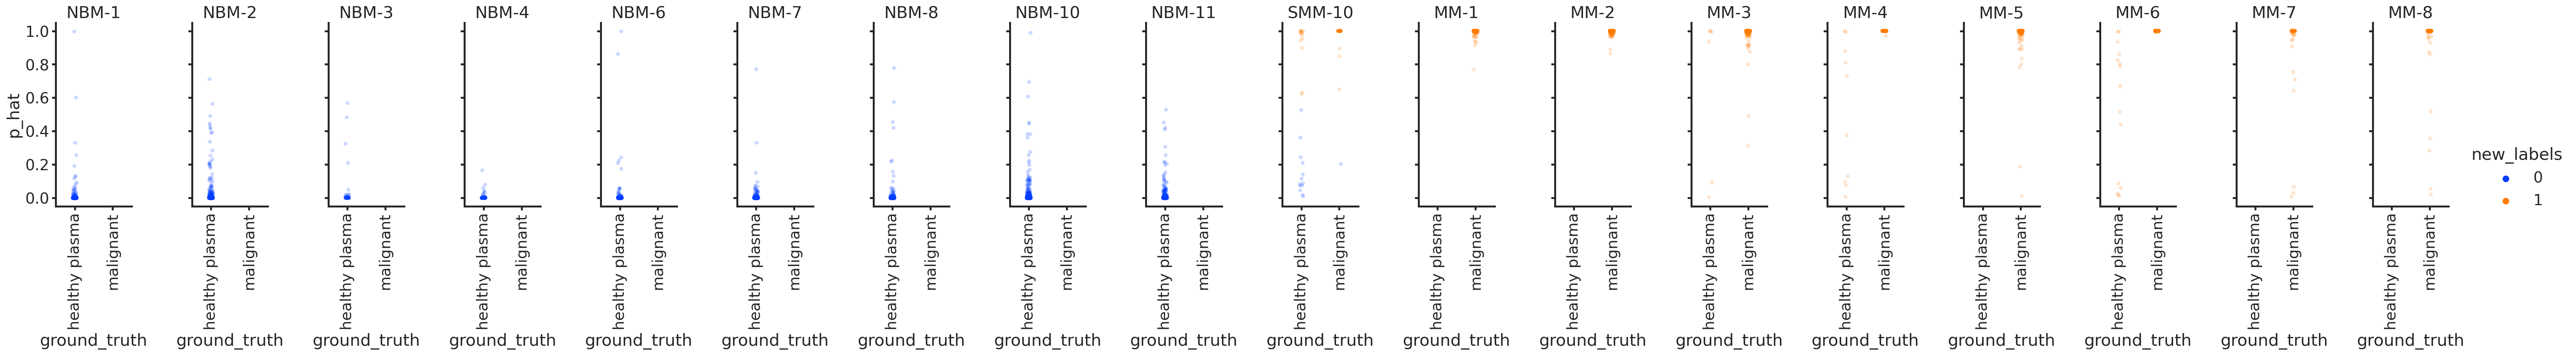

In [11]:
g = sns.catplot(x='ground_truth', y='p_hat', col='disease_stage', kind='strip', hue='new_labels', data=adata.obs, jitter=0.2, s=5, alpha=0.5, height=5, aspect=0.5)
g.set_xticklabels(rotation=90)
g.set_titles(Precursor_samples[0])  # use this argument literally
plt.savefig(f'figures/p_hat_predictions_disease_stage_{NUM_PCS}PCs_{Precursor_samples}.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_{NUM_PCS}PCs_{Precursor_samples}.svg', 
            transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_{NUM_PCS}PCs_{Precursor_samples}.pdf', 
            transparent=True, bbox_inches='tight')

g = sns.catplot(x='ground_truth', y='p_hat', col='person', kind='strip', hue='new_labels', data=adata.obs, jitter=0.05, s=5, alpha=0.2, height=5, aspect=0.5)
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
plt.savefig(f'figures/p_hat_predictions_person_{NUM_PCS}PCs_{Precursor_samples}.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_{NUM_PCS}PCs_{Precursor_samples}.svg', 
            transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_{NUM_PCS}PCs_{Precursor_samples}.pdf', 
            transparent=True, bbox_inches='tight')

### DE genes

In [34]:
adata_de = adata[adata.obs['person'].isin(Precursor_samples)]

lfc_ground_p_df = pd.DataFrame({'malignant_n':[]}).set_index('malignant_n').reindex(index=adata.var.index.values)
lfc_new_p_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)

# max abs(log-fold change) over samples for the selected genes
lfc_ground_truth_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')
lfc_new_labels_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')

if (len(np.unique(adata_de.obs['ground_truth']))==2):
    adata_de.obs['ground_truth'] = adata_de.obs['ground_truth'].astype('category')
    sc.tl.rank_genes_groups(adata_de, 'ground_truth', method='t-test')
    result = adata_de.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result_df = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    lfc_malignant_df = result_df[['malignant_n', 'malignant_p', 'malignant_l']]
    lfc_healthy_df = result_df[['healthy plasma_n', 'healthy plasma_p', 'healthy plasma_l']]
    lfc_healthy_df = lfc_healthy_df.set_index('healthy plasma_n')
    lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
    lfc_malignant_df = lfc_malignant_df.set_index('malignant_n')
    lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
    lfc_malignant_df.columns = [f'malignant_p_{Precursor_samples[0]}', f'malignant_l_{Precursor_samples[0]}']
    lfc_ground_p_df = lfc_ground_p_df.join(lfc_malignant_df[f'malignant_p_{Precursor_samples[0]}'])
else:
    print(f'{Precursor_samples} has only one ground_truth class (i.e. is not mixed according to the subclustering annotation.)')


adata_de.obs['new_labels'] = adata_de.obs['new_labels'].astype('category')
sc.tl.rank_genes_groups(adata_de, 'new_labels', method='t-test')
result = adata_de.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

lfc_malignant_df = result_df[['1_n', '1_p', '1_l']]
lfc_healthy_df = result_df[['0_n', '0_p', '0_l']]
lfc_healthy_df = lfc_healthy_df.set_index('0_n')
lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
lfc_malignant_df = lfc_malignant_df.set_index('1_n')
lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
lfc_malignant_df.columns = [f'1_p_{Precursor_samples}', f'1_l_{Precursor_samples}']
lfc_new_p_df = lfc_new_p_df.join(lfc_malignant_df[f'1_p_{Precursor_samples}'])

adata_plot = adata[adata.obs['person'].isin(Precursor_samples)]
#df_X = pd.DataFrame(adata_plot.layers['lognorm'].todense()) # log-normalized expression
df_X = pd.DataFrame(adata_plot.layers['counts'].todense()) # raw expression
df_X = df_X.div(df_X.sum(axis=1), axis=0) # TODO try both ways with normalizing and without
df_X.columns = adata_plot.var.index
eps = 0#1e-15

lfc_ground_truth = np.log2((np.mean(df_X.values[adata_plot.obs['ground_truth']=='malignant'], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['ground_truth']!='malignant'], axis=0)+eps))
lfc_ground_truth_df[f"{Precursor_samples}"] = lfc_ground_truth
max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)

lfc_new_labels = np.log2((np.mean(df_X.values[adata_plot.obs['new_labels']==1], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['new_labels']!=1], axis=0)+eps))
lfc_new_labels_df[f"{Precursor_samples}"] = lfc_new_labels
max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)

# Number of DE genes with ground_truth labels
DE_ground_bool = np.logical_and(max_abs_lfc_ground_truth.abs()>1.5, lfc_ground_p_df.min(axis=1)<0.05)
DE_ground = lfc_ground_p_df.index.values[DE_ground_bool]

# Number of DE genes with new labels
DE_new_bool = np.logical_and(max_abs_lfc_new_labels.abs()>1.5, lfc_new_p_df.min(axis=1)<0.05)
DE_new = lfc_new_p_df.index.values[DE_new_bool]

print(f"{Precursor_samples}, {NUM_PCS}")
print(f"num DE_new {len(DE_new)}")
print(f"num DE_ground {len(DE_ground)}")
print(f"intersection {len(np.intersect1d(DE_ground, DE_new))}")
print(f"new_labels unique {len(np.setdiff1d(DE_new, DE_ground))}")
print(f"ground_truth unique {len(np.setdiff1d(DE_ground, DE_new))}")

Trying to set attribute `.obs` of view, copying.


['SMM-3'], 60
num DE_new 1447
num DE_ground 945
intersection 805
new_labels unique 642
ground_truth unique 140


In [35]:
p_ground_df_Sample = lfc_ground_p_df
max_abs_lfc_ground_df_Sample = pd.DataFrame(max_abs_lfc_ground_truth, columns=[f'max_abs_lfc_{Precursor_samples[0]}'])
DE_ground_Sample = DE_ground
p_new_df_Sample = lfc_new_p_df
max_abs_lfc_new_df_Sample = pd.DataFrame(max_abs_lfc_new_labels, columns=[f'max_abs_lfc_{Precursor_samples[0]}'])
DE_new_Sample = DE_new
new_labels_df_Sample = pd.DataFrame(np.transpose([adata_de.obs.index, adata_de.obs['new_labels'], adata_de.obs['p_hat']]), 
                                    columns=["cellnames", "new_labels", "p_hat"])

In [ ]:
# save
p_ground_df_Sample.to_csv(f'figures/p_ground_df_{Precursor_samples[0]}.csv')
max_abs_lfc_ground_df_Sample.to_csv(f'figures/max_abs_lfc_ground_df_{Precursor_samples[0]}.csv')
p_new_df_Sample.to_csv(f'figures/p_new_df_{Precursor_samples[0]}.csv')
max_abs_lfc_new_df_Sample.to_csv(f'figures/max_abs_lfc_new_df_{Precursor_samples[0]}.csv')
new_labels_df_Sample.to_csv(f'figures/new_labels_df_{Precursor_samples[0]}.csv')

pd.DataFrame(DE_new_Sample, columns=[f'DE_new_{Precursor_samples[0]}']).to_csv(f'figures/DE_new_{Precursor_samples[0]}.csv')
pd.DataFrame(DE_ground_Sample, columns=[f'DE_ground_{Precursor_samples[0]}']).to_csv(f'figures/DE_ground_{Precursor_samples[0]}.csv')

In [36]:
# just for the Supp Figure for SMM-3
new_labels_df_Sample.to_csv(f'figures/new_labels_df_{Precursor_samples[0]}_{NUM_PCS}.csv')

In [14]:
# DE_new_MGUS1 ['RGS1', 'PIGF', 'MIR4435-2HG', 'CNPPD1', 'BTLA', 'EIF2A', 'ZNF622', 'PPP1R11', 'HLA-DMA', 'TSPAN13', 'CTSC', 'CCDC59', 'STARD5', 'SCNN1B', 'HSPBP1']
# DE_new_MGUS2 ['TPM3', 'LINC00152', 'NEB', 'LSAMP', 'ATP6V1G1', 'MYEOV', 'CCND1', 'IGHG4', 'IGHGP', 'IGHG1', 'JSRP1', 'IGLC2']
# DE_new_MGUS4 ['GYPC', 'NEU1', 'MARCKS', 'STRAP', 'NDUFAB1']
# DE_new_MGUS5 ['SSU72', 'SNRPE', 'RHOB', 'MOB1A', 'GORASP2', 'GNL3', 'CDV3', 'FNDC3B', 'TMEM156', 'SEC31A', 'UBE2B', 'EGR1', 'MANEA', 'EZR',
#       'CYCS', 'SRI', 'SHFM1', 'EIF1AX', 'PQBP1', 'ENY2', 'NDUFB9', 'VPS28', 'FNBP1', 'DPP7', 'NUCB2', 'CD59', 'COX8A', 'SRSF8',
#       'FDX1', 'EIF3A', 'CD27', 'SAP18', 'POMP', 'MRPS31', 'COMMD6', 'DNAJC3', 'KIAA0125', 'KLF13', 'IL16', 'RBBP6', 'FUS', 'SLC38A10', 'ANKRD12', 'RPN2', 'GMFG', 'BRSK1']

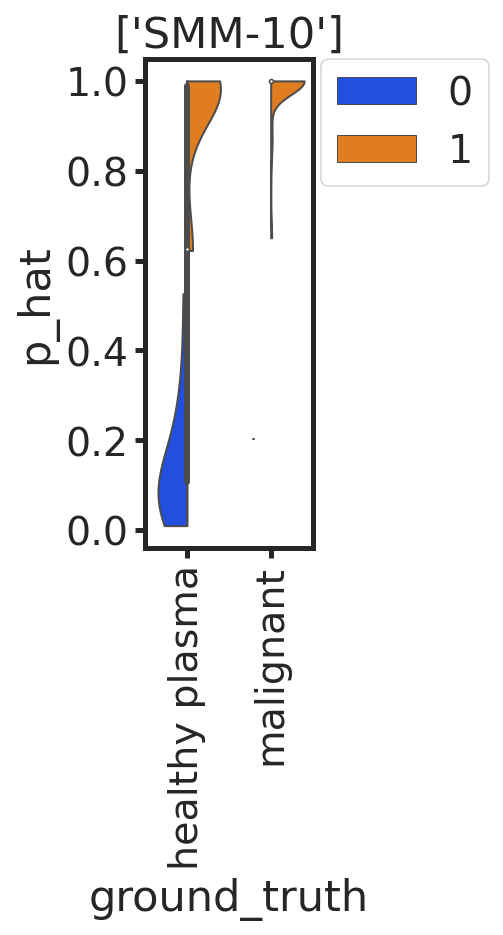

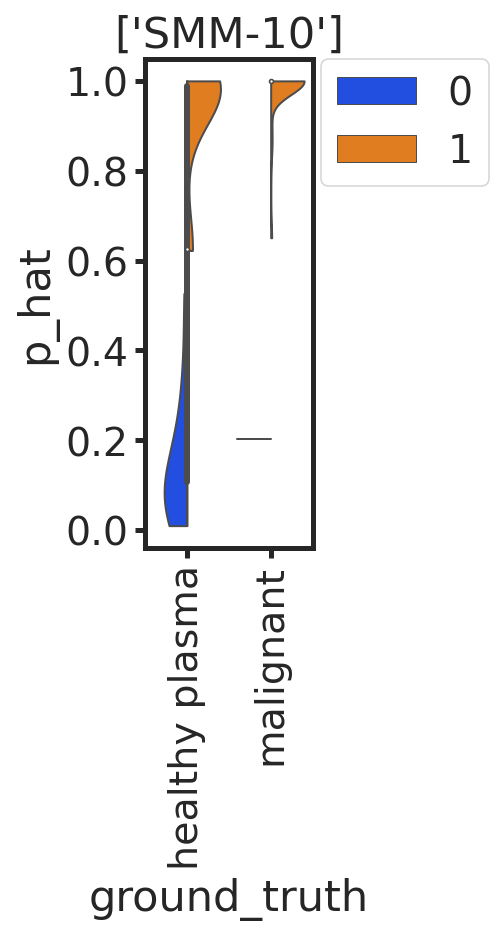

In [14]:
Mixed_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']

if Precursor_samples[0] in Mixed_samples:
    plt.figure(figsize=(1.5, 4.5))
    g = sns.violinplot(x='ground_truth', y='p_hat', hue='new_labels', data=adata_de.obs, split=True, cut=0, linewidth=1, scale='count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(f"{np.unique(adata_de.obs['person'])}") 
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
    
    plt.figure(figsize=(1.5, 4.5))
    g = sns.violinplot(x='ground_truth', y='p_hat', hue='new_labels', data=adata_de.obs, split=True, cut=0, linewidth=1, scale='area')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(f"{np.unique(adata_de.obs['person'])}") 
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
else:
    plt.figure(figsize=(1, 4.5))
    g = sns.stripplot(x="person", y="p_hat", hue="new_labels", data=adata_de.obs, jitter=0.15, s=5, alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(f"{np.unique(adata_de.obs['ground_truth'])}") 
    plt.savefig(f'figures/p_hat_predictions_onestage_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')

    plt.figure(figsize=(1, 4.5))
    g = sns.violinplot(data=adata_de.obs, x='person', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='count')#, scale_hue=False) 
    plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
    
    plt.figure(figsize=(1, 4.5))
    g = sns.violinplot(data=adata_de.obs, x='person', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='area')#, scale_hue=False) 
    plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/p_hat_predictions_onestage_violin_scalearea_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')

In [37]:
del adata
del adata_de
del adata_plot
gc.collect()

32818

# Figure 3b AUROC

In [23]:
Mixed_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']

adata = adata_full[adata_full.obs['person'].isin(Mixed_samples)]
adata.obs['p_hat'] = 0

for i, mixed_sample in enumerate(Mixed_samples):
    
    new_labels_df_Sample = pd.read_csv(f'figures/new_labels_df_{Mixed_samples[i]}.csv', index_col=0)
    Sample_mask = adata.obs.index.isin(new_labels_df_Sample['cellnames'])
    adata.obs['p_hat'][Sample_mask] = new_labels_df_Sample['p_hat']
    adata.obs['p_hat'][Sample_mask] = new_labels_df_Sample['p_hat'].values

Trying to set attribute `.obs` of view, copying.


In [24]:
adata.obs['p_hat'] = adata.obs['p_hat'].astype('float')
adata.write_h5ad('figures/adataMixedPrecursorsPhatPersample.h5ad')

MGUS
SMM


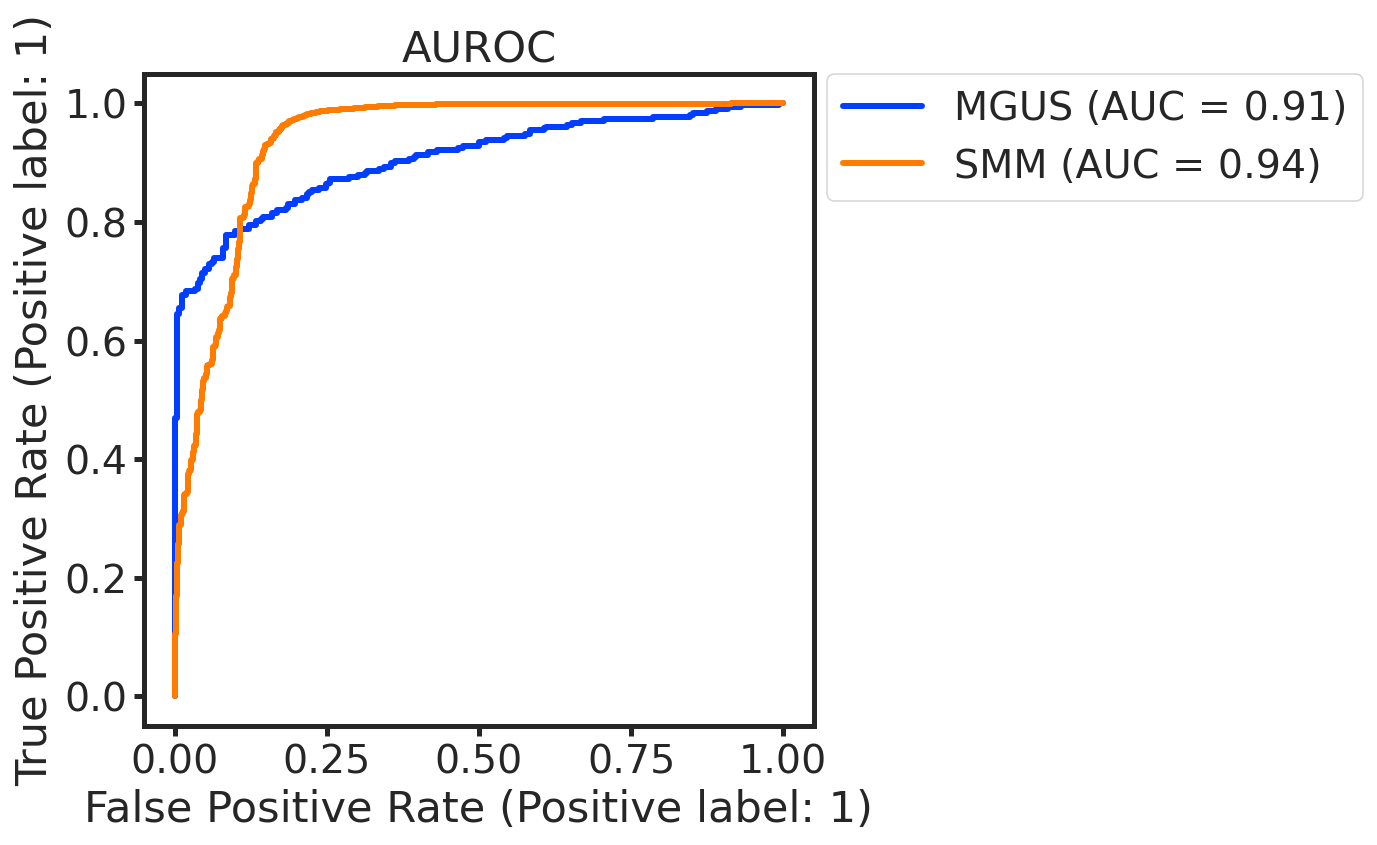

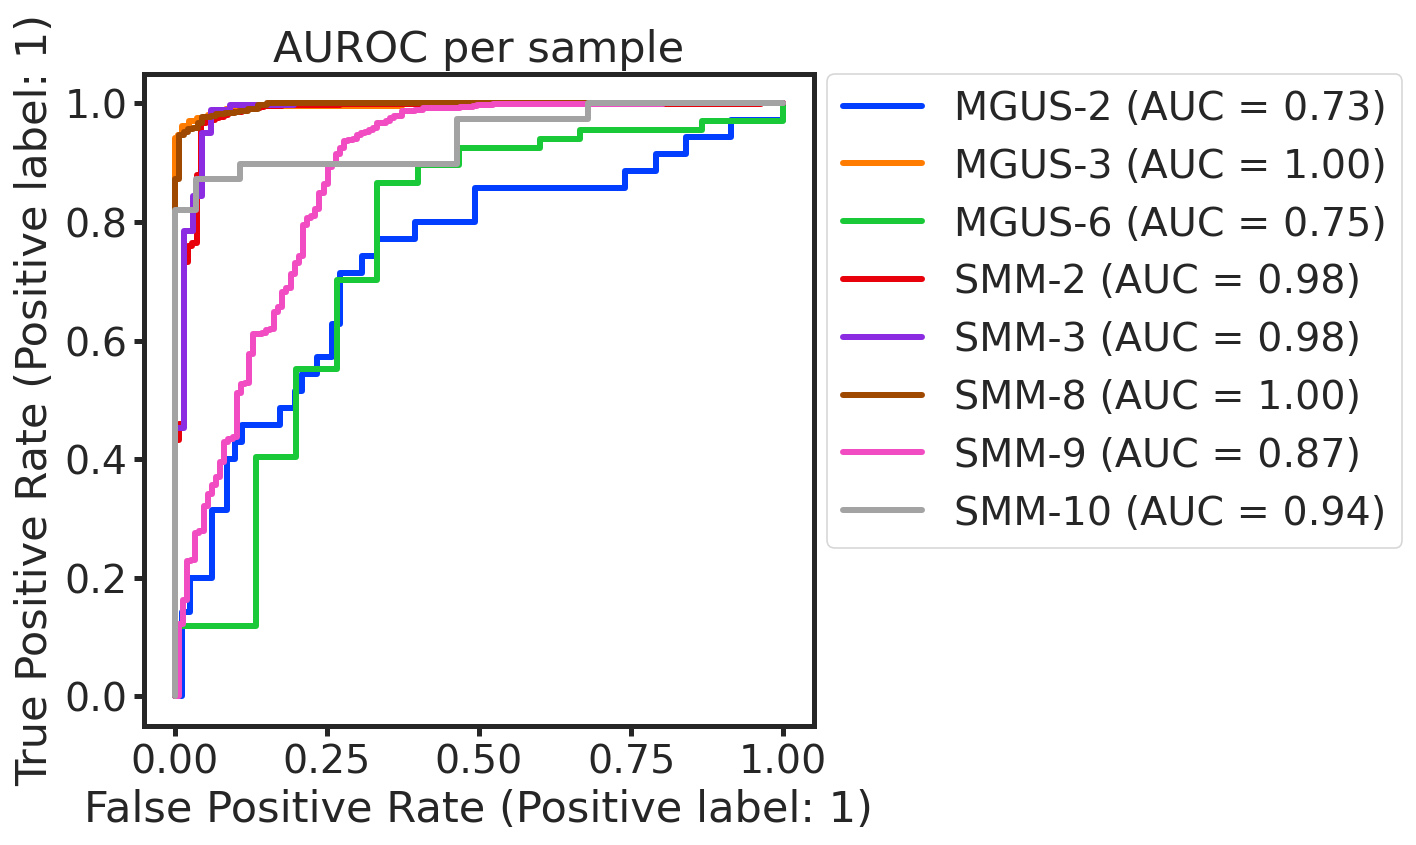

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
groupedby_diseasestage = adata.obs[adata.obs['person'].isin(Mixed_samples)].groupby(['disease_stage'])
for stage, grp_df in groupedby_diseasestage:
    print(stage)
    y_pred = grp_df['p_hat'].values
    y_true = grp_df['ground_truth'] == "malignant"
    try:
        sklearn.metrics.RocCurveDisplay.from_predictions(y_true, y_pred, name=f'{stage}', ax=ax)
    except ValueError:
        print(f'Error {stage}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"AUROC") 
plt.savefig(f'figures/AUROC_Combined_{Mixed_samples}.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_Combined_{Mixed_samples}.svg', 
            transparent=True, bbox_inches='tight')

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
groupedby_person = adata.obs[adata.obs['person'].isin(Mixed_samples)].groupby(['person'])
for person, grp_df in groupedby_person:
    y_pred = grp_df['p_hat'].values
    y_true = grp_df['ground_truth'] == "malignant"
    try:
        info = {'person':person, 'auroc':sklearn.metrics.roc_auc_score(y_true, y_pred)}
        sklearn.metrics.RocCurveDisplay.from_predictions(y_true, y_pred, name=f'{person}', ax=ax)
    except ValueError:
        print(f'{person}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"AUROC per sample") 
plt.savefig(f'figures/AUROC_persample_Combined_{Mixed_samples}.png', 
            dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'figures/AUROC_persample_Combined_{Mixed_samples}.svg', 
            transparent=True, bbox_inches='tight')


# Figure 3c Sample purity (proportion neoplastic) estimates

In [13]:
# code from Rebecca Boiarsky
def find_conf_interval_manuallabels(N, n, alpha = 0.95): 
    #given N (total cells) and n (malignant cells), calculates estimate for p, purity
    #based on assumption of beta/binomial conjugate prior
    #alpha gives size of confidence interval 
    return(sp.stats.beta.interval(alpha, n+1, N-n+1))

In [14]:
bayesianpurityestimates_filepath = os.path.join(dirname, 'bayesianpurityestimates.csv')
subclusteringpurities_filepath = os.path.join(dirname, 'subclusteringpurities.csv')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


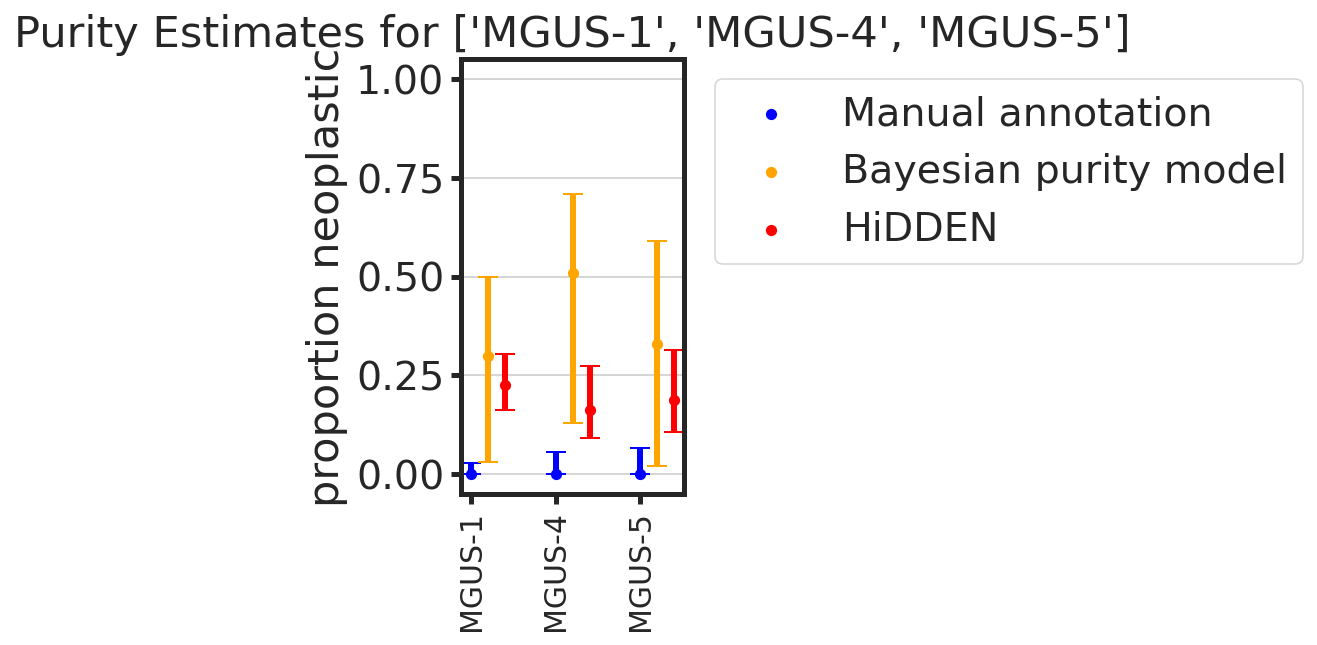

In [16]:
NonMixed_samples = ['MGUS-1', 'MGUS-4', 'MGUS-5']

bayesianpurityestimates_df = pd.read_csv(bayesianpurityestimates_filepath)
bayesianpurityestimates_df.set_index('person', inplace=True)
bayesianpurityestimates_df = bayesianpurityestimates_df[bayesianpurityestimates_df.index.isin(NonMixed_samples)]

subclusteringpurities_df = pd.read_csv(subclusteringpurities_filepath)
subclusteringpurities_df.set_index('person', inplace=True)
subclusteringpurities_df = subclusteringpurities_df.reindex(bayesianpurityestimates_df.index)
subclusteringpurities_df = subclusteringpurities_df[subclusteringpurities_df.index.isin(NonMixed_samples)]

values = []

for i, precursor_sample in enumerate(NonMixed_samples):
    
    adata_purity = adata_full[adata_full.obs['person'].isin([NonMixed_samples[i]])]
    new_labels_df_Sample = pd.read_csv(f'figures/new_labels_df_{NonMixed_samples[i]}.csv', index_col=0)
    #Sample_mask = adata.obs.index.isin(new_labels_df_Sample['cellnames'])
    adata_purity.obs['new_labels'] = 0
    #print(adata_purity)
    #print(new_labels_df_Sample.shape)
    adata_purity.obs['new_labels'] = new_labels_df_Sample['new_labels']
    adata_purity.obs['new_labels'] = new_labels_df_Sample['new_labels'].values
    N = len(adata_purity.obs['new_labels'])
    n = sum(adata_purity.obs['new_labels']==1)
    pest = np.mean(adata_purity.obs['new_labels']==1)
    ci = find_conf_interval_manuallabels(N, n)
    values.append({'person':precursor_sample, 'sample_purity':pest, 'bottom CI':ci[0], 'top CI':ci[1]})

my_estimates_df = pd.DataFrame(values)
my_estimates_df.set_index('person', inplace=True)
#print(my_estimates_df)

data_dict = {'Manual annotation': (subclusteringpurities_df, 0.0, ['beg_interval', 'end_interval'], 'blue'),
             'Bayesian purity model': (bayesianpurityestimates_df, 0.2, ['bottom CI', 'top CI'], 'orange'),
             'HiDDEN': (my_estimates_df, 0.4, ['bottom CI', 'top CI'], 'red')
            }

plt.figure(figsize=(2, 4))
for name, (purity_df, offset, cols, col) in data_dict.items():
    mask = purity_df.index.isin(NonMixed_samples)
    plot_df = purity_df[mask]
    cis = plot_df[cols].to_numpy().T
    lens = (cis[1,:]-cis[0,:])/2 #length of bar
    pts = cis[0,:]+lens #midpoint of bar
    locs = np.arange(len(pts))+offset
    y = plot_df['sample_purity']
    plt.scatter(locs, y , label=name, c=col)
    plt.errorbar(locs, pts, lens, linestyle='', capsize=5, ecolor=col)
    
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(len(NonMixed_samples)), NonMixed_samples, rotation=90, size='x-small')
plt.ylabel('proportion neoplastic')
#plt.xlabel('person')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title(f'Purity Estimates for {NonMixed_samples}')
plt.gca().grid(axis='y')
plt.savefig(f'figures/purity_estimates_NonMixedSamples.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(f'figures/purity_estimates_NonMixedSamples.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/purity_estimates_NonMixedSamples.pdf', transparent=True, bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


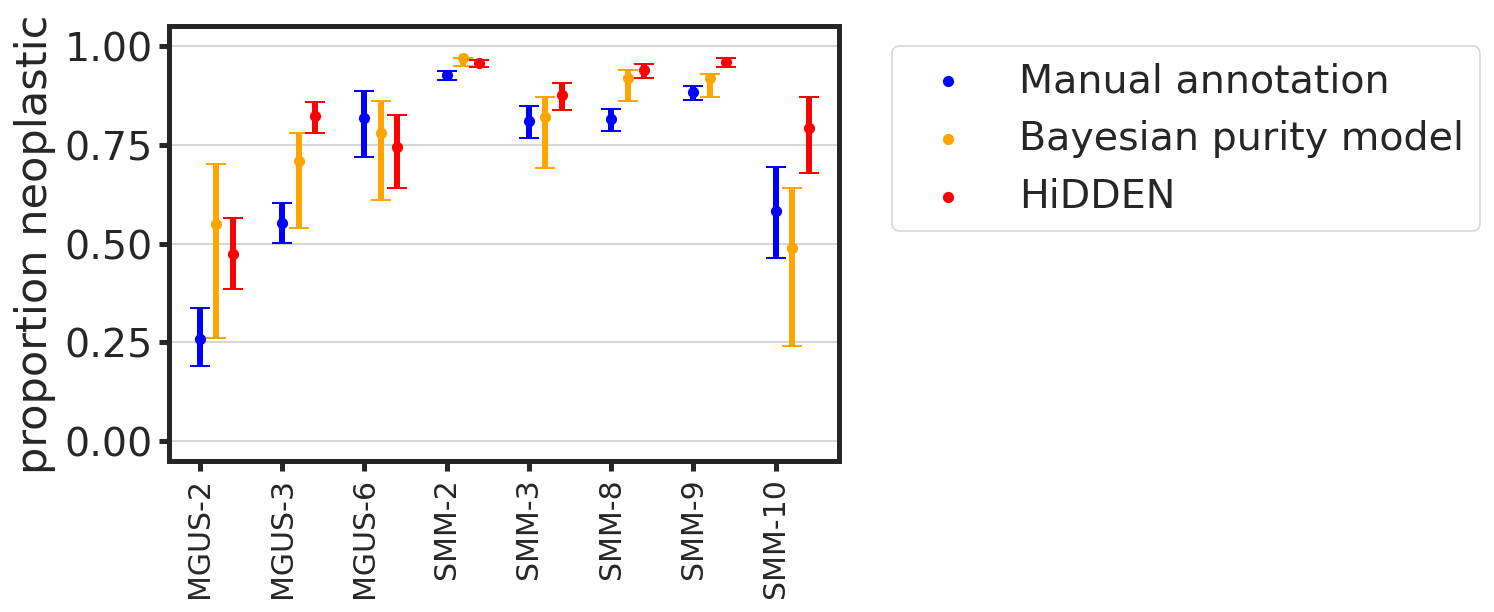

In [17]:
Mixed_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']

bayesianpurityestimates_df = pd.read_csv(bayesianpurityestimates_filepath)
bayesianpurityestimates_df.set_index('person', inplace=True)
bayesianpurityestimates_df = bayesianpurityestimates_df[bayesianpurityestimates_df.index.isin(Mixed_samples)]

subclusteringpurities_df = pd.read_csv(subclusteringpurities_filepath)
subclusteringpurities_df.set_index('person', inplace=True)
subclusteringpurities_df = subclusteringpurities_df.reindex(bayesianpurityestimates_df.index)
subclusteringpurities_df = subclusteringpurities_df[subclusteringpurities_df.index.isin(Mixed_samples)]

values = []

for i, precursor_sample in enumerate(Mixed_samples):
    
    adata_purity = adata_full[adata_full.obs['person'].isin([Mixed_samples[i]])]
    new_labels_df_Sample = pd.read_csv(f'figures/new_labels_df_{Mixed_samples[i]}.csv', index_col=0)
    #Sample_mask = adata.obs.index.isin(new_labels_df_Sample['cellnames'])
    adata_purity.obs['new_labels'] = 0
    #print(adata_purity)
    #print(new_labels_df_Sample.shape)
    adata_purity.obs['new_labels'] = new_labels_df_Sample['new_labels']
    adata_purity.obs['new_labels'] = new_labels_df_Sample['new_labels'].values
    N = len(adata_purity.obs['new_labels'])
    n = sum(adata_purity.obs['new_labels']==1)
    pest = np.mean(adata_purity.obs['new_labels']==1)
    ci = find_conf_interval_manuallabels(N, n)
    values.append({'person':precursor_sample, 'sample_purity':pest, 'bottom CI':ci[0], 'top CI':ci[1]})

my_estimates_df = pd.DataFrame(values)
my_estimates_df.set_index('person', inplace=True)
#print(my_estimates_df)

data_dict = {'Manual annotation': (subclusteringpurities_df, 0.0, ['beg_interval', 'end_interval'], 'blue'),
             'Bayesian purity model': (bayesianpurityestimates_df, 0.2, ['bottom CI', 'top CI'], 'orange'),
             'HiDDEN': (my_estimates_df, 0.4, ['bottom CI', 'top CI'], 'red')
            }

plt.figure(figsize=(6, 4))
for name, (purity_df, offset, cols, col) in data_dict.items():
    mask = purity_df.index.isin(Mixed_samples)
    plot_df = purity_df[mask]
    cis = plot_df[cols].to_numpy().T
    lens = (cis[1,:]-cis[0,:])/2 #length of bar
    pts = cis[0,:]+lens #midpoint of bar
    locs = np.arange(len(pts))+offset
    y = plot_df['sample_purity']
    plt.scatter(locs, y , label=name, c=col)
    plt.errorbar(locs, pts, lens, linestyle='', capsize=5, ecolor=col)
    
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(len(Mixed_samples)), Mixed_samples, rotation=90, size='x-small')
plt.ylabel('proportion neoplastic')
#plt.xlabel('person')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#plt.title(f'Purity Estimates for {Mixed_samples}')
plt.gca().grid(axis='y')
plt.savefig(f'figures/purity_estimates_MixedSamples.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(f'figures/purity_estimates_MixedSamples.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/purity_estimates_MixedSamples.pdf', transparent=True, bbox_inches='tight')

# Figure 3d Normal plasma cell activity signature

In [128]:
infos = []
for index, grp_df in adata_full.obs.groupby('person'):    
    infos.append({'person':index, 
                 'malignant':(grp_df['new_labels']==1).sum(),
                 'healthy':(grp_df['new_labels']==0).sum()})
pd.DataFrame(infos)

person  malignant  healthy
0    NBM-1          0      760
1    NBM-2          0      857
2    NBM-3          0       51
3    NBM-4          0      160
4    NBM-6          0      679
5    NBM-7          0     1569
6    NBM-8          0     1807
7   NBM-10          0     2606
8   NBM-11          0      840
9   MGUS-1         30      103
10  MGUS-2         55       61
11  MGUS-3        305       66
12  MGUS-4         10       52
13  MGUS-5         10       43
14  MGUS-6         61       21
15   SMM-1        439        0
16   SMM-2       1776       81
17   SMM-3        306       43
18   SMM-4        136        0
19   SMM-5         40        0
20   SMM-6       1140        0
21   SMM-7       2049        0
22   SMM-8        667       44
23   SMM-9       1202       51
24  SMM-10         53       14
25  SMM-11        106        0
26  SMM-12        284        0
27    MM-1       2887        0
28    MM-2       3414        0
29    MM-3        950        0
30    MM-4        591        0
31    MM-5       1463        0
32    MM-6        832        0
33    MM-7        100        0
34    MM-8        553        0

In [105]:
# code from Rebecca Boiarsky

#plots of gene expression and signature activity per healthy/malig cells per patient
def plot_per_patient_healthymalig(summary_df, things_to_plot, facet_col='signature', value_col='mean_activity', sample_col='person', label_col="ground_truth", 
                                  normalcells="healthy plasma", ds_col="disease_stage", 
                                  ds_colors=['cornflowerblue', '#F1CE46', '#DC7209', '#880B0B'], 
                                  ylabel='mean activity', ncols=1, ptsize=10, custom_ylim=None, sharey=False, 
                                  sharex=False, figsize=None, legend_fontsize="x-small", filename=None, dpi=300):
    #sigs_to_plot: a list of signatures or genes to plot. must contain a subset of the values in the facet_col column of your summary_df
    #facet_col: column name in summary_df which defines the facets
    #value_col: column name in summary_df for column that contained values that will be plotted
    
    assert isinstance(things_to_plot,list), "things_to_plot must be a list (even if it only contains one element)"

    #initialize figure+subplots
    if figsize is None:
        figsize = (10,5*len(things_to_plot))
    nrows = int(np.ceil(len(things_to_plot)/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, sharex=False, figsize=figsize, squeeze=False)
    plt.xticks(np.arange(0, len(summary_df[sample_col].drop_duplicates())+3, 1.0), rotation=90, size='x-small') #additional 4 (or 3 if now distinction b.w SMMl/h) blank spaces b/w disease stages
    plt.subplots_adjust(hspace=0.3) #increase vertical space between plots otherwise labels may overlap
    if custom_ylim is not None:
        plt.ylim(custom_ylim)
    
    if 'stderror' not in summary_df.columns: #enables user to pass df without calculating error bars
        summary_df['stderror'] = None

    #plot each signature on a subplot
    sig_counter = 0
    for i in np.arange(nrows):
        for j in np.arange(ncols):
            if sig_counter > len(things_to_plot)-1:
                break;
            ax = axes[i,j]

            ## plot aesthetics
            #despine
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_xlabel('patient ID')
            ax.grid(False)

            blue_patch = mpatches.Patch(color=ds_colors[0], label='normal plasma cells')
            mgus_patch = mpatches.Patch(color=ds_colors[1], label='MGUS neoplastic cells')
            smm_patch = mpatches.Patch(color=ds_colors[2], label='SMM neoplastic cells')
            mm_patch = mpatches.Patch(color=ds_colors[3], label='MM neoplastic cells')

            plt.legend(handles=[blue_patch, mgus_patch, smm_patch, mm_patch], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=legend_fontsize)

            ## signature specific settings
            #get signature
            sig = things_to_plot[sig_counter] #signature for this facet

            #patients in descending order
            this_sig_df = summary_df[summary_df[facet_col]==sig].copy()
            #order by disease stage + descending
            #this_sig_df[ds_col] = pd.Categorical(this_sig_df[ds_col], categories=[
            #    'MM','SMM','MGUS','NBM'], ordered=True)
            #this_sig_df.sort_values([ds_col,value_col], ascending=False, inplace=True)
            
            #set title, xticklabels
            ax.set_title(sig) #IDK why i cant get this to work!! this_sig_df.title[0])
            myxlabels = []
            for d in this_sig_df[ds_col].drop_duplicates():
                myxlabels+=list(this_sig_df[this_sig_df[ds_col]==d][sample_col].drop_duplicates())
                myxlabels+=['']
            myxlabels=myxlabels[:-1]
            ax.set_xticklabels(myxlabels)        
            #x axis locations per person, for this sig
            tmp_person_xaxis_loc_dict = dict(zip(myxlabels, np.arange(len(myxlabels))))

            ## plot values with error bars
            # 1. plot the points for each person, with error bars
            # order first by disease stage
            # within each disease stage, order by decreasing values (malignant) (perhaps should be able to choose increasing or decreasing)
            # color by malignant vs. healthy
            # plot malignant points in shades of orange, increasing in intensity with disease stage
            
            if np.all(pd.isna(this_sig_df.stderror)):
                print("WARNING: plotting {} without error bars".format(sig))
                
                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="MGUS")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="MGUS"),value_col], 
                            yerr=None,
                            fmt='o', color=ds_colors[1], ecolor=ds_colors[1], elinewidth=2, capsize=0);

                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="SMM")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="SMM"),value_col], 
                            yerr=None,
                            fmt='o', color=ds_colors[2], ecolor=ds_colors[2], elinewidth=2, capsize=0);

                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="MM")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="MM"),value_col], 
                            yerr=None,
                            fmt='o', color=ds_colors[3], ecolor=ds_colors[3], elinewidth=2, capsize=0);

                #plot healthy points in blue
                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[label_col]==normalcells)][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[label_col]==normalcells),value_col], 
                            yerr=None,
                            fmt='o', color=ds_colors[0], ecolor=ds_colors[0], elinewidth=2, capsize=0);
            
            else: #plot with error bars
                
                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="MGUS")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="MGUS"),value_col], 
                            yerr=this_sig_df[(this_sig_df[ds_col]=="MGUS")].stderror, 
                            fmt='o', color=ds_colors[1], ecolor=ds_colors[1], elinewidth=2, capsize=0);

                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="SMM")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="SMM"),value_col], 
                            yerr=this_sig_df[(this_sig_df[ds_col]=="SMM")].stderror, 
                            fmt='o', color=ds_colors[2], ecolor=ds_colors[2], elinewidth=2, capsize=0);

                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[ds_col]=="MM")][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[ds_col]=="MM"),value_col], 
                            yerr=this_sig_df[(this_sig_df[ds_col]=="MM")].stderror, 
                            fmt='o', color=ds_colors[3], ecolor=ds_colors[3], elinewidth=2, capsize=0);

                #plot healthy points in blue
                ax.errorbar(x=[tmp_person_xaxis_loc_dict[p] for p in this_sig_df[(this_sig_df[label_col]==normalcells)][sample_col]], 
                            y=this_sig_df.loc[(this_sig_df[label_col]==normalcells),value_col], 
                            yerr=this_sig_df[(this_sig_df[label_col]==normalcells)].stderror, 
                            fmt='o', color=ds_colors[0], ecolor=ds_colors[0], elinewidth=2, capsize=0);

            # 2. draw line connecting the points
            #find ppl who have both healthy and malignant cells (same for every facet)
            ppl_who_need_lines = this_sig_df[[sample_col,label_col]].drop_duplicates().groupby(sample_col).size()
            ppl_who_need_lines = ppl_who_need_lines.index[ppl_who_need_lines>1]

            for p in ppl_who_need_lines:
                ax.plot([tmp_person_xaxis_loc_dict[p],tmp_person_xaxis_loc_dict[p]], this_sig_df[this_sig_df[sample_col]==p].sort_values("group")[value_col], linestyle="--", color='lightgray', zorder=1)

            ## add horizontal bars over each disease stage
            barheight=ax.get_ylim()[1]
            ax.axhline(y=barheight, 
                       xmin=0+1/(max(tmp_person_xaxis_loc_dict.values())+2),
                       xmax=(1+max([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='NBM'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       color=ds_colors[0]) #over NBM
            ax.axhline(y=barheight, 
                       xmin=(1+min([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='MGUS'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       xmax=(1+max([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='MGUS'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       color=ds_colors[1]) #
            ax.axhline(y=barheight, 
                       xmin=(1+min([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='SMM'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       xmax=(1+max([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='SMM'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       color=ds_colors[2]) #
            ax.axhline(y=barheight, 
                       xmin=(1+min([tmp_person_xaxis_loc_dict[p] for p in this_sig_df[this_sig_df[ds_col]=='MM'][sample_col]]))/(max(tmp_person_xaxis_loc_dict.values())+2), 
                       xmax=1-1/(max(tmp_person_xaxis_loc_dict.values())+2),
                       color=ds_colors[3]) #


            sig_counter += 1

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight", dpi=dpi)

In [7]:
H_matrix_filepath = os.path.join(dirname, 'normalized_H_matrix.csv')
NMF_signatures_descriptions_filepath = os.path.join(dirname, 'NMF_sig_desc.csv')

In [106]:
H = pd.read_csv(H_matrix_filepath, index_col=0)
signatures_desc = pd.read_csv(NMF_signatures_descriptions_filepath) 

In [9]:
adata_full.obs = adata_full.obs.join(H)

In [46]:
# adata_full.obs['log'+H.columns] = np.log10(H[H.columns]+1)

In [10]:
person_mean_activity_long = adata_full.obs.groupby(['person','ground_truth'])[H.columns].mean().reset_index().merge(adata_full.obs[['person','disease_stage']], 
    left_on="person", right_on="person").drop_duplicates().reset_index().drop(columns="index").melt(id_vars=["person", "ground_truth", "disease_stage"], 
                                                                                                          var_name="signature", value_name='mean_activity')
person_mean_activity_long = person_mean_activity_long.dropna() #drop columns with NA under mean_activity
person_mean_activity_long = person_mean_activity_long.merge(signatures_desc, left_on="signature", right_on="signature").rename(columns={'desc':'signature_desc'})
#add std
person_mean_activity_long = adata_full.obs.groupby(['person','ground_truth'])[H.columns].std().reset_index().melt(id_vars=["person", "ground_truth"], 
                                     var_name="signature", value_name='stdev').merge(person_mean_activity_long, left_on=['person','ground_truth','signature'], 
                                                                                     right_on=['person','ground_truth','signature'])
#add n
person_mean_activity_long = adata_full.obs.groupby(['person','ground_truth']).size().reset_index().rename(columns={0:'n'}).merge(person_mean_activity_long, 
                                                                        left_on=['person','ground_truth'], right_on=['person','ground_truth'])

person_mean_activity_long['title'] = person_mean_activity_long.signature + ' (' + person_mean_activity_long.description + ')'
person_mean_activity_long['group'] = person_mean_activity_long.disease_stage.astype(str) + ' ' + person_mean_activity_long.ground_truth.astype(str)


In [ ]:
# with the new_labels from HiDDEN

In [34]:
Precursor_samples = ['MGUS-1', 'MGUS-4', 'MGUS-5', 'MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']

adata_full.obs['new_labels'] = 0
adata_full.obs['new_labels'] = adata_full.obs.person.apply(lambda x: 1 if x in ['SMM-1', 'SMM-4', 'SMM-5', 'SMM-5', 'SMM-6', 'SMM-7', 'SMM-11', 'SMM-12', 
                                                                                  'MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8'] else 0)
for i, precursor_sample in enumerate(Precursor_samples):
    
    new_labels_df_Sample = pd.read_csv(f'figures/new_labels_df_{Precursor_samples[i]}.csv', index_col=0)
    Sample_mask = adata_full.obs.index.isin(new_labels_df_Sample['cellnames'])
    adata_full.obs['new_labels'][Sample_mask] = new_labels_df_Sample['new_labels']
    adata_full.obs['new_labels'][Sample_mask] = new_labels_df_Sample['new_labels'].values

In [35]:
person_mean_activity_long_new = adata_full.obs.groupby(['person','new_labels'])[H.columns].mean().reset_index().merge(adata_full.obs[['person','disease_stage']], 
    left_on="person", right_on="person").drop_duplicates().reset_index().drop(columns="index").melt(id_vars=["person", "new_labels", "disease_stage"], 
                                                                                                          var_name="signature", value_name='mean_activity')
person_mean_activity_long_new = person_mean_activity_long_new.dropna() #drop columns with NA under mean_activity
person_mean_activity_long_new = person_mean_activity_long_new.merge(signatures_desc, left_on="signature", right_on="signature").rename(columns={'desc':'signature_desc'})
#add std
person_mean_activity_long_new = adata_full.obs.groupby(['person','new_labels'])[H.columns].std().reset_index().melt(id_vars=["person", "new_labels"], 
                                     var_name="signature", value_name='stdev').merge(person_mean_activity_long_new, left_on=['person','new_labels','signature'], 
                                                                                     right_on=['person','new_labels','signature'])
#add n
person_mean_activity_long_new = adata_full.obs.groupby(['person','new_labels']).size().reset_index().rename(columns={0:'n'}).merge(person_mean_activity_long_new, 
                                                                        left_on=['person','new_labels'], right_on=['person','new_labels'])

person_mean_activity_long_new['title'] = person_mean_activity_long_new.signature + ' (' + person_mean_activity_long_new.description + ')'
person_mean_activity_long_new['group'] = person_mean_activity_long_new.disease_stage.astype(str) + ' ' + person_mean_activity_long_new.new_labels.astype(str)

In [46]:
adata_full.uns["new_labels_colors"] = ['royalblue', 'goldenrod', 'chocolate', 'maroon']

In [50]:
signatures_desc

signature                                        description  \
0         W1                                            unknown   
1         W2                                               MM-1   
2         W3                                t(11;14) associated   
3         W4                                       HLA class II   
4         W5                                           histones   
5         W6                                            unknown   
6         W7                                               MM-4   
7         W8                                t(14;20) associated   
8         W9                            extracellular signaling   
9        W10                                             RPL36A   
10       W11                                      proliferation   
11       W12                    monocytic ambient contamination   
12       W13                                                FOS   
13       W14                                            unknown   
14       W15                                             SMMh-5   
15       W16                       normal plasma cell signature   
16       W17                                               MM-5   
17       W18                                                JUN   
18       W19                                             SMMh-4   
19       W20  protein synthesis (ser/thr kinase; elongation ...   
20       W21                                              HSPA5   
21       W22                                             TMSB4X   
22       W23                                               MM-3   
23       W24                               interferon inducible   
24       W25                                                UBC   
25       W26                                            unknown   
26       W27  nuclear genes (opposite expression pattern to ...   
27       W28                                 CXCR4 & regulators   

                type                                          top_genes  
0                NaN                ['JUNB', 'ZFP36', 'NFKBIA', 'IER2']  
1   patient specific               ['MTDH', 'HLA-A', 'IFI27', 'SNHG25']  
2                NaN      ['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13']  
3                NaN    ['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1']  
4                NaN  ['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA05...  
5                NaN              ['DUSP4', 'GADD45A', 'BTG2', 'LAMP5']  
6   patient specific                ['IFI6', 'PTP4A3', 'HLA-A', 'LAG3']  
7                NaN           ['ITGB7', 'AC233755.2', 'SPP1', 'CCND2']  
8                NaN                ['LGALS1', 'VIM', 'ACTB', 'S100A6']  
9        single gene            ['RPL36A', 'NBEAL1', 'IFITM1', 'LAMP5']  
10               NaN           ['HIST1H4C', 'STMN1', 'TUBA1B', 'HMGB2']  
11     contamination              ['SAT1', 'S100A9', 'S100A8', 'CRIP1']  
12       single gene                   ['FOS', 'RPPH1', 'ID1', 'CDKL3']  
13               NaN             ['KLF6', 'TSC22D3', 'ANKRD28', 'KLF2']  
14  patient specific          ['AREG', 'KLF4', 'NEAT1', 'CTA-292E10.6']  
15               NaN                ['CD27', 'CD79A', 'TXNIP', 'JSRP1']  
16  patient specific                 ['EIF3L', 'MYC', 'RPL36A', 'JUNB']  
17       single gene                    ['JUN', 'FOSB', 'EGR1', 'IER2']  
18  patient specific                 ['CST3', 'ITM2C', 'MTDH', 'TIMP1']  
19               NaN           ['HNRNPH1', 'PIM2', 'C16orf54', 'PHKG1']  
20       single gene                ['HSPA5', 'CST6', 'EPCAM', 'HYOU1']  
21       single gene            ['TMSB4X', 'PMAIP1', 'LAPTM5', 'FNBP1']  
22  patient specific                   ['FRZB', 'CCL3', 'CCL4', 'DKK1']  
23               NaN                ['ISG15', 'MX1', 'TNFSF10', 'LY6E']  
24       single gene             ['UBC', 'C1GALT1C1', 'SLC3A2', 'LMF1']  
25               NaN                ['HLA-A', 'ITM2C', 'PRR15', 'ACTB']  
26               NaN             ['NEAT1', 'DDX17', 'ANKRD12'

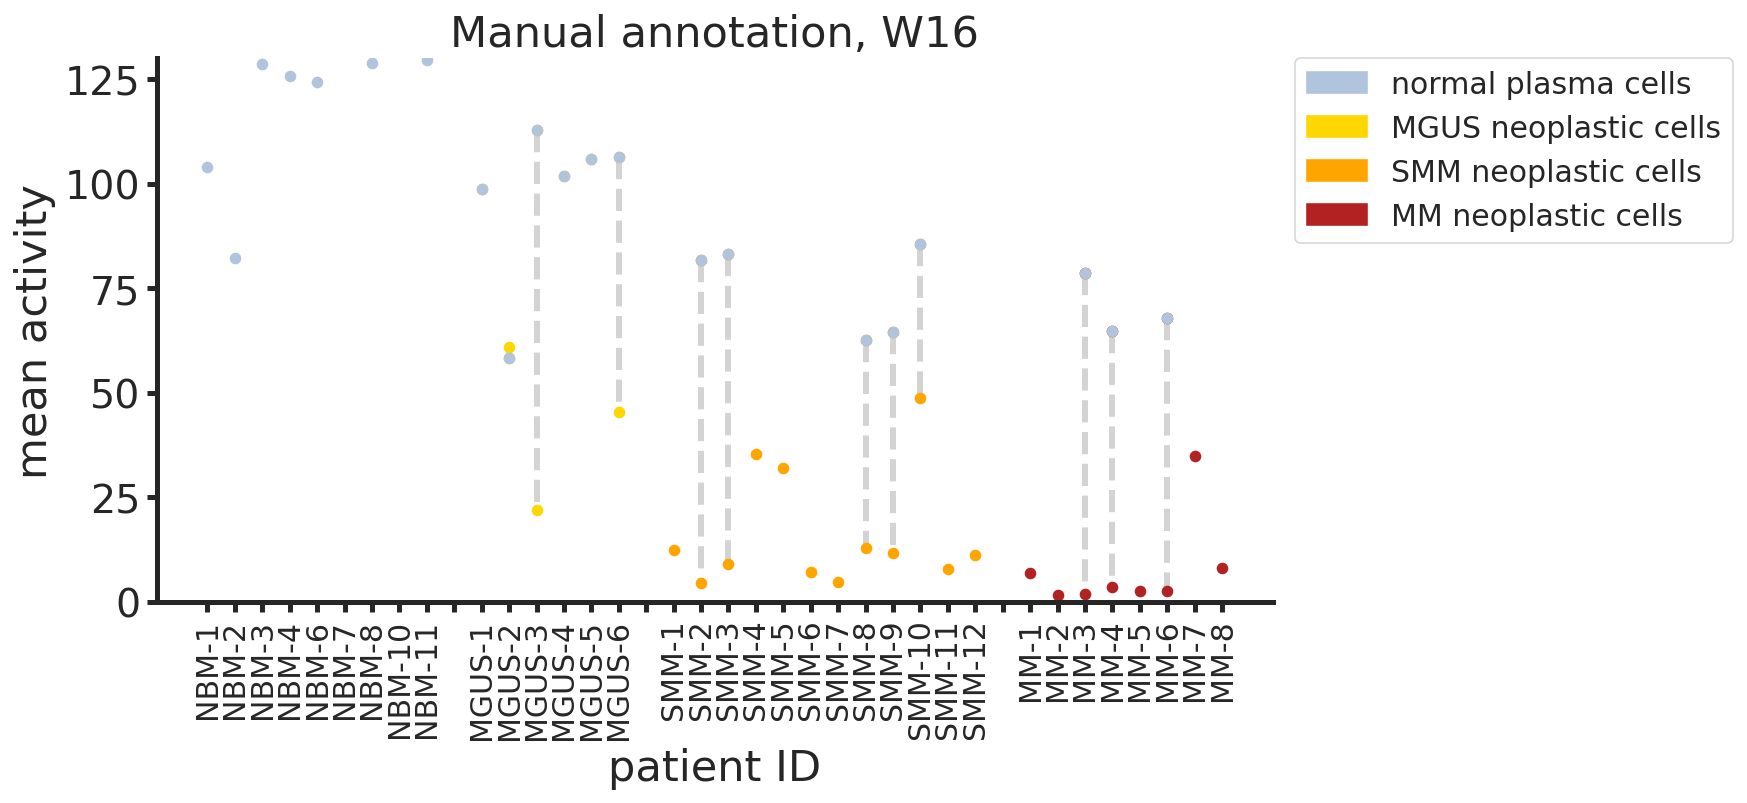

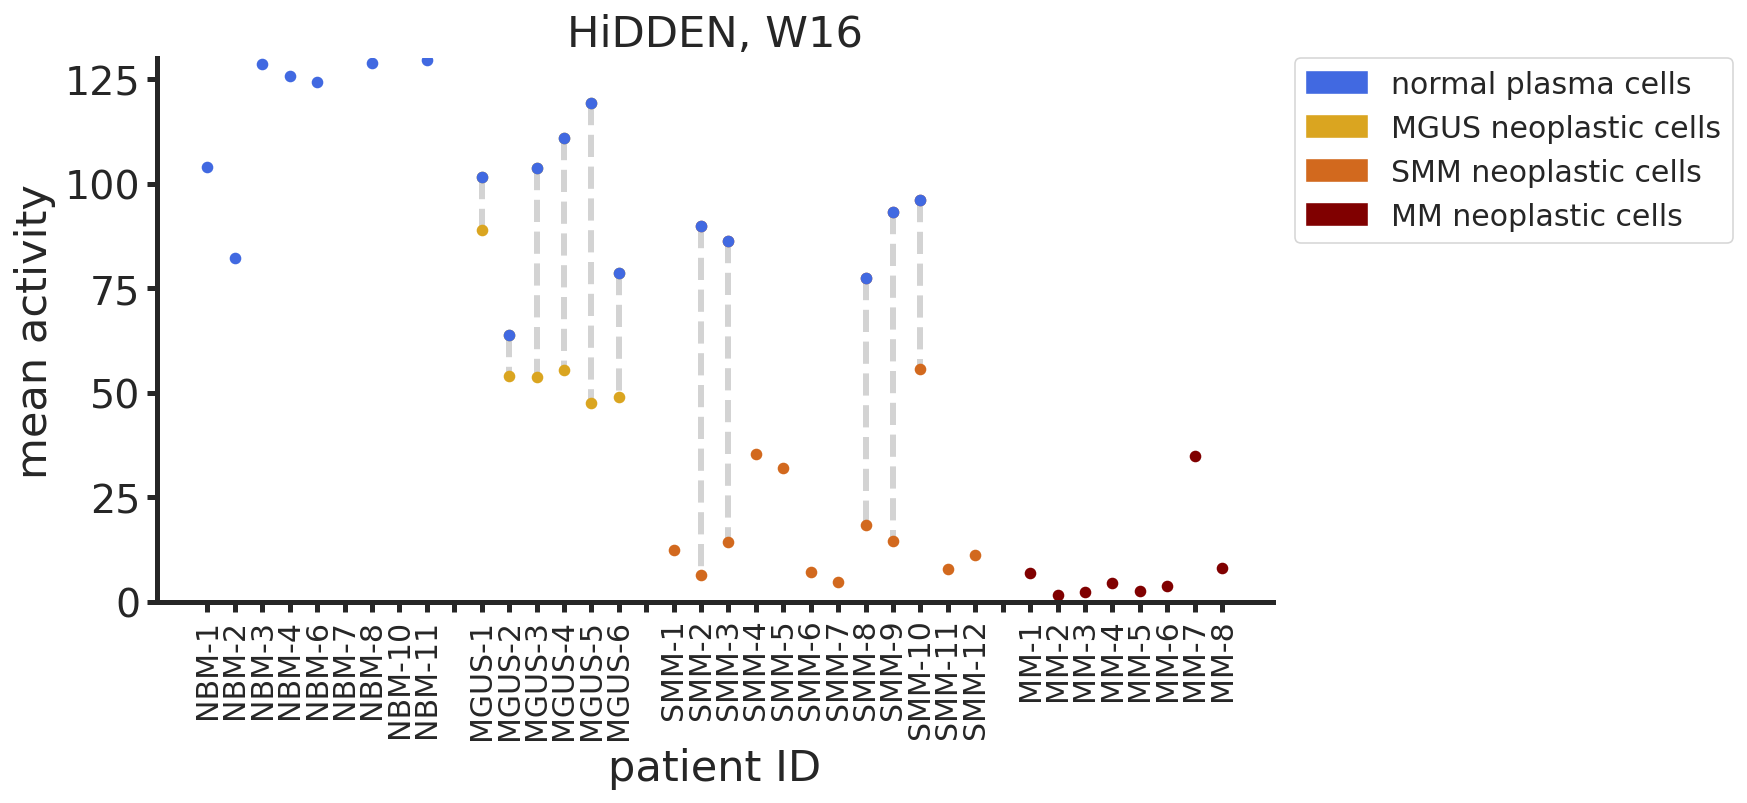

In [112]:
signatures_vec = ['W16']
YLIM = 130
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

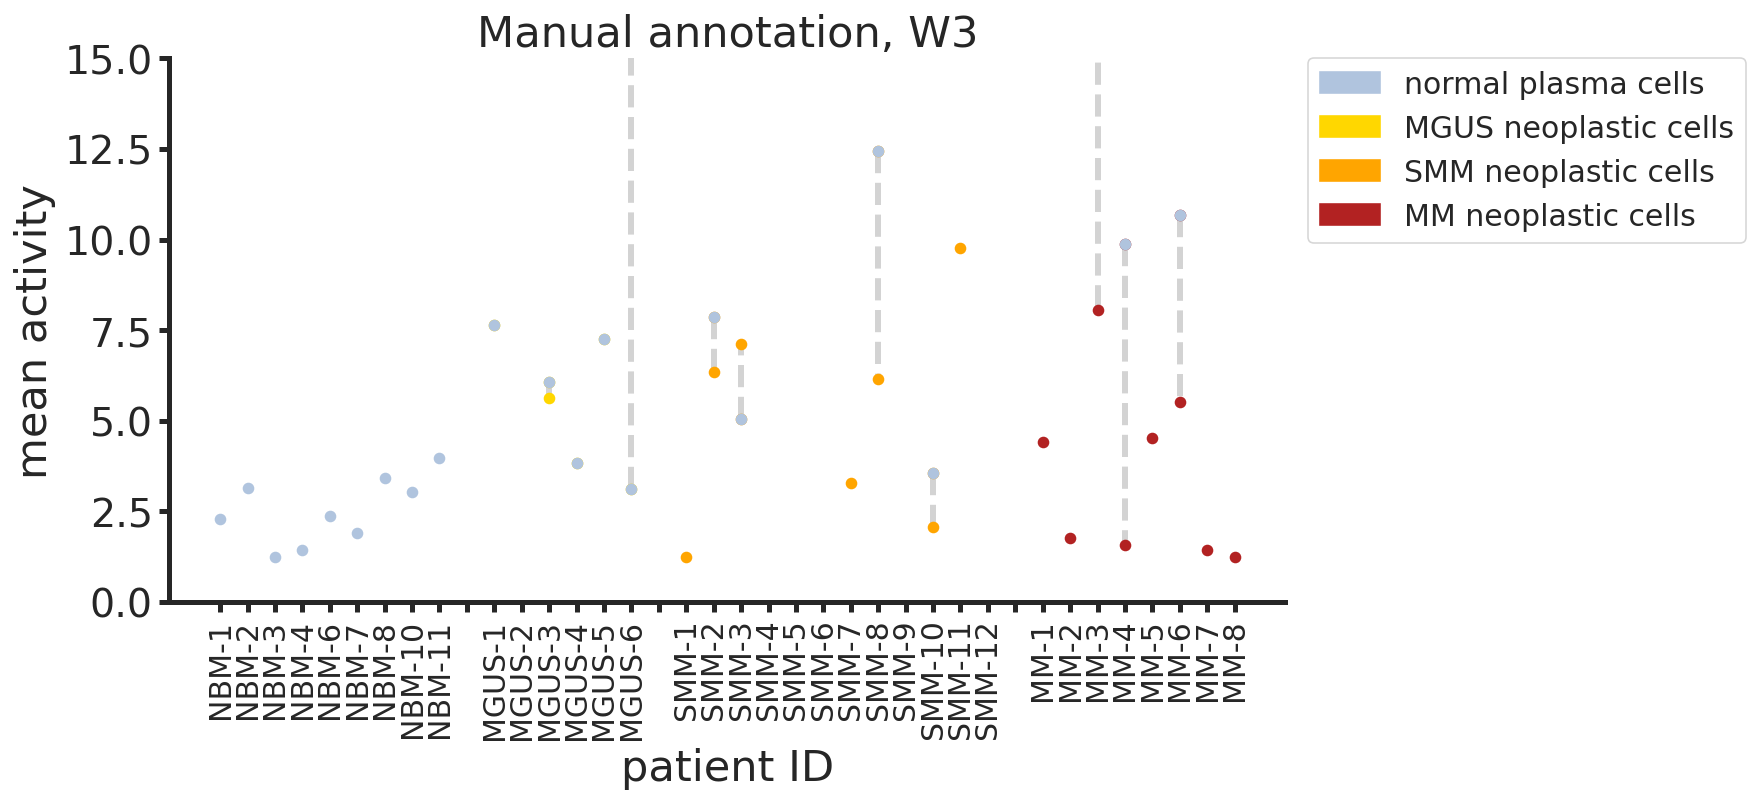

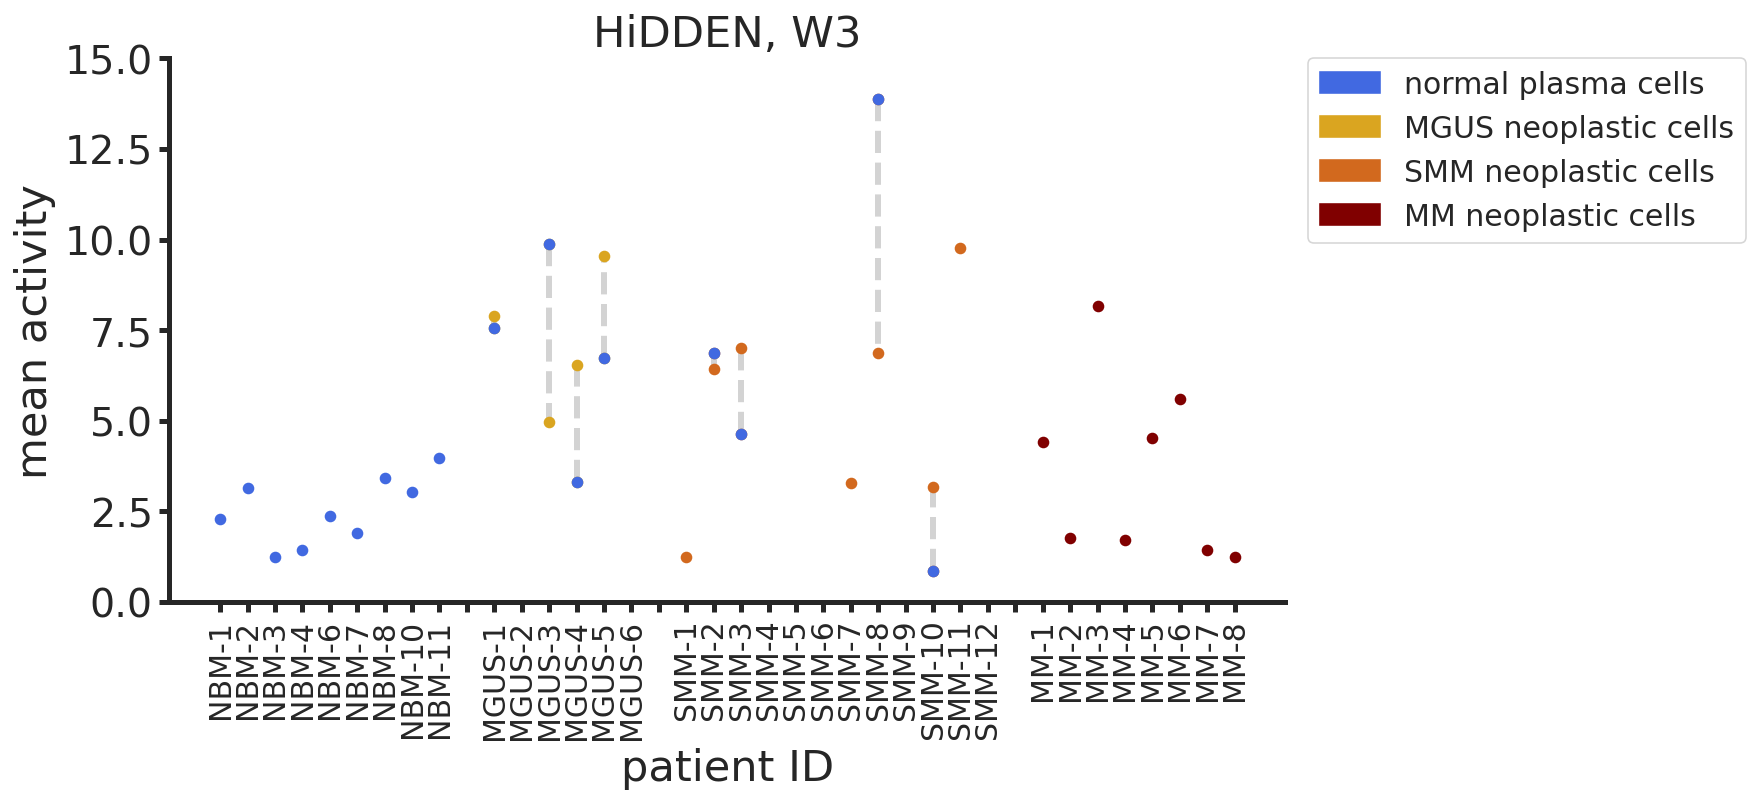

In [113]:
signatures_vec = ['W3']
YLIM = 15
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

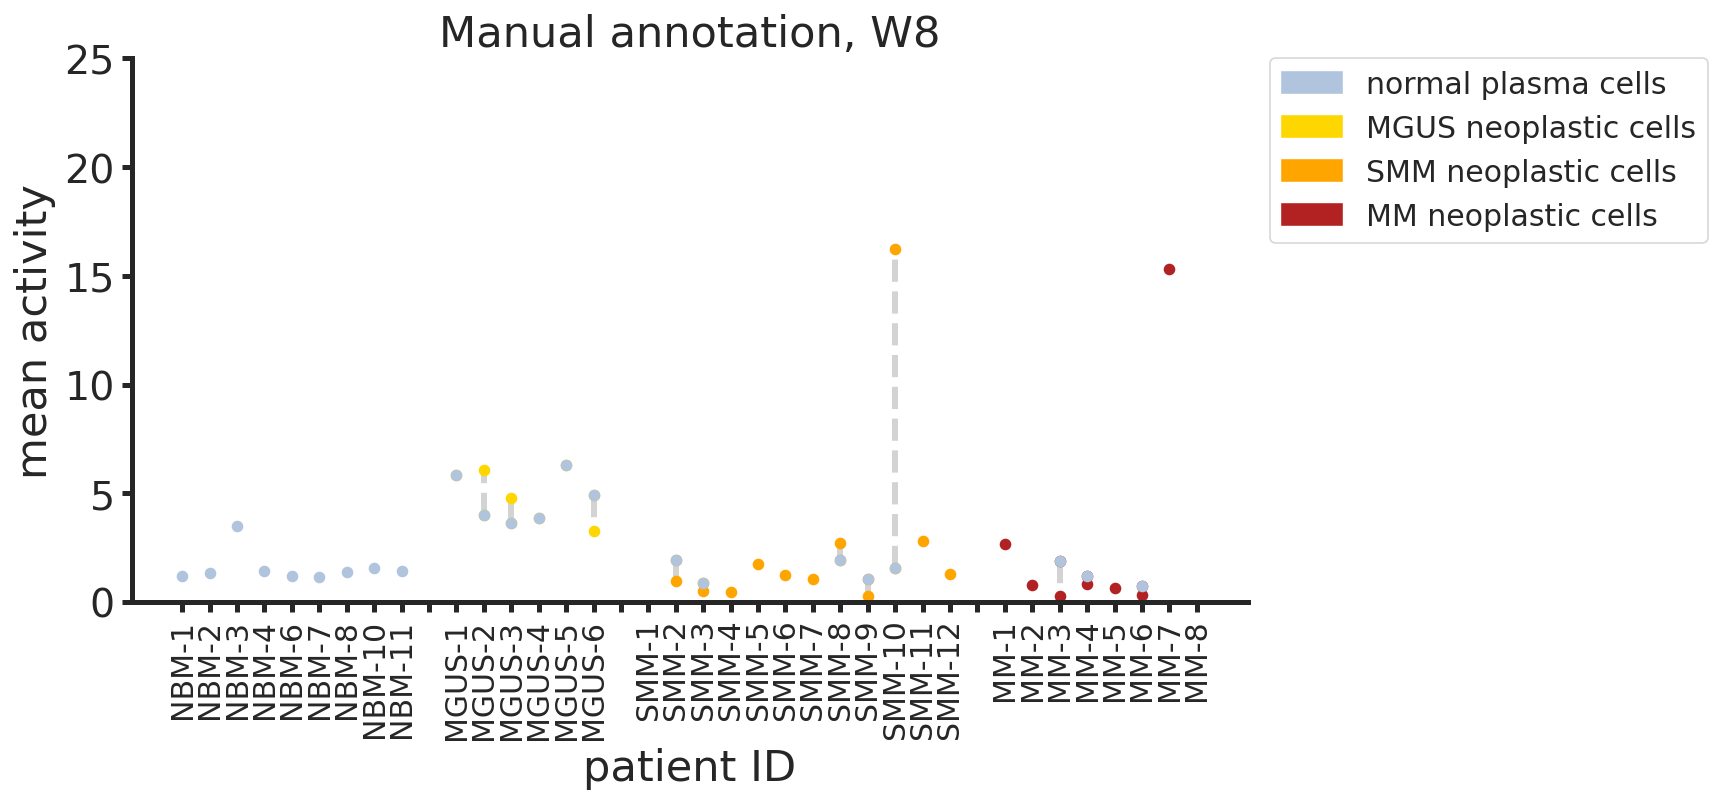

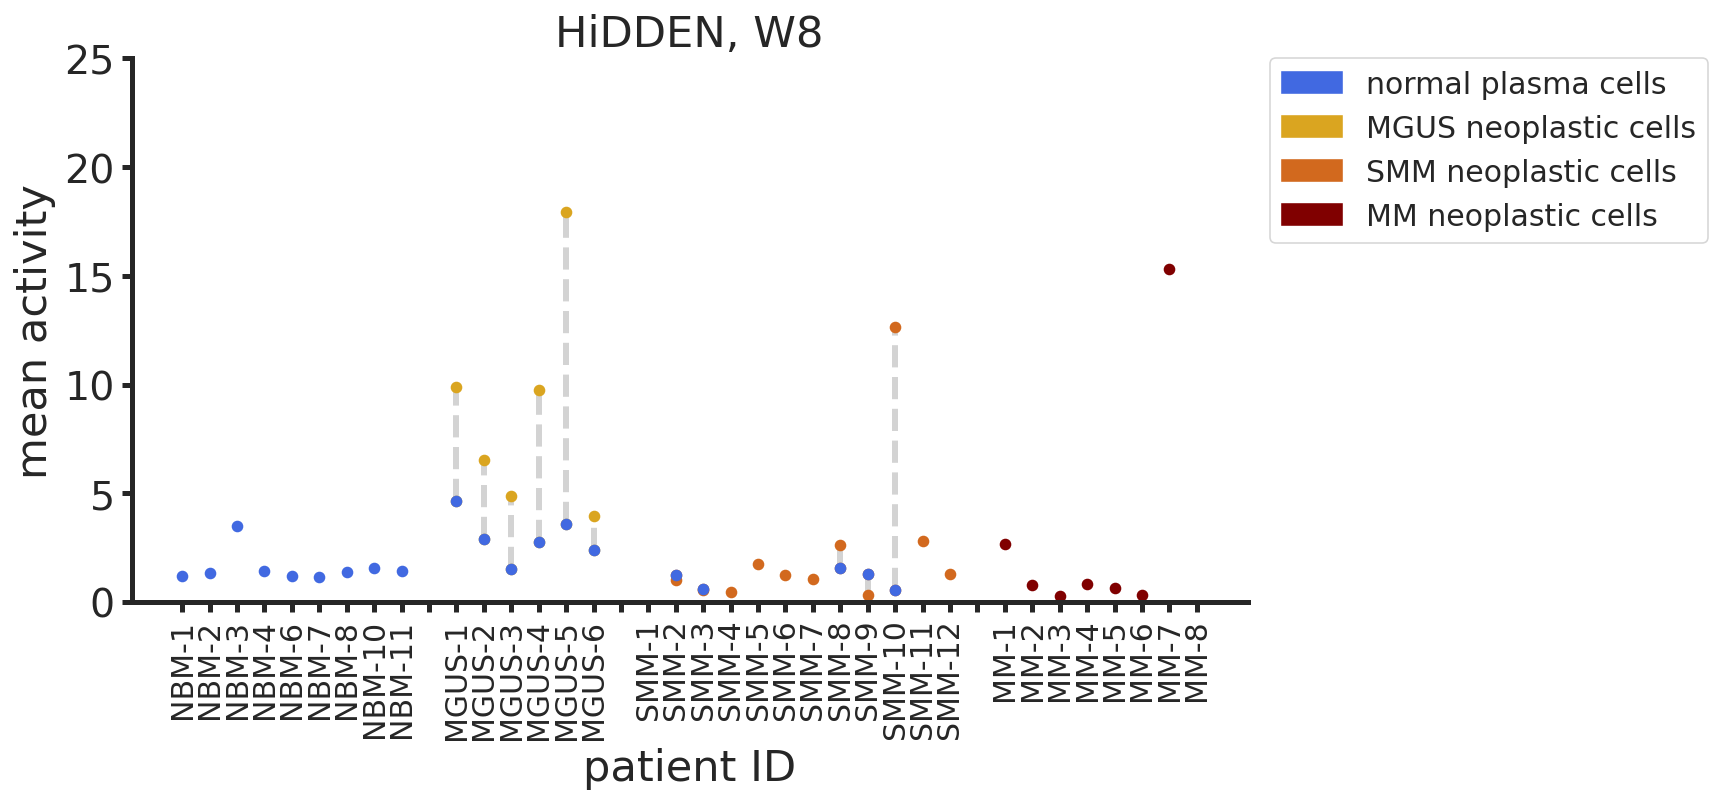

In [131]:
signatures_vec = ['W8']
YLIM = 25
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

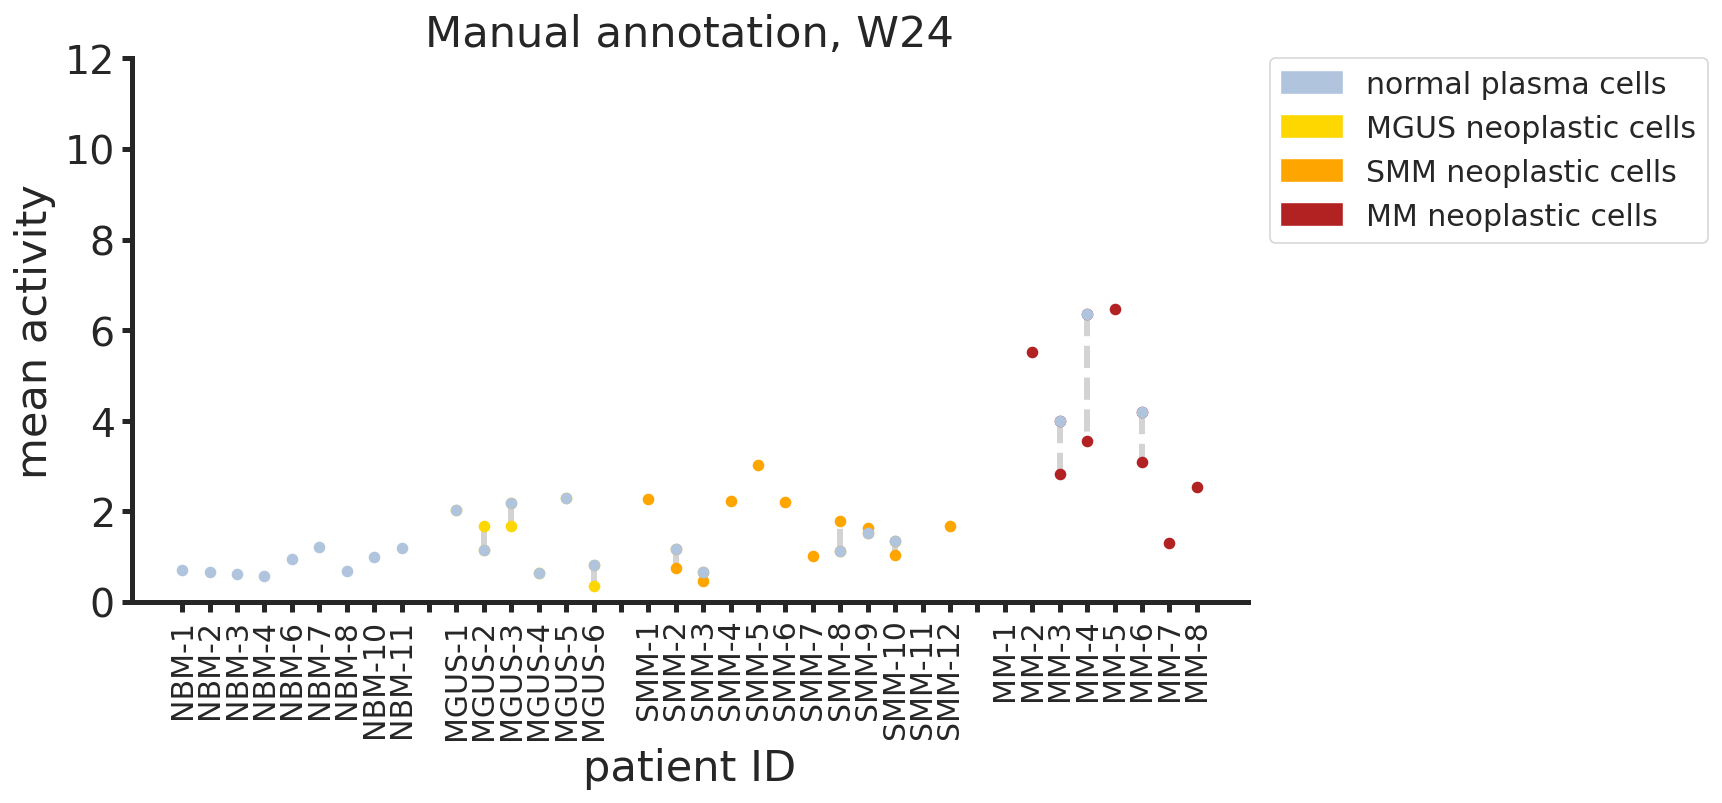

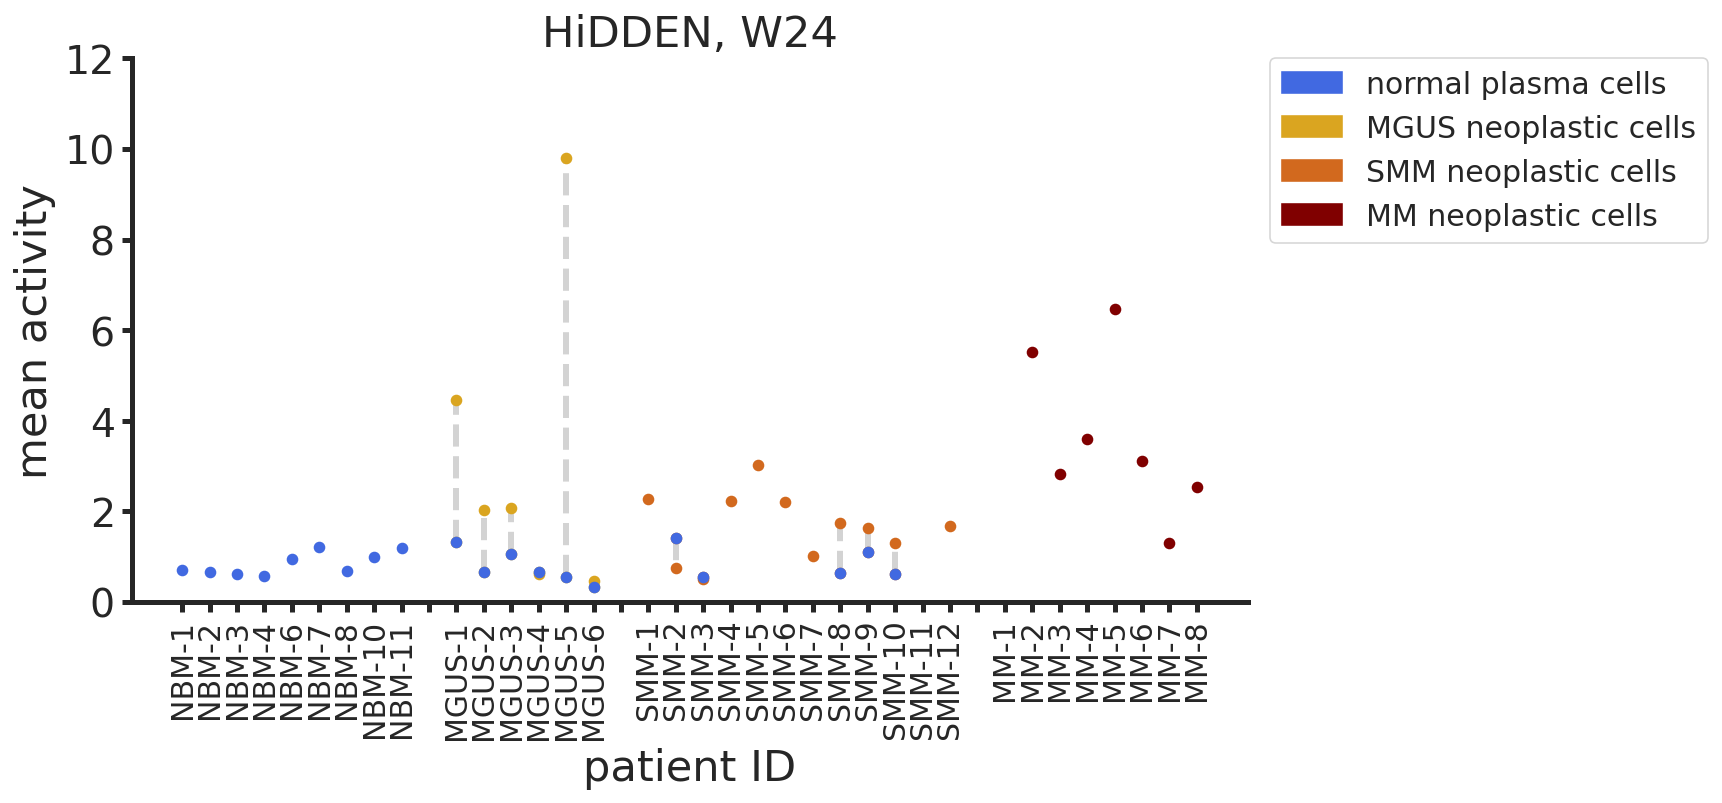

In [115]:
signatures_vec = ['W24']
YLIM = 12
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

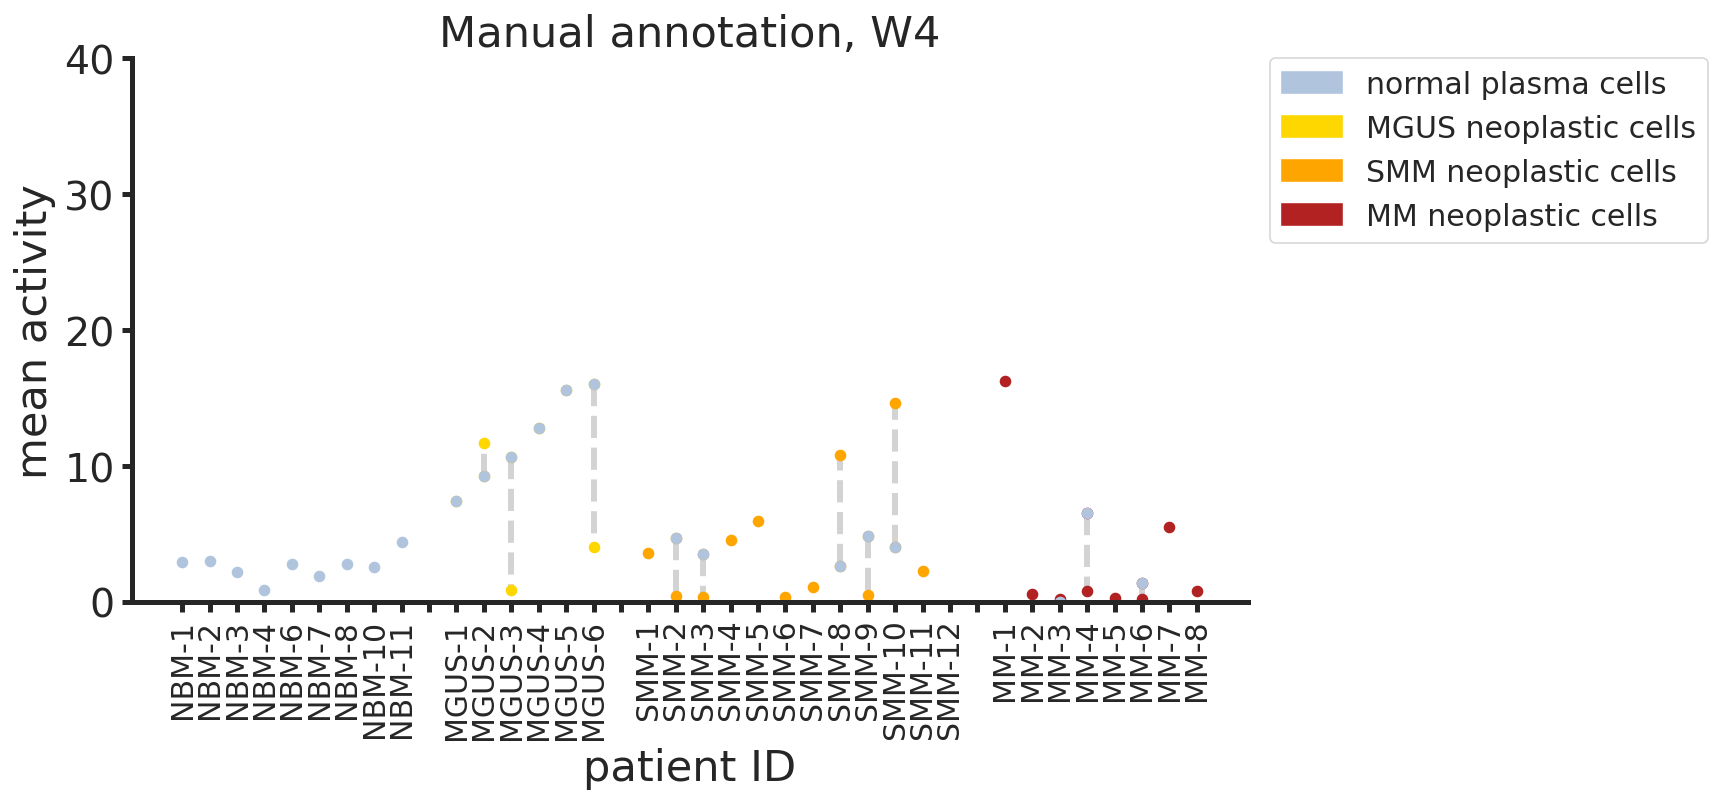

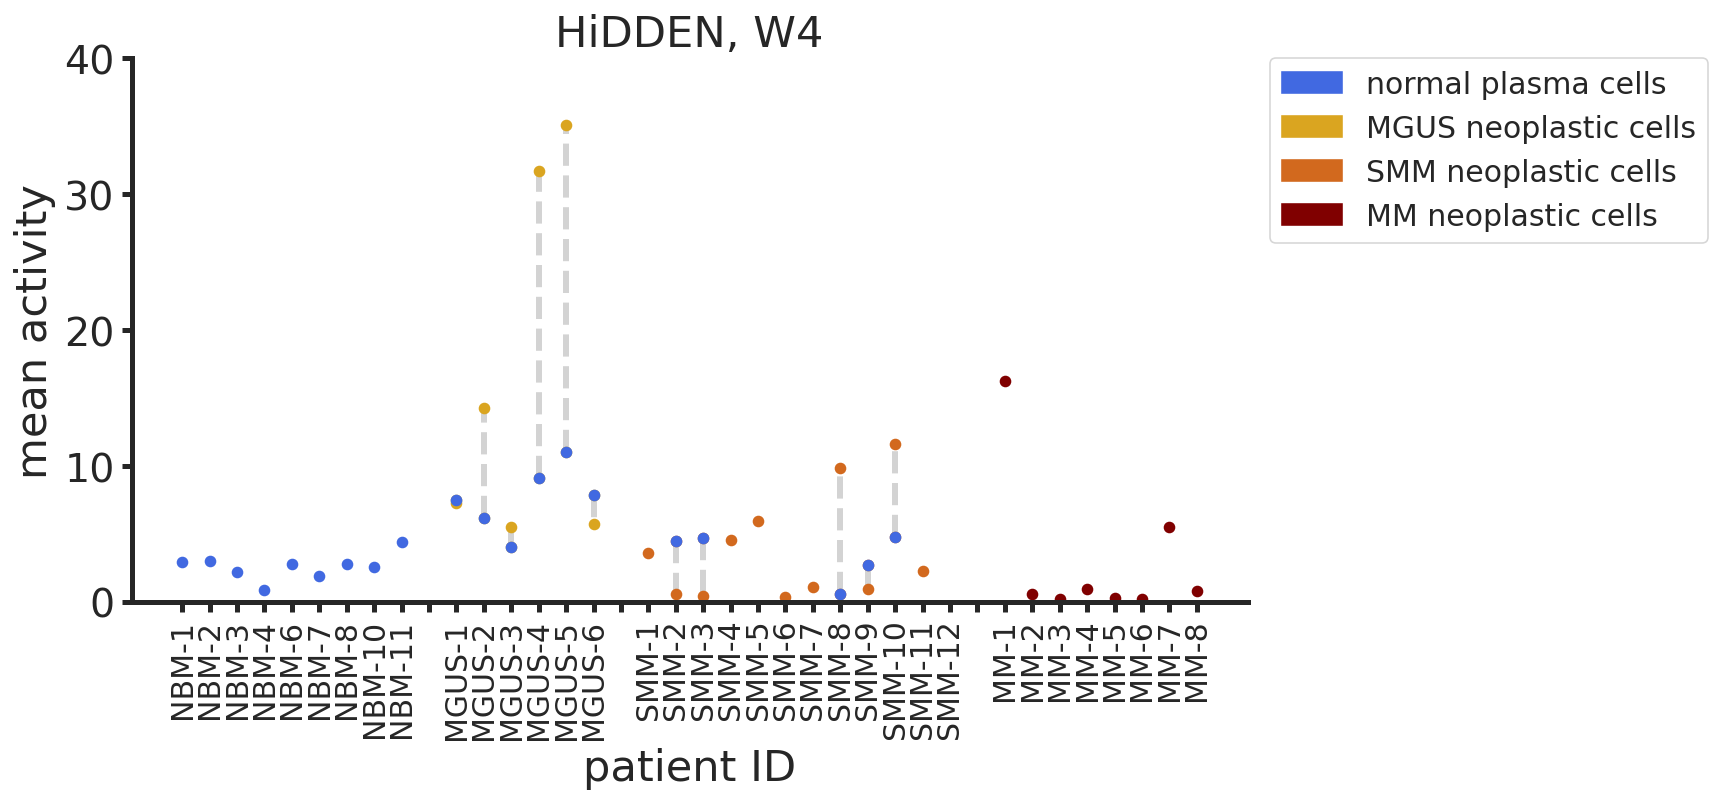

In [121]:
signatures_vec = ['W4']
YLIM = 40
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

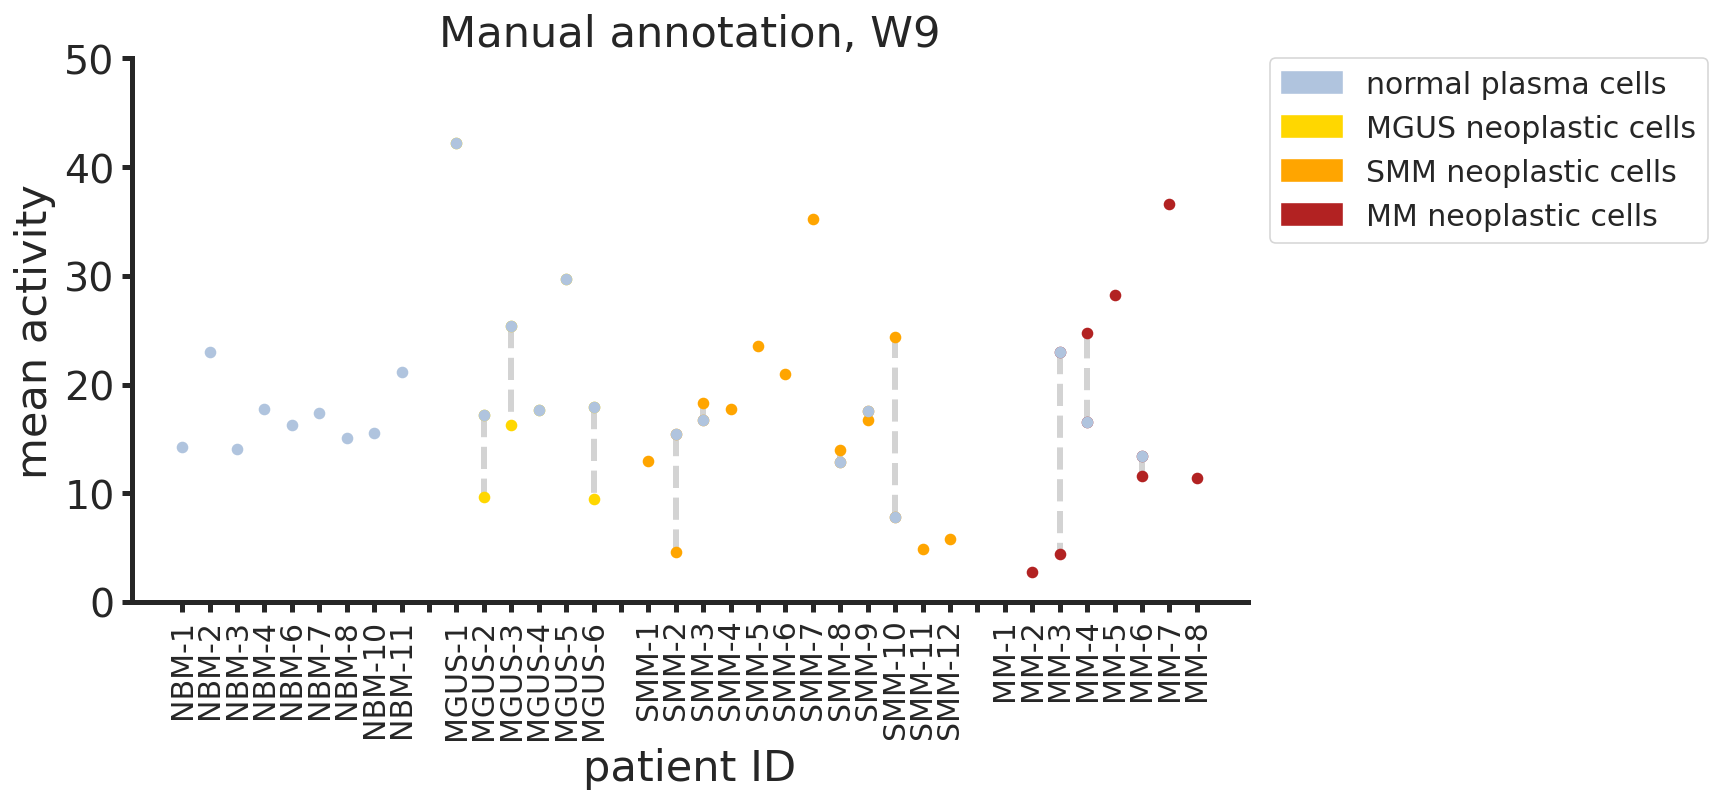

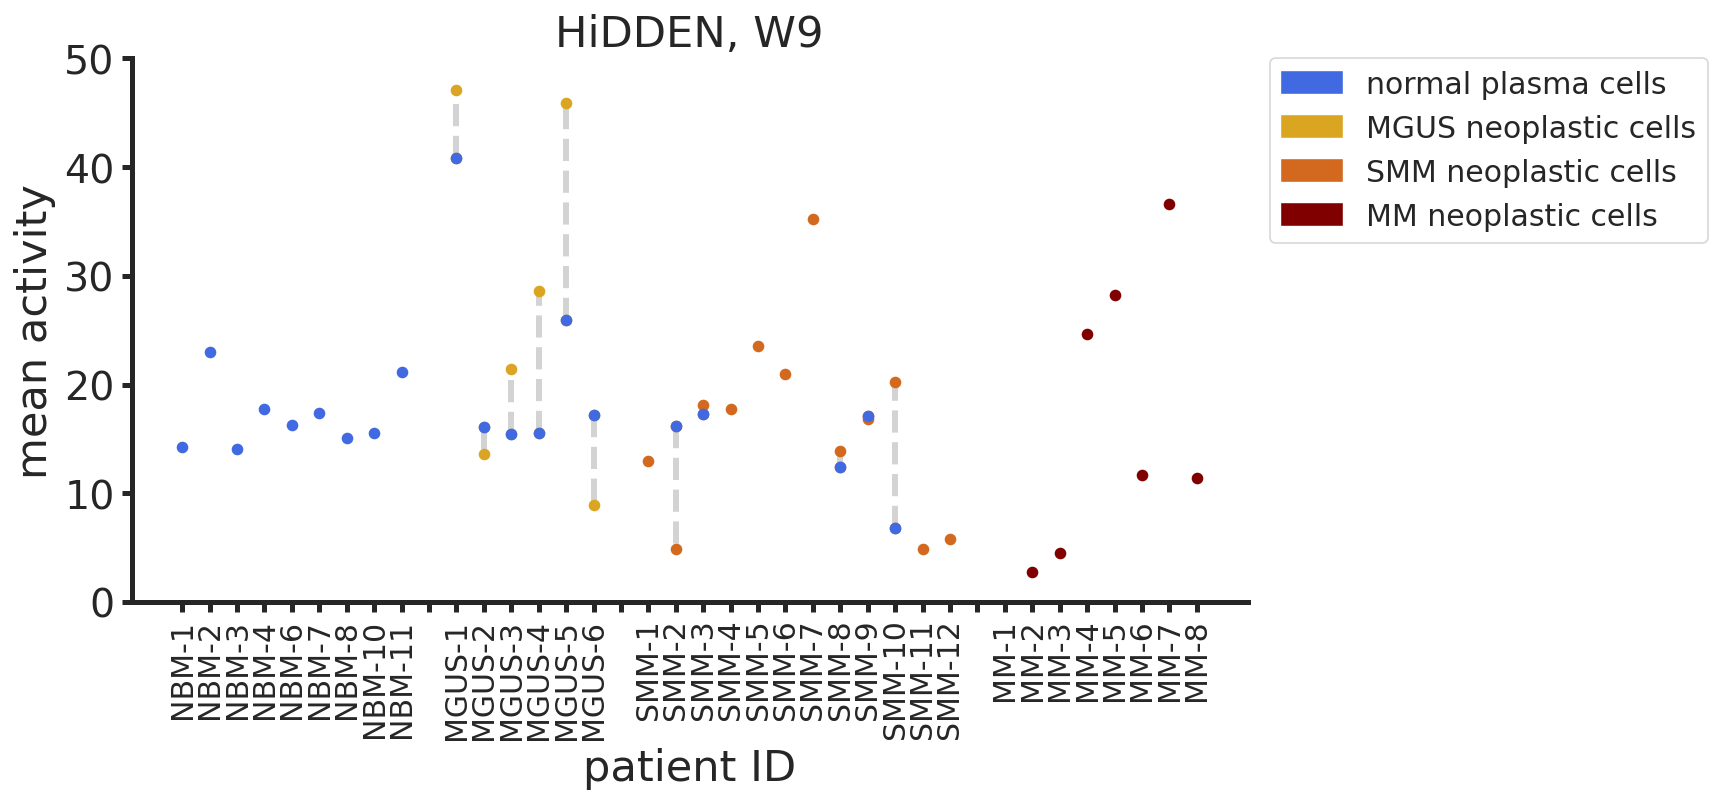

In [ ]:
signatures_vec = ['W9']
YLIM = 50
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['lightsteelblue', 'gold', 'orange', 'firebrick'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'Manual annotation, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_Manual_annotation.pdf', transparent=True, bbox_inches='tight')
    
for i, sig in enumerate(signatures_vec): 
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=['royalblue', 'goldenrod', 'chocolate', 'maroon'], 
                                  ylabel='mean activity', ncols=1, ptsize=20, 
                                  sharey=False, sharex=False, figsize=None, dpi=300)
    plt.setp(plt.gca(), ylim=(0,YLIM), title=f'HiDDEN, {signatures_vec[i]}')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.svg', transparent=True, bbox_inches='tight')
    plt.savefig(f'figures/{signatures_vec[i]}_HiDDEN.pdf', transparent=True, bbox_inches='tight')

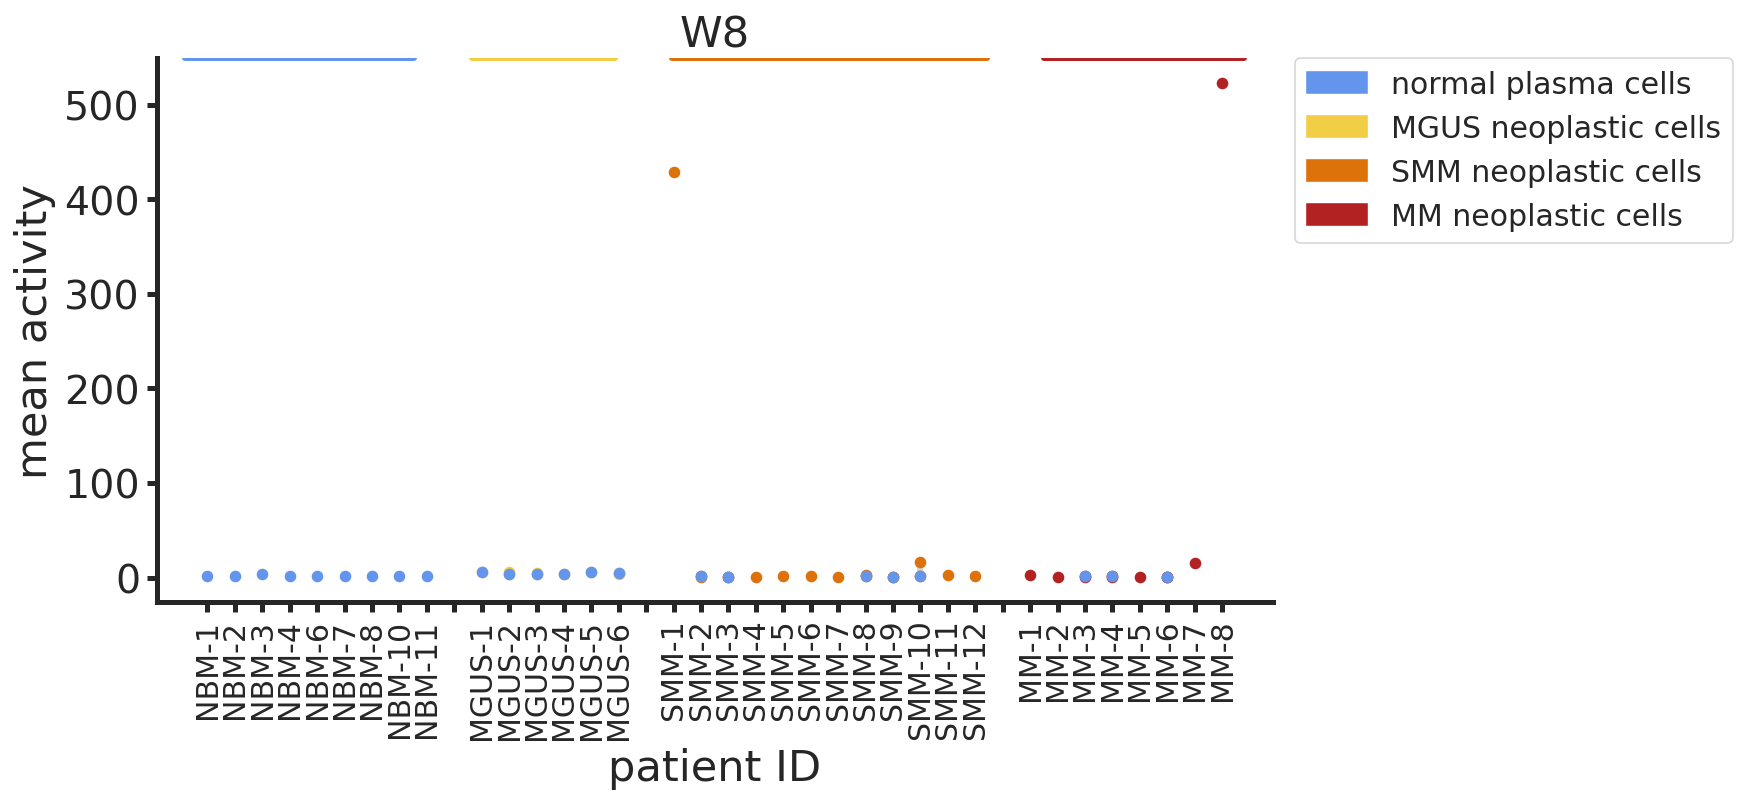

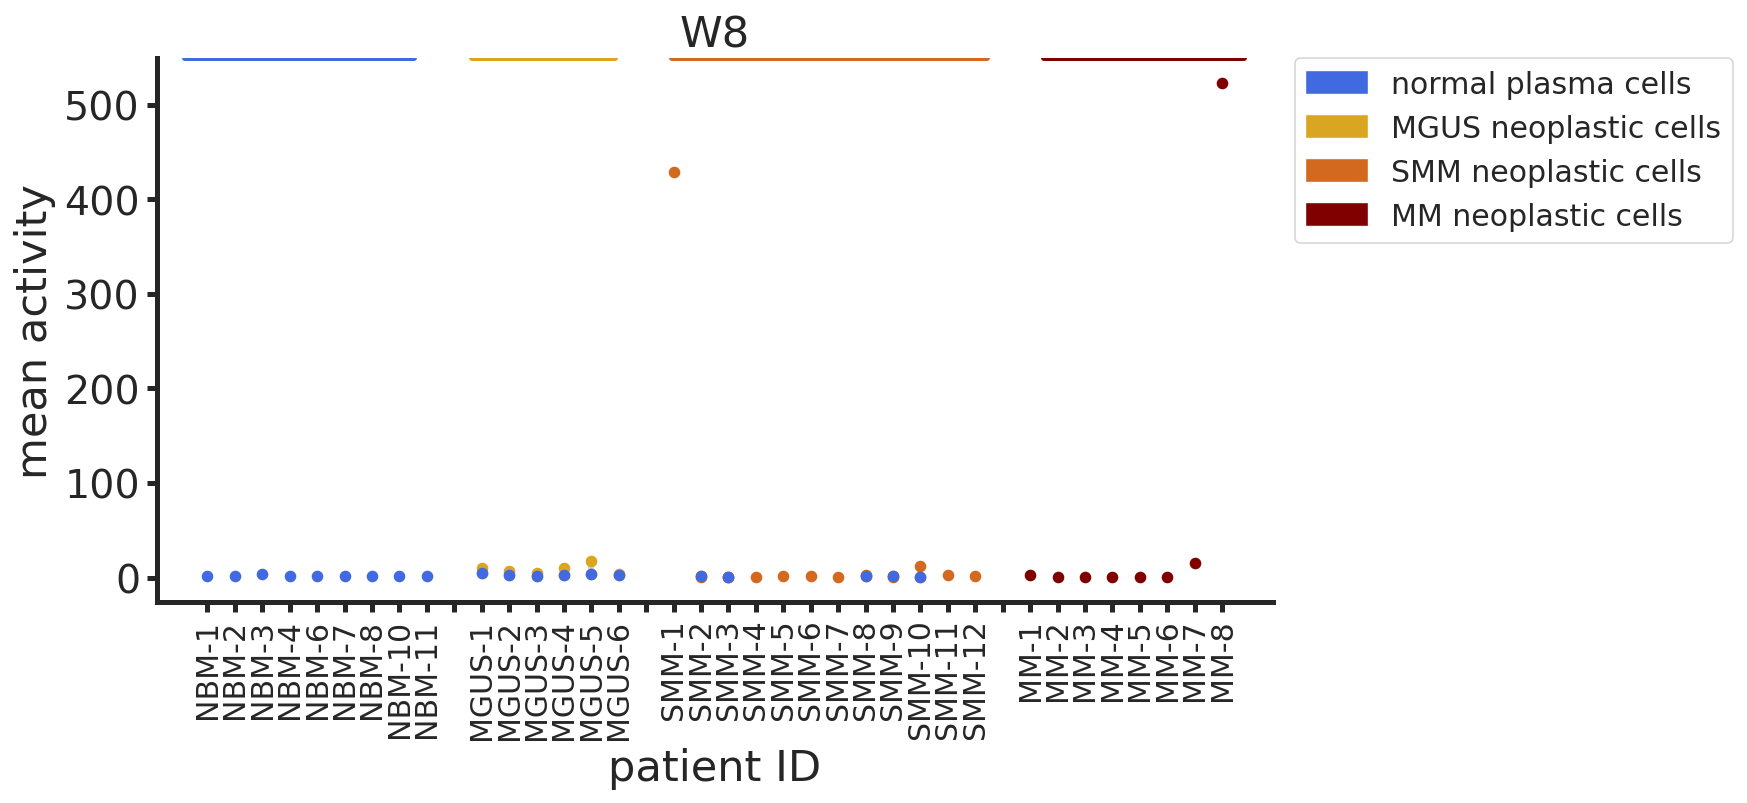

In [129]:
for sig in ['W8']: #need to loop because xticklabels arent working properly otherwise
    plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="ground_truth", normalcells="healthy plasma", 
                                  ds_colors=['cornflowerblue', '#F1CE46', '#DC7209', 'firebrick'], ylabel='mean activity', ncols=1, ptsize=6, 
                                  sharey=False, sharex=False, figsize=None, dpi=180)

for sig in ['W8']: #need to loop because xticklabels arent working properly otherwise
    plot_per_patient_healthymalig(person_mean_activity_long_new, [sig], facet_col='signature', value_col='mean_activity', 
                                  sample_col='person', label_col="new_labels", normalcells=0, 
                                  ds_colors=adata_full.uns["new_labels_colors"], ylabel='mean activity', ncols=1, ptsize=6, 
                                  sharey=False, sharex=False, figsize=None, dpi=180)

# Figure 3e DE genes

In [7]:
NBM_samples = ['NBM-1', 'NBM-2', 'NBM-3',  'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11']
Precursor_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10',
                     'MGUS-1', 'MGUS-4', 'MGUS-5']
MM_samples = ['MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8']

In [8]:
DE_new_union = []

for i, precursor_sample in enumerate(Precursor_samples):
    
    DE_new_Sample = pd.read_csv(f'figures/DE_new_{Precursor_samples[i]}.csv', index_col=0)[f'DE_new_{Precursor_samples[i]}'].values
    DE_new_union = np.union1d(DE_new_union, DE_new_Sample)
    print(DE_new_union.shape)

(12,)
(785,)
(787,)
(4279,)
(5054,)
(7133,)
(8005,)
(8160,)
(8169,)
(8172,)
(8208,)


In [9]:
# DE baseline: NBM vs MM samples
adata = subset_and_preprocess(adata_full, NBM_samples, [], MM_samples)

Trying to set attribute `.obs` of view, copying.


In [10]:
lfc_ground_p_df = pd.DataFrame({'malignant_n':[]}).set_index('malignant_n').reindex(index=adata.var.index.values)

# max abs(log-fold change) over samples for the selected genes
lfc_ground_truth_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')

if (len(np.unique(adata.obs['ground_truth']))==2):
    adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')
    sc.tl.rank_genes_groups(adata, 'ground_truth', method='t-test')
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result_df = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    lfc_malignant_df = result_df[['malignant_n', 'malignant_p', 'malignant_l']]
    lfc_healthy_df = result_df[['healthy plasma_n', 'healthy plasma_p', 'healthy plasma_l']]
    lfc_healthy_df = lfc_healthy_df.set_index('healthy plasma_n')
    lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
    lfc_malignant_df = lfc_malignant_df.set_index('malignant_n')
    lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
    lfc_malignant_df.columns = [f'malignant_p_{Precursor_samples[0]}', f'malignant_l_{Precursor_samples[0]}']
    lfc_ground_p_df = lfc_ground_p_df.join(lfc_malignant_df[f'malignant_p_{Precursor_samples[0]}'])
else:
    print(f'{Precursor_samples} has only one ground_truth class (i.e. is not mixed according to the subclustering annotation.)')


df_X = pd.DataFrame(adata.layers['counts'].todense()) # raw expression
df_X = df_X.div(df_X.sum(axis=1), axis=0) # TODO try both ways with normalizing and without
df_X.columns = adata.var.index
eps = 0#1e-15

lfc_ground_truth = np.log2((np.mean(df_X.values[adata.obs['ground_truth']=='malignant'], axis=0)+eps) / (np.mean(df_X.values[adata.obs['ground_truth']!='malignant'], axis=0)+eps))
lfc_ground_truth_df[f"{Precursor_samples}"] = lfc_ground_truth
max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)

# Number of DE genes with ground_truth labels
DE_ground_bool = np.logical_and(max_abs_lfc_ground_truth.abs()>1.5, lfc_ground_p_df.min(axis=1)<0.05)
DE_ground = lfc_ground_p_df.index.values[DE_ground_bool]

print(f"num DE_ground {len(DE_ground)}")

num DE_ground 4706


In [12]:
np.intersect1d(DE_ground, DE_new_union).shape

(2400,)

In [13]:
np.setdiff1d(DE_new_union, DE_ground).shape

(5808,)

In [14]:
pd.DataFrame(DE_new_union).to_csv('figures/DE_new_union.csv', header=False)
pd.DataFrame(DE_ground).to_csv('figures/DE_ground.csv', header=False)
pd.DataFrame(np.setdiff1d(DE_new_union, DE_ground)).to_csv('figures/unique_DE_new_union.csv', header=False)

In [15]:
del adata
gc.collect()

38179

In [ ]:
adata_precursors = adata_full[adata_full.obs['person'].isin(Precursor_samples)]

In [19]:
background_genes_mask_precursors = np.sum(adata_precursors.layers['counts'].todense(), axis=0) > 1
background_genes_precursors = adata_precursors.var.index[np.asarray(background_genes_mask_precursors)[0]].values
pd.DataFrame(background_genes_precursors).to_csv('figures/background_genes_precursors.csv', header=False)

In [20]:
background_genes_precursors.shape

(18770,)

## Supplementary Figure SMM-3

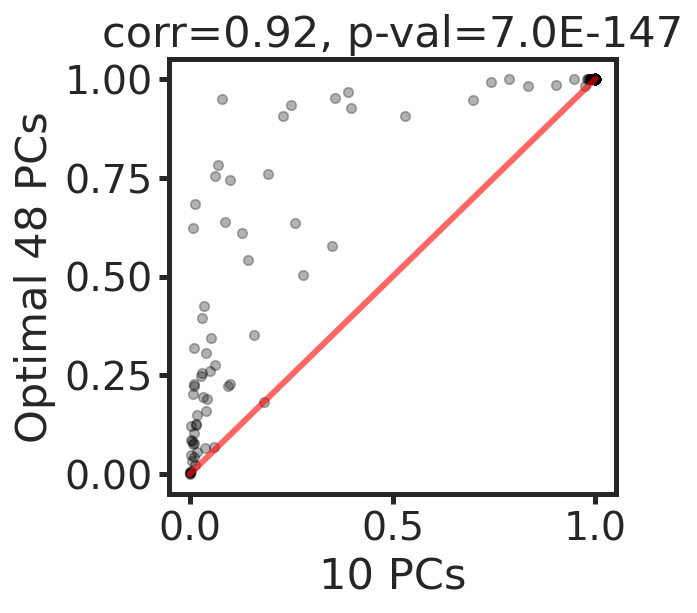

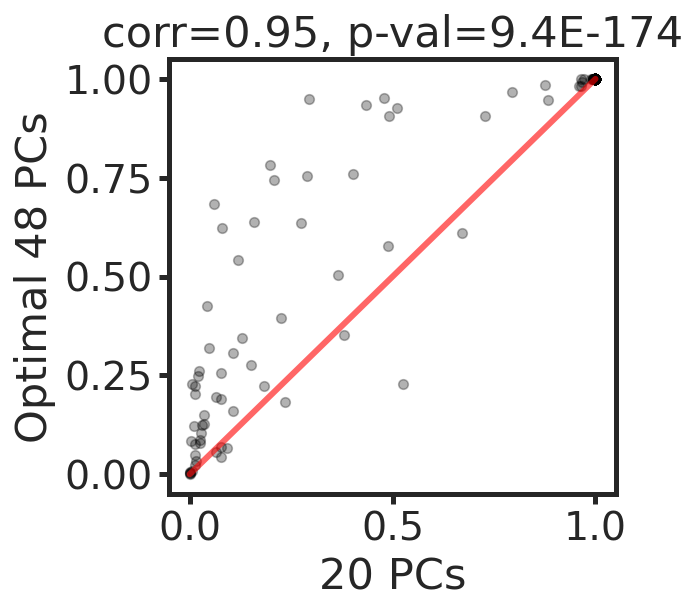

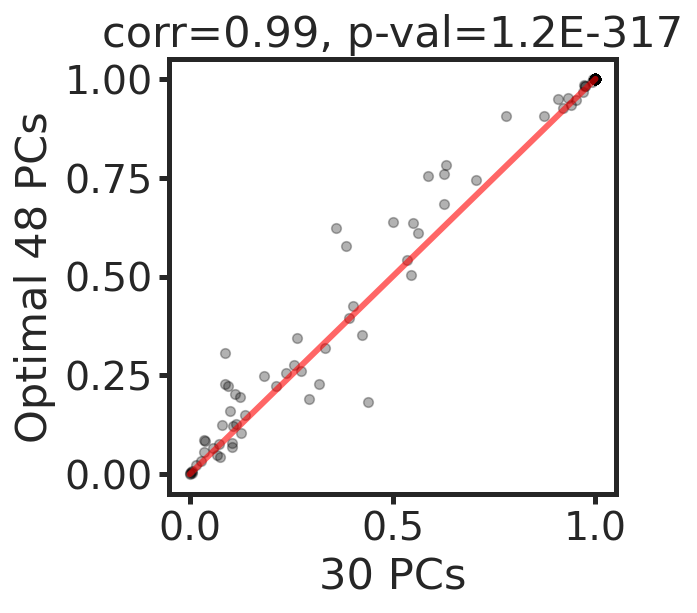

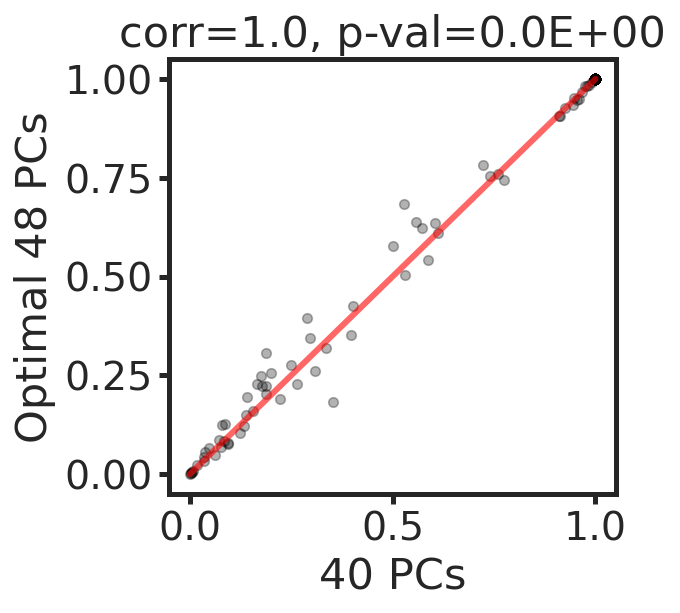

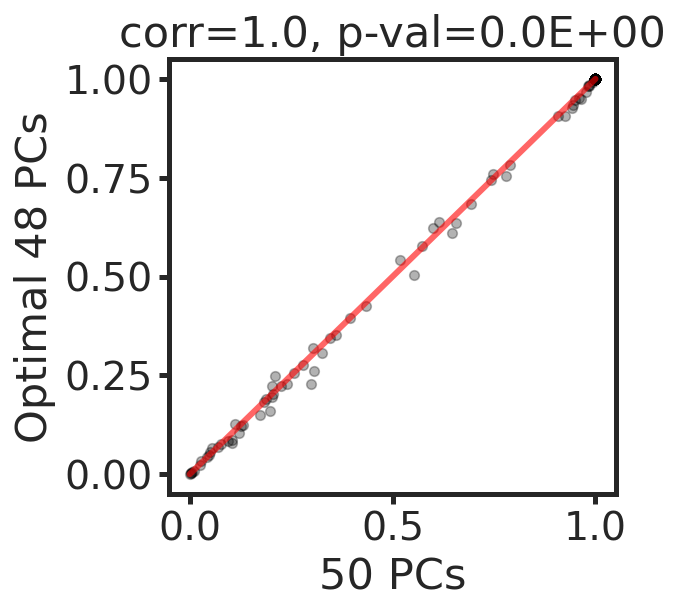

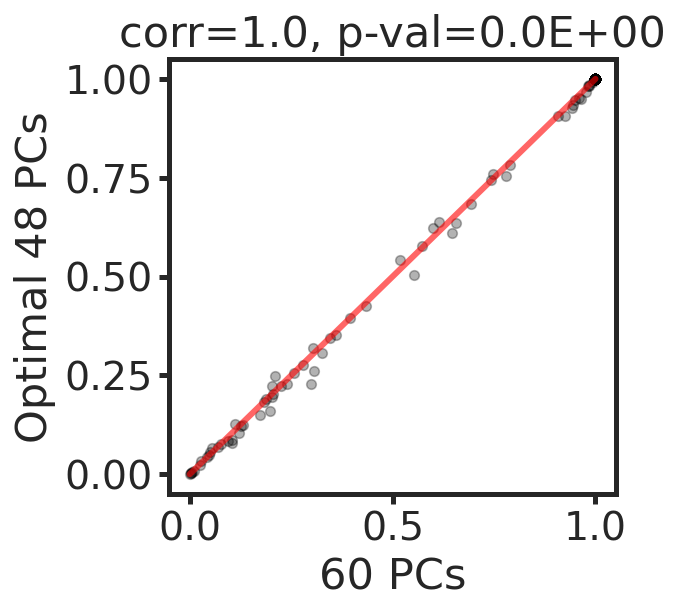

In [56]:
import scipy.stats

p_hat_opt_num_pcs = pd.read_csv(f'figures/new_labels_df_SMM-3.csv', index_col=0)['p_hat'].values

for num_pcs in [10, 20, 30, 40, 50, 60]:
    
    p_hat_num_pcs = pd.read_csv(f'figures/new_labels_df_SMM-3_{num_pcs}.csv', index_col=0)['p_hat'].values
    plt.figure(figsize=(4, 4))
    plt.scatter(p_hat_num_pcs, p_hat_opt_num_pcs, c='k', alpha=0.3)
    plt.xlabel(f'{num_pcs} PCs')
    plt.ylabel('Optimal 48 PCs')
    plt.title(f"corr={round(scipy.stats.pearsonr(p_hat_num_pcs, p_hat_opt_num_pcs)[0], 2)}, p-val={format(scipy.stats.pearsonr(p_hat_num_pcs, p_hat_opt_num_pcs)[1], '.1E')}")
    plt.plot([0, 1], [0, 1], c='red', alpha=0.6)
    plt.savefig(f'figures/scatterplot_{num_pcs}PCs_48PCs_SMM-3.png', 
            dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'figures/scatterplot_{num_pcs}PCs_48PCs_SMM-3.svg', 
            transparent=True, bbox_inches='tight')

In [71]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, name, ax=None, lw=5, color='blue'):
    ax = ax or plt.gca()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=lw, c=color, label=f"{name} (AUC = {roc_auc:.2f})")
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

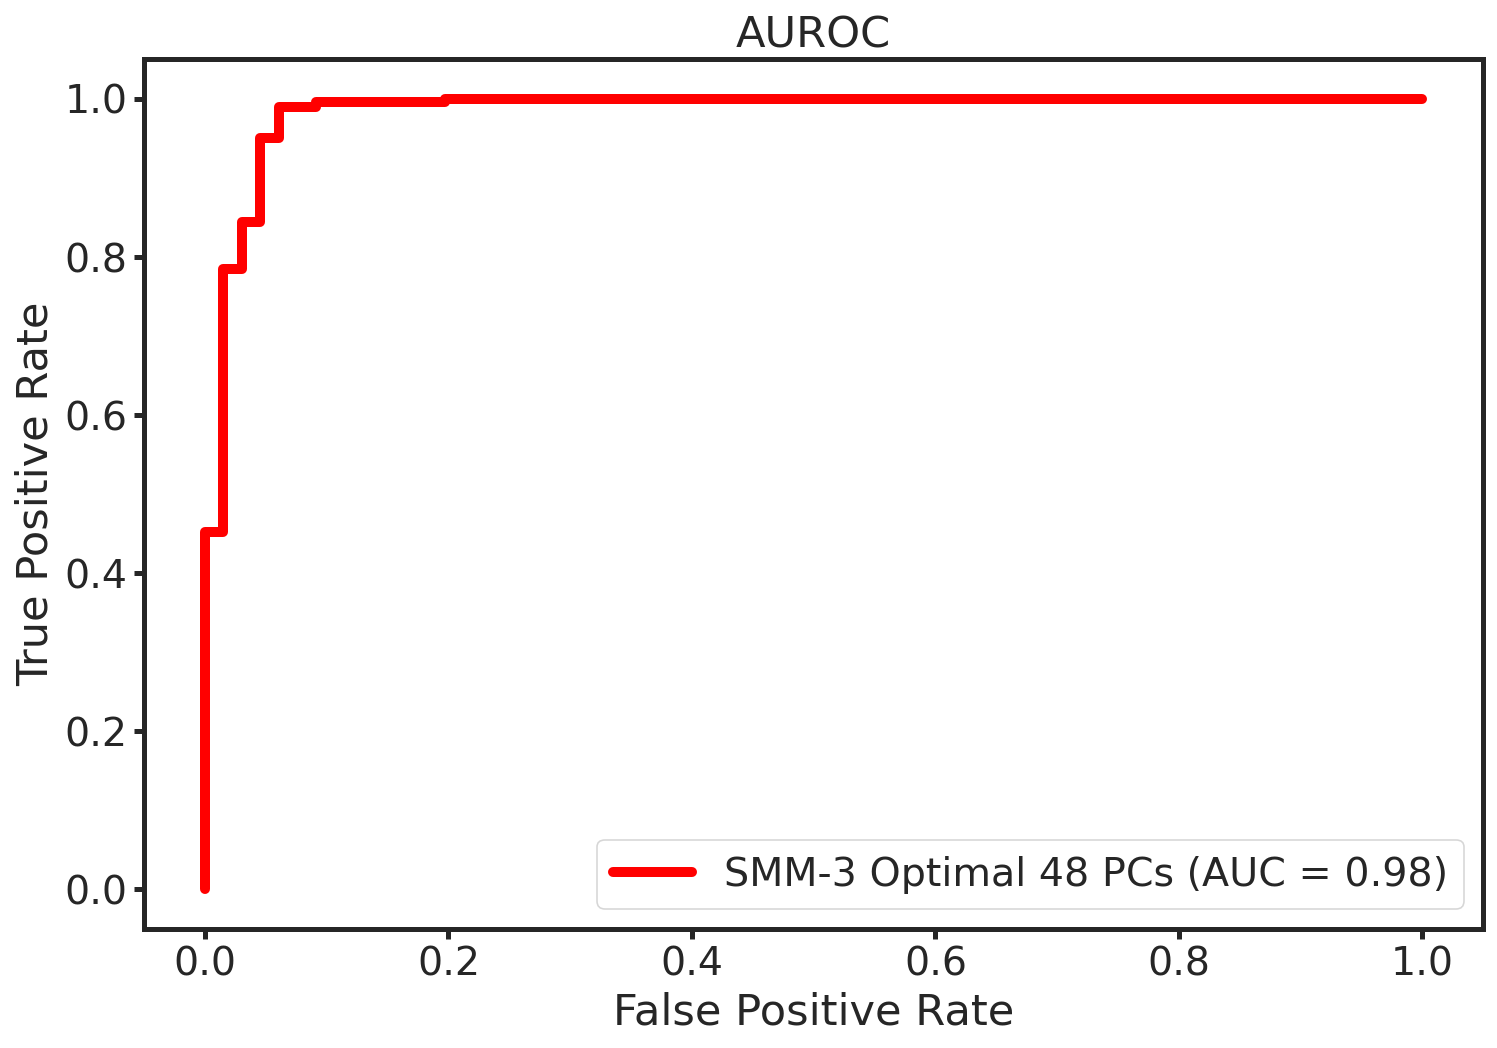

In [73]:
y_pred = pd.read_csv(f'figures/new_labels_df_SMM-3.csv', index_col=0)['p_hat'].values
y_true = adata_full.obs['ground_truth'][adata_full.obs['person'].isin(['SMM-3'])].values == 'malignant'

plot_roc_curve(y_true, y_pred, name=f'SMM-3 Optimal 48 PCs', color='red')

plt.title(f"AUROC") 
plt.savefig(f'figures/AUROC_SMM-3_Optimal_48_PCs.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_SMM-3_Optimal_48_PCs.svg', 
            transparent=True, bbox_inches='tight')

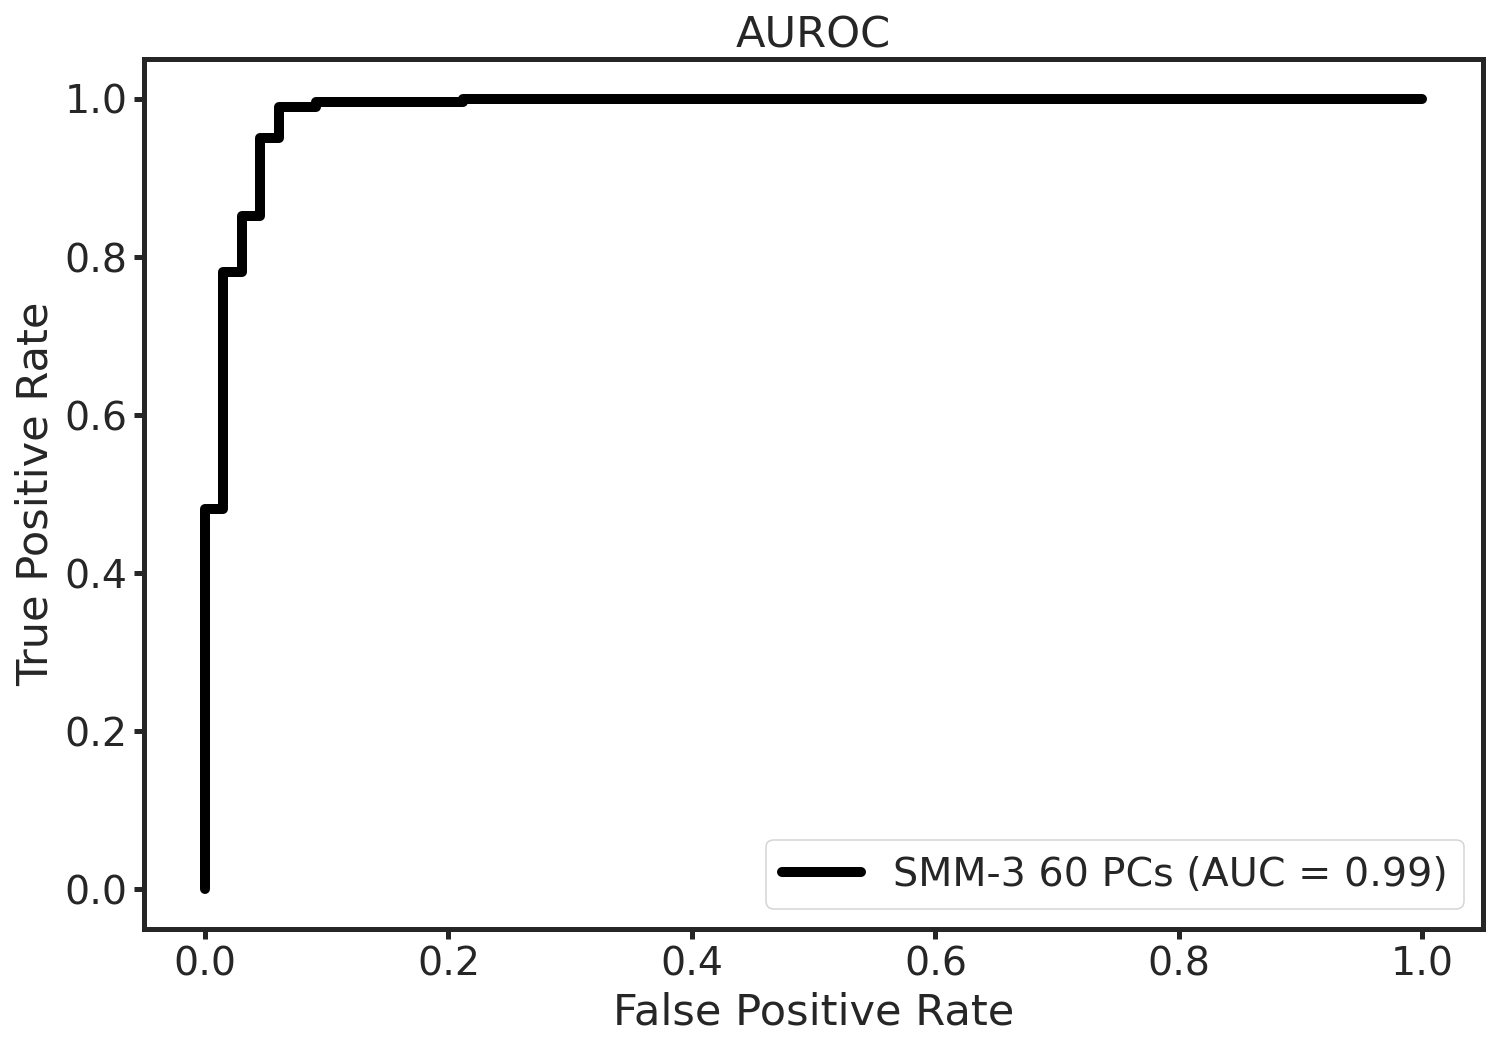

In [81]:
#for num_pcs in [10, 20, 30, 40, 50, 60]:
num_pcs = 60

y_pred = pd.read_csv(f'figures/new_labels_df_SMM-3_{num_pcs}.csv', index_col=0)['p_hat'].values
#y_true = adata_full.obs['ground_truth'][adata_full.obs['person'].isin(['SMM-3'])].values == 'malignant'

plot_roc_curve(y_true, y_pred, name=f'SMM-3 {num_pcs} PCs', color='black')

plt.title(f"AUROC") 
plt.savefig(f'figures/AUROC_SMM-3_{num_pcs}_PCs.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_SMM-3_{num_pcs}_PCs.svg', 
            transparent=True, bbox_inches='tight')

## Supplementary figure Running All NBM, All Mixed Precursors, All MM together

In [101]:
# All NBM, All Mixed Precursors, All MM

NBM_samples = ['NBM-1', 'NBM-2', 'NBM-3',  'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11']
Precursor_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']
MM_samples = ['MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8']

In [ ]:
# Choose Optimal NUM_PCS

num_pcs_vec = []
num_DEs_vec = []
num_pcs_de_dict = {'num_pcs':num_pcs_vec, 'num_DEs': num_DEs_vec}
num_pcs_de_dict

for num_pcs in tqdm(np.arange(1, 100, 1)):
    
    NUM_PCS = num_pcs
    print(f"{num_pcs} PCs")
    adata = subset_and_preprocess(adata_full, NBM_samples, Precursor_samples, MM_samples)
    #adata = adata_full
    subset_title_str = f'All NBM, All Precursor, All MM'
    # Define healthy and disease original labels ('NMB' being 'healthy', and everything else being 'disease')
    adata.obs['status'] = adata.obs.disease_stage.apply(lambda x: 0 if x=='NBM' else 1)
    adata.obs['status'] = adata.obs['status'].astype('int').values
    p_hat, new_labels = PCA_logistic_kmeans_precursorperson(adata, NUM_PCS)
    adata.obs['new_labels'] = new_labels.values

    # Find DE genes per patient and take a union across patients
    # Use this as the heuristic decision criterion for NUM_PCS: choose the NUM_PCS that maximizes the number of DE genes
    # Maximum log-fold change across patients using original labels

    lfc_new_p_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)
    lfc_new_l_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)
    
    # max abs(log-fold change) over samples for the selected genes
    lfc_ground_truth_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')
    lfc_new_labels_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')

    for precursor_sample in Precursor_samples:

        adata_de = adata[adata.obs['person'].isin([precursor_sample])]
        if (min(np.sum(adata_de.obs['new_labels']==1), np.sum(adata_de.obs['new_labels']==0)) < 10):
            print(f"{num_pcs} PCs, Sample {precursor_sample} has mostly homogenous labels and DE analysis will be skipped for it")
        else:
            adata_de.obs['new_labels'] = adata_de.obs['new_labels'].astype('category')
            sc.tl.rank_genes_groups(adata_de, 'new_labels', method='t-test')
            #sc.pl.rank_genes_groups(adata_de, n_genes=25, sharey=False)

            result = adata_de.uns['rank_genes_groups']
            groups = result['names'].dtype.names
            result_df = pd.DataFrame(
                {group + '_' + key[:1]: result[key][group]
                for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

            lfc_malignant_df = result_df[['1_n', '1_p', '1_l']]
            lfc_healthy_df = result_df[['0_n', '0_p', '0_l']]
            lfc_healthy_df = lfc_healthy_df.set_index('0_n')
            lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
            lfc_malignant_df = lfc_malignant_df.set_index('1_n')
            lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
            lfc_malignant_df.columns = [f'1_p_{precursor_sample}', f'1_l_{precursor_sample}']

            lfc_new_p_df = lfc_new_p_df.join(lfc_malignant_df[f'1_p_{precursor_sample}'])
            lfc_new_l_df = lfc_new_l_df.join(lfc_malignant_df[f'1_l_{precursor_sample}'])

            adata_plot = adata[adata.obs['person'].isin([precursor_sample])]
            #df_X = pd.DataFrame(adata_plot.layers['lognorm'].todense()) # log-normalized expression
            df_X = pd.DataFrame(adata_plot.layers['counts'].todense()) # raw expression
            df_X = df_X.div(df_X.sum(axis=1), axis=0) # TODO try both ways with normalizing and without
            df_X.columns = adata_plot.var.index
            eps = 0#1e-15

            lfc_ground_truth = np.log2((np.mean(df_X.values[adata_plot.obs['ground_truth']=='malignant'], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['ground_truth']!='malignant'], axis=0)+eps))
            lfc_new_labels = np.log2((np.mean(df_X.values[adata_plot.obs['new_labels']==1], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['new_labels']!=1], axis=0)+eps))
            lfc_ground_truth_df[f"{precursor_sample}"] = lfc_ground_truth
            lfc_new_labels_df[f"{precursor_sample}"] = lfc_new_labels

    max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    
    max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)
    # Number of DE genes with new labels
    lfc_new_p_df = lfc_new_p_df
    DE_new_bool = np.logical_and(max_abs_lfc_new_labels.abs()>1.5, lfc_new_p_df.min(axis=1)<0.05)
    DE_new = lfc_new_p_df.index.values[DE_new_bool]

    num_pcs_vec.append(NUM_PCS)
    num_DEs_vec.append(len(DE_new))
    
    del adata
    del adata_de
    del adata_plot
    gc.collect()


  0%|          | 0/29 [00:00<?, ?it/s]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Num DE_new 1238
sig pval 3257
sig lfc 10632


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Num DE_new 2604
sig pval 6387
sig lfc 11728


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Num DE_new 1620
sig pval 2742
sig lfc 12677


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Num DE_new 1979
sig pval 3061
sig lfc 13453


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1930
sig pval 2882
sig lfc 13471


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1155
sig pval 2483
sig lfc 10396


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1205
sig pval 2607
sig lfc 10504


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1962
sig pval 2928
sig lfc 13458


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1992
sig pval 2980
sig lfc 13537


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1303
sig pval 2818
sig lfc 10660


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1274
sig pval 2782
sig lfc 10491


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1275
sig pval 2763
sig lfc 10497


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1299
sig pval 2798
sig lfc 10614


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2772
sig pval 4033
sig lfc 13986


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2446
sig pval 3561
sig lfc 13898


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2460
sig pval 3577
sig lfc 13870


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2520
sig pval 3487
sig lfc 14336


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2520
sig pval 3487
sig lfc 14336


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 2530
sig pval 3495
sig lfc 14303


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1714
sig pval 3257
sig lfc 11539


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1735
sig pval 3259
sig lfc 11580


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1612
sig pval 3030
sig lfc 11463


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1588
sig pval 3024
sig lfc 11474


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample MGUS-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1854
sig pval 2964
sig lfc 12234


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample MGUS-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1830
sig pval 2975
sig lfc 12150


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample MGUS-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1827
sig pval 2975
sig lfc 12133


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample MGUS-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1837
sig pval 2975
sig lfc 12191


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-4 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1910
sig pval 3188
sig lfc 12327


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-1 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-4 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-5 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-6 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-7 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-11 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-12 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Sample SMM-2 has mostly homogenous labels and DE analysis will be skipped for it


Trying to set attribute `.obs` of view, copying.


Sample SMM-8 has mostly homogenous labels and DE analysis will be skipped for it
Sample SMM-9 has mostly homogenous labels and DE analysis will be skipped for it
Num DE_new 1833
sig pval 3002
sig lfc 12403


In [ ]:
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='k', alpha=0.5)
plt.scatter(num_pcs_de_dict['num_pcs'], num_pcs_de_dict['num_DEs'], s=30, c='none', alpha=0.5, edgecolors='k')
#plt.axvline(x = 34, color = 'r', alpha=0.2)
#plt.scatter(34, 1938, s=200, c='r', marker='*', edgecolors='k')
plt.xticks(np.append(np.arange(0, 101, 10), 34), fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('Number of DE genes using refined labels')
#plt.title('Choosing the optimal NUM_PCS')
plt.savefig('figures/ChoosingoptimalNUM_PCS_AllNBM_MixedonlyPrecursor_AllMM.png', 
            dpi=300, transparent=False, bbox_inches='tight')
plt.savefig('figures/ChoosingoptimalNUM_PCS_AllNBM_MixedonlyPrecursor_AllMM.svg', 
            transparent=False, bbox_inches='tight')
plt.show()

## Run for a chosen value of NUM_PCS

In [103]:
NUM_PCS = 34 # num_pcs_de_dict['num_pcs'][np.argmax(num_pcs_de_dict['num_DEs'])]

adata = subset_and_preprocess(adata_full, NBM_samples, Precursor_samples, MM_samples)
#adata = adata_full
subset_title_str = f'All NBM, {Precursor_samples}, All MM'
# Define healthy and disease original labels ('NMB' being 'healthy', and everything else being 'disease')
adata.obs['status'] = adata.obs.disease_stage.apply(lambda x: 0 if x=='NBM' else 1)
adata.obs['status'] = adata.obs['status'].astype('int').values
p_hat, new_labels = PCA_logistic_kmeans_precursorperson(adata, NUM_PCS)
adata.obs['new_labels'] = new_labels.values

Trying to set attribute `.obs` of view, copying.


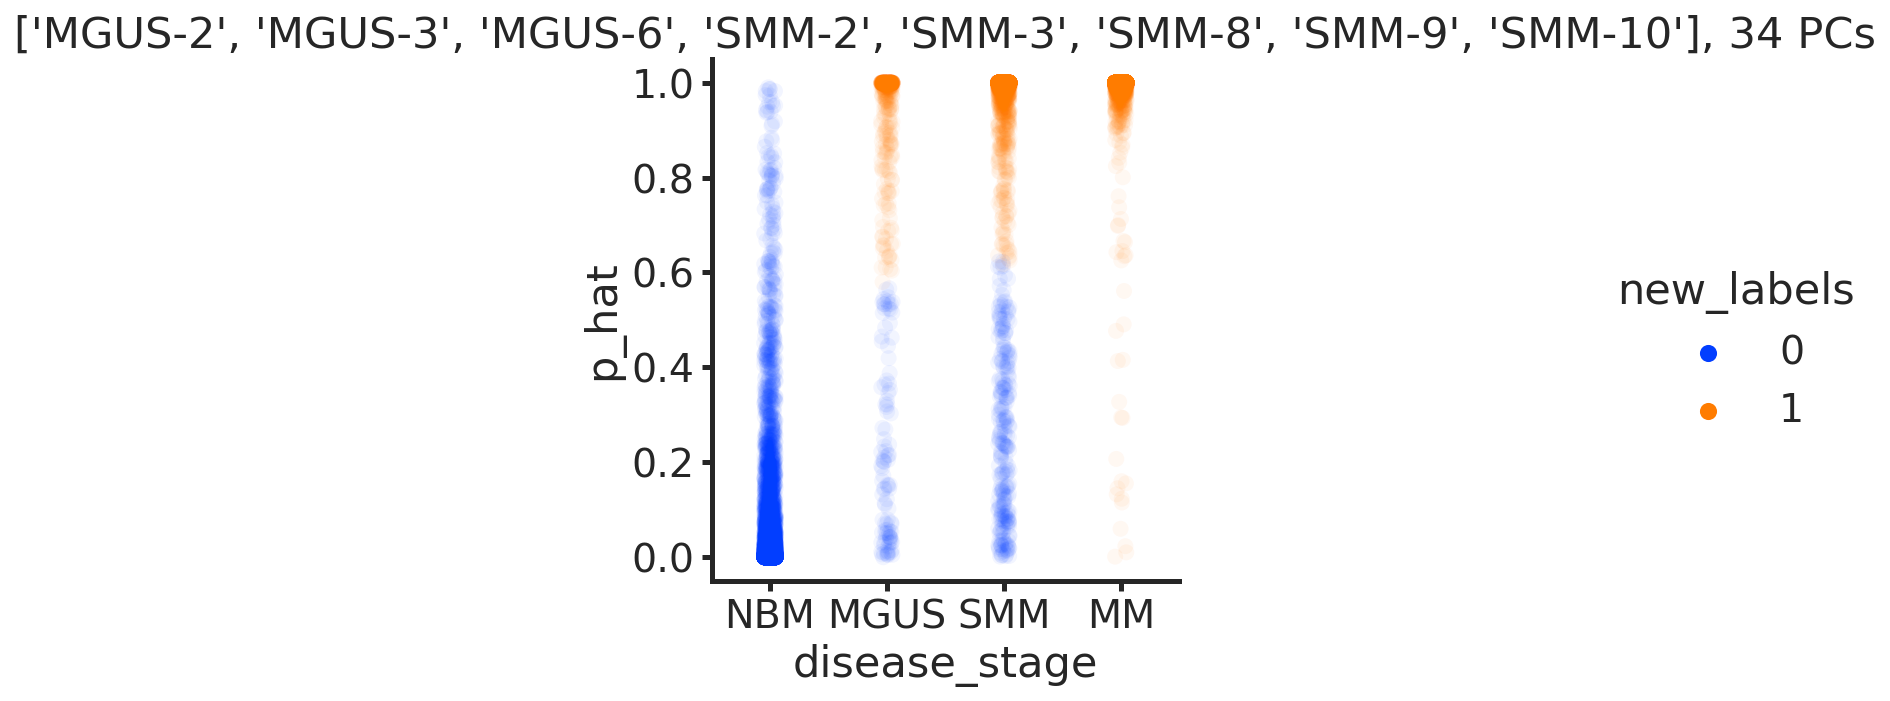

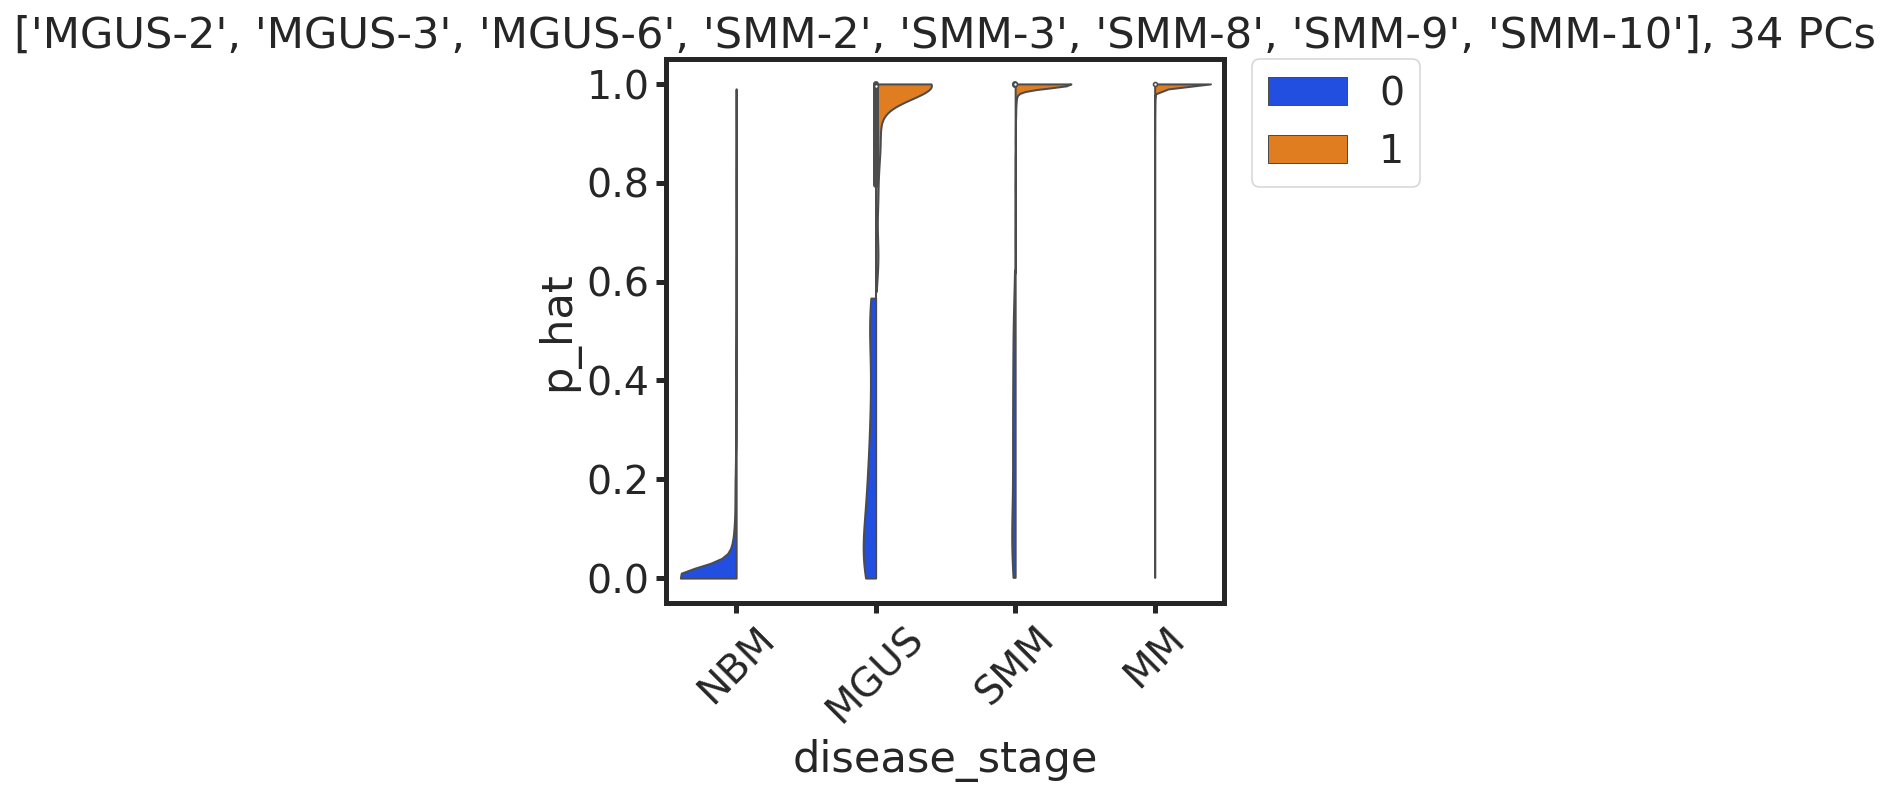

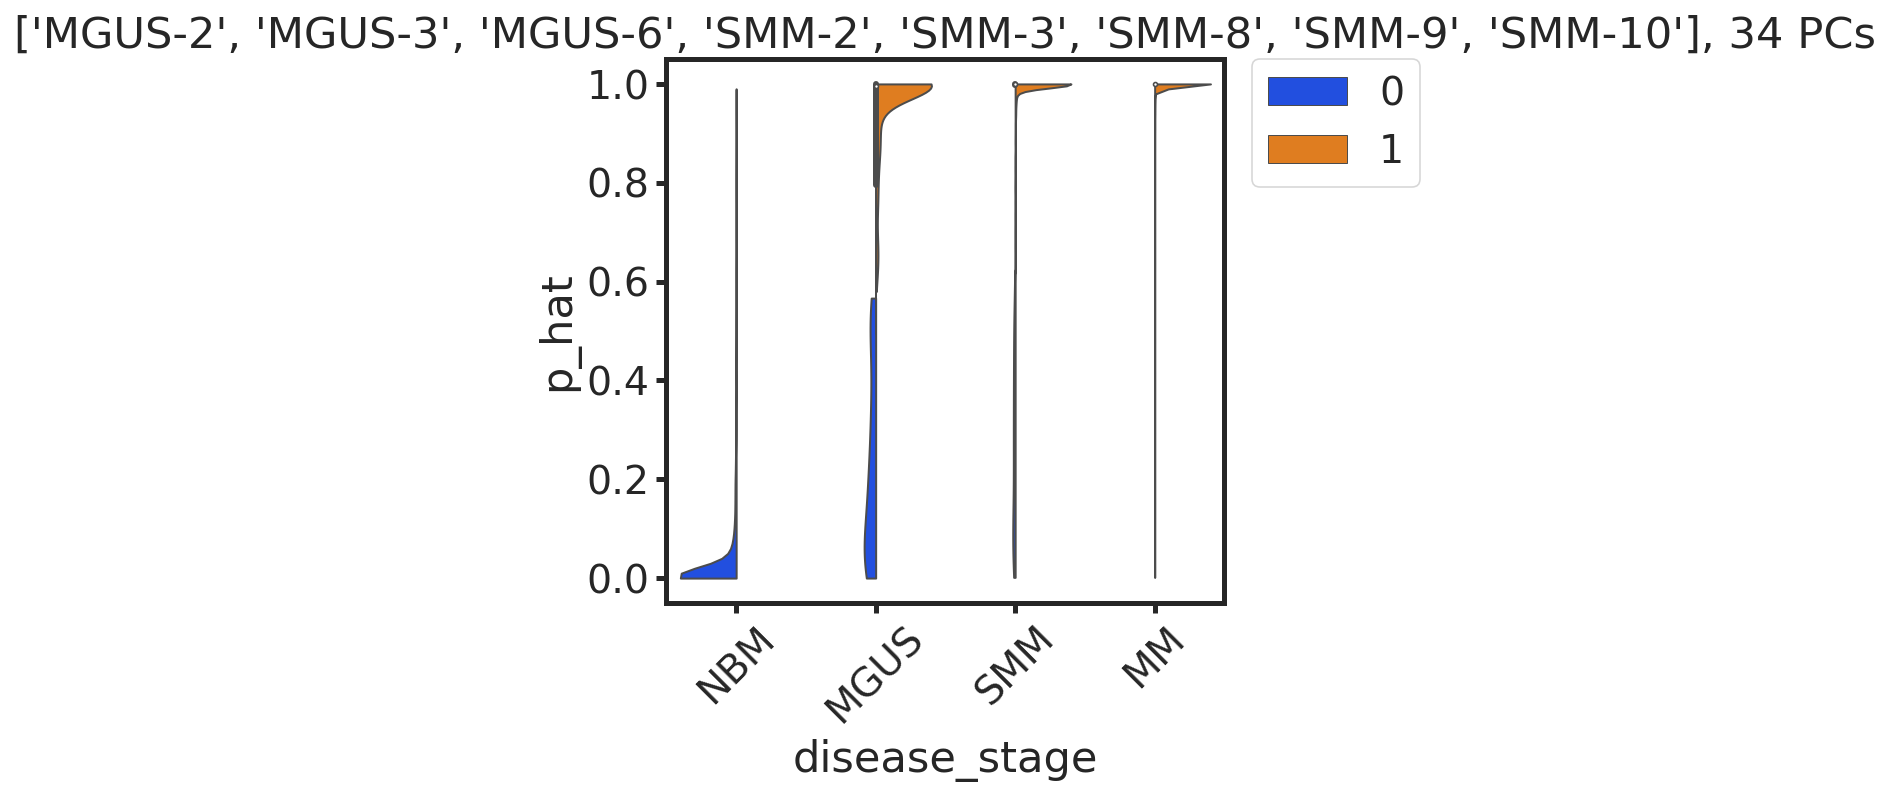

In [104]:
g = sns.catplot(x='disease_stage', y='p_hat', kind='strip', hue='new_labels', data=adata.obs, jitter=0.05, s=8, alpha=0.05)
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_oneplot_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5))
g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='count')#, scale_hue=False) 
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 5))
g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='area')#, scale_hue=False) 
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_disease_stage_violinplot_scalearea_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

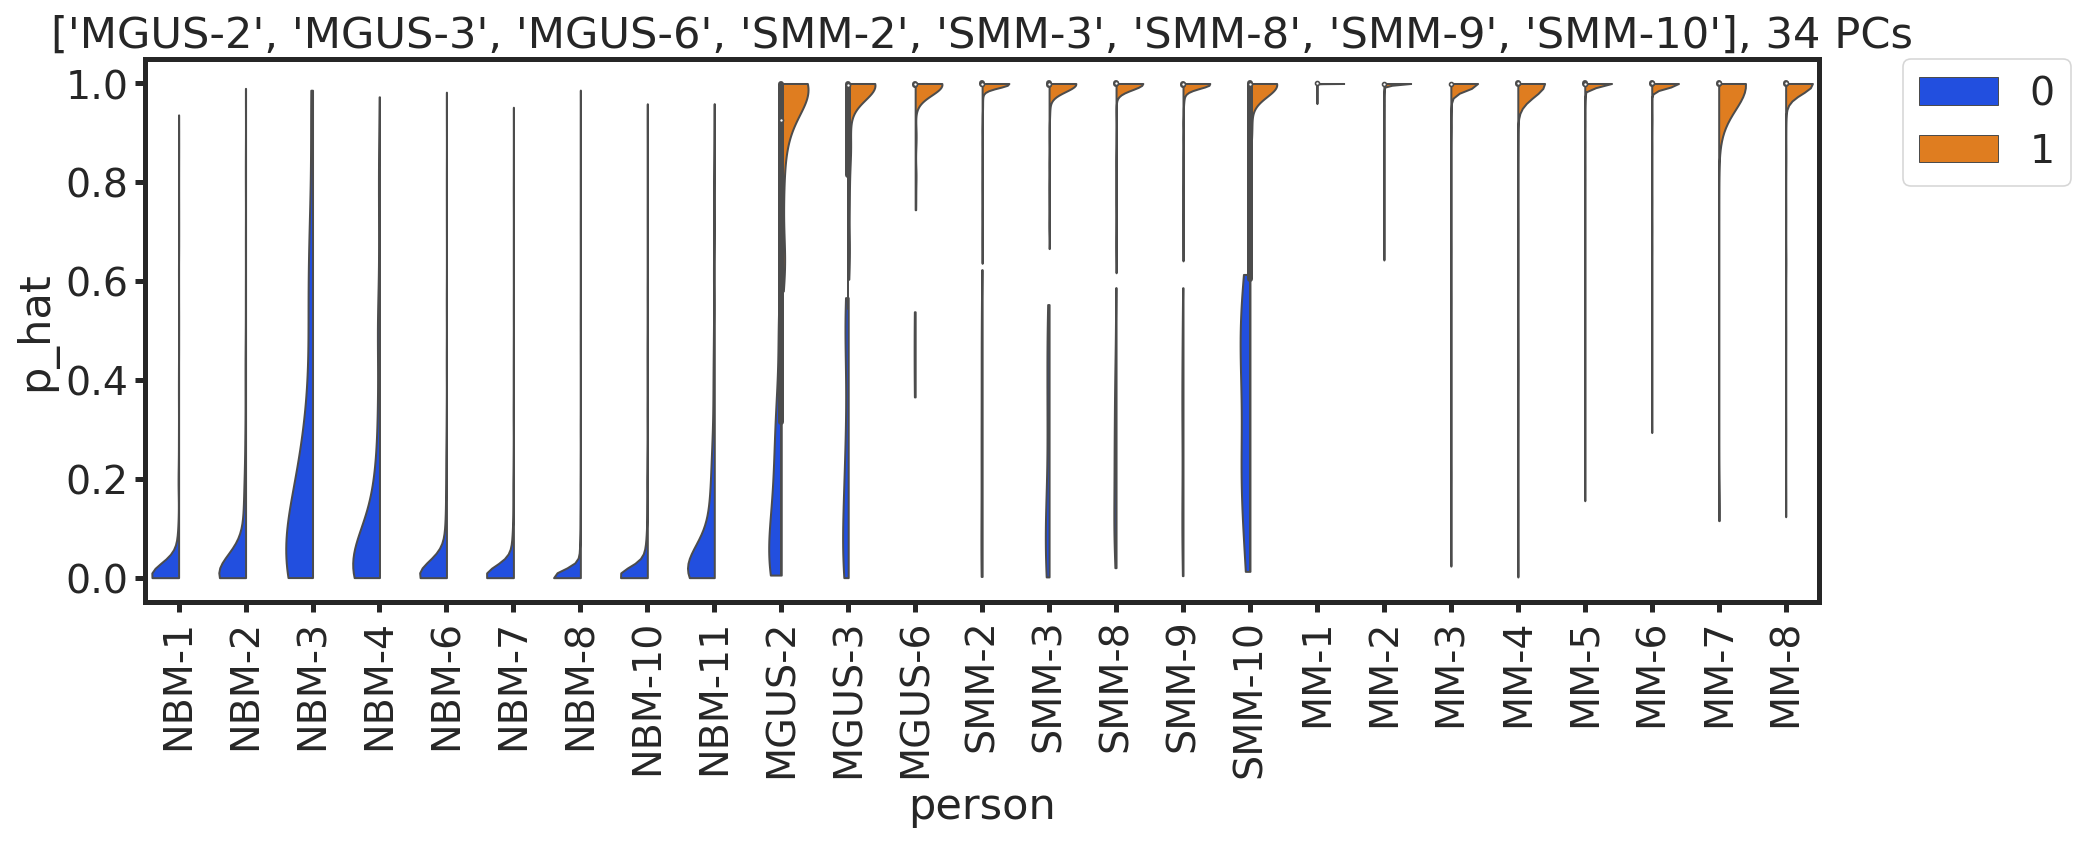

In [105]:
#g = sns.violinplot(data=adata.obs, x='disease_stage', y='p_hat', hue="new_labels", linewidth=1, split=True, cut=0, scale='area')#, scale_hue=False) 

plt.figure(figsize=(15, 5))
g = sns.violinplot(data=adata.obs, x='person', y='p_hat', hue='new_labels', linewidth=1, split=True, cut=0, jitter=0.05, scale='count')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f'{Precursor_samples}, {NUM_PCS} PCs')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.svg', transparent=True, bbox_inches='tight')
plt.savefig(f'figures/p_hat_predictions_person_violinplot_scalecount_{NUM_PCS}PCs_{Precursor_samples}.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [106]:
adata_de = adata[adata.obs['person'].isin(Precursor_samples)]

lfc_ground_p_df = pd.DataFrame({'malignant_n':[]}).set_index('malignant_n').reindex(index=adata.var.index.values)
lfc_new_p_df = pd.DataFrame({'1_n':[]}).set_index('1_n').reindex(index=adata.var.index.values)

# max abs(log-fold change) over samples for the selected genes
lfc_ground_truth_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')
lfc_new_labels_df = pd.DataFrame({'gene':adata.var.index.values}).set_index('gene')

if (len(np.unique(adata_de.obs['ground_truth']))==2):
    adata_de.obs['ground_truth'] = adata_de.obs['ground_truth'].astype('category')
    sc.tl.rank_genes_groups(adata_de, 'ground_truth', method='t-test')
    result = adata_de.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result_df = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    lfc_malignant_df = result_df[['malignant_n', 'malignant_p', 'malignant_l']]
    lfc_healthy_df = result_df[['healthy plasma_n', 'healthy plasma_p', 'healthy plasma_l']]
    lfc_healthy_df = lfc_healthy_df.set_index('healthy plasma_n')
    lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
    lfc_malignant_df = lfc_malignant_df.set_index('malignant_n')
    lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
    lfc_malignant_df.columns = [f'malignant_p_{Precursor_samples[0]}', f'malignant_l_{Precursor_samples[0]}']
    lfc_ground_p_df = lfc_ground_p_df.join(lfc_malignant_df[f'malignant_p_{Precursor_samples[0]}'])
else:
    print(f'{Precursor_samples} has only one ground_truth class (i.e. is not mixed according to the subclustering annotation.)')


adata_de.obs['new_labels'] = adata_de.obs['new_labels'].astype('category')
sc.tl.rank_genes_groups(adata_de, 'new_labels', method='t-test')
result = adata_de.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

lfc_malignant_df = result_df[['1_n', '1_p', '1_l']]
lfc_healthy_df = result_df[['0_n', '0_p', '0_l']]
lfc_healthy_df = lfc_healthy_df.set_index('0_n')
lfc_healthy_df = lfc_healthy_df.reindex(index=adata.var.index.values)
lfc_malignant_df = lfc_malignant_df.set_index('1_n')
lfc_malignant_df = lfc_malignant_df.reindex(index=adata.var.index.values)
lfc_malignant_df.columns = [f'1_p_{Precursor_samples}', f'1_l_{Precursor_samples}']
lfc_new_p_df = lfc_new_p_df.join(lfc_malignant_df[f'1_p_{Precursor_samples}'])

adata_plot = adata[adata.obs['person'].isin(Precursor_samples)]
#df_X = pd.DataFrame(adata_plot.layers['lognorm'].todense()) # log-normalized expression
df_X = pd.DataFrame(adata_plot.layers['counts'].todense()) # raw expression
df_X = df_X.div(df_X.sum(axis=1), axis=0) # TODO try both ways with normalizing and without
df_X.columns = adata_plot.var.index
eps = 0#1e-15

lfc_ground_truth = np.log2((np.mean(df_X.values[adata_plot.obs['ground_truth']=='malignant'], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['ground_truth']!='malignant'], axis=0)+eps))
lfc_ground_truth_df[f"{Precursor_samples}"] = lfc_ground_truth
max_abs_lfc_ground_truth = lfc_ground_truth_df.apply(lambda row : max_abs_lfc(row), axis = 1)

lfc_new_labels = np.log2((np.mean(df_X.values[adata_plot.obs['new_labels']==1], axis=0)+eps) / (np.mean(df_X.values[adata_plot.obs['new_labels']!=1], axis=0)+eps))
lfc_new_labels_df[f"{Precursor_samples}"] = lfc_new_labels
max_abs_lfc_new_labels = lfc_new_labels_df.apply(lambda row : max_abs_lfc(row), axis = 1)

# Number of DE genes with ground_truth labels
DE_ground_bool = np.logical_and(max_abs_lfc_ground_truth.abs()>1.5, lfc_ground_p_df.min(axis=1)<0.05)
DE_ground = lfc_ground_p_df.index.values[DE_ground_bool]

# Number of DE genes with new labels
DE_new_bool = np.logical_and(max_abs_lfc_new_labels.abs()>1.5, lfc_new_p_df.min(axis=1)<0.05)
DE_new = lfc_new_p_df.index.values[DE_new_bool]

print(f"{Precursor_samples}, {NUM_PCS}")
print(f"num DE_new {len(DE_new)}")
print(f"num DE_ground {len(DE_ground)}")
print(f"intersection {len(np.intersect1d(DE_ground, DE_new))}")
print(f"new_labels unique {len(np.setdiff1d(DE_new, DE_ground))}")
print(f"ground_truth unique {len(np.setdiff1d(DE_ground, DE_new))}")

Trying to set attribute `.obs` of view, copying.


['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10'], 34
num DE_new 2621
num DE_ground 1377
intersection 1087
new_labels unique 1534
ground_truth unique 290


In [108]:
p_ground_df_Sample = lfc_ground_p_df
max_abs_lfc_ground_df_Sample = pd.DataFrame(max_abs_lfc_ground_truth, columns=[f'max_abs_lfc_AllMixedPrecursors'])
DE_ground_Sample = DE_ground
p_new_df_Sample = lfc_new_p_df
max_abs_lfc_new_df_Sample = pd.DataFrame(max_abs_lfc_new_labels, columns=[f'max_abs_lfc_AllMixedPrecursors'])
DE_new_Sample = DE_new
new_labels_df_Sample = pd.DataFrame(np.transpose([adata_de.obs.index, adata_de.obs['new_labels'], adata_de.obs['p_hat']]), 
                                    columns=["cellnames", "new_labels", "p_hat"])

In [109]:
# save
p_ground_df_Sample.to_csv(f'figures/p_ground_df_AllMixedPrecursors.csv')
max_abs_lfc_ground_df_Sample.to_csv(f'figures/max_abs_lfc_ground_df_AllMixedPrecursors.csv')
p_new_df_Sample.to_csv(f'figures/p_new_df_AllMixedPrecursors.csv')
max_abs_lfc_new_df_Sample.to_csv(f'figures/max_abs_lfc_new_df_AllMixedPrecursors.csv')
new_labels_df_Sample.to_csv(f'figures/new_labels_df_AllMixedPrecursors.csv')

pd.DataFrame(DE_new_Sample, columns=[f'DE_new_AllMixedPrecursors']).to_csv(f'figures/DE_new_AllMixedPrecursors.csv')
pd.DataFrame(DE_ground_Sample, columns=[f'DE_ground_AllMixedPrecursors']).to_csv(f'figures/DE_ground_AllMixedPrecursors.csv')

In [110]:
# AUROC

Mixed_samples = ['MGUS-2', 'MGUS-3', 'MGUS-6', 'SMM-2', 'SMM-3', 'SMM-8', 'SMM-9', 'SMM-10']

adata = adata_full[adata_full.obs['person'].isin(Mixed_samples)]
adata.obs['p_hat'] = 0

for i, mixed_sample in enumerate(Mixed_samples):
    
    new_labels_df_Sample = pd.read_csv(f'figures/new_labels_df_{Mixed_samples[i]}.csv', index_col=0)
    Sample_mask = adata.obs.index.isin(new_labels_df_Sample['cellnames'])
    adata.obs['p_hat'][Sample_mask] = new_labels_df_Sample['p_hat']
    adata.obs['p_hat'][Sample_mask] = new_labels_df_Sample['p_hat'].values

Trying to set attribute `.obs` of view, copying.


In [111]:
adata.obs['p_hat'] = adata.obs['p_hat'].astype('float')
# save also the new labels
adata.write_h5ad('figures/adataMixedPrecursorsPhatAllMixedFitTogether.h5ad')

MGUS
SMM


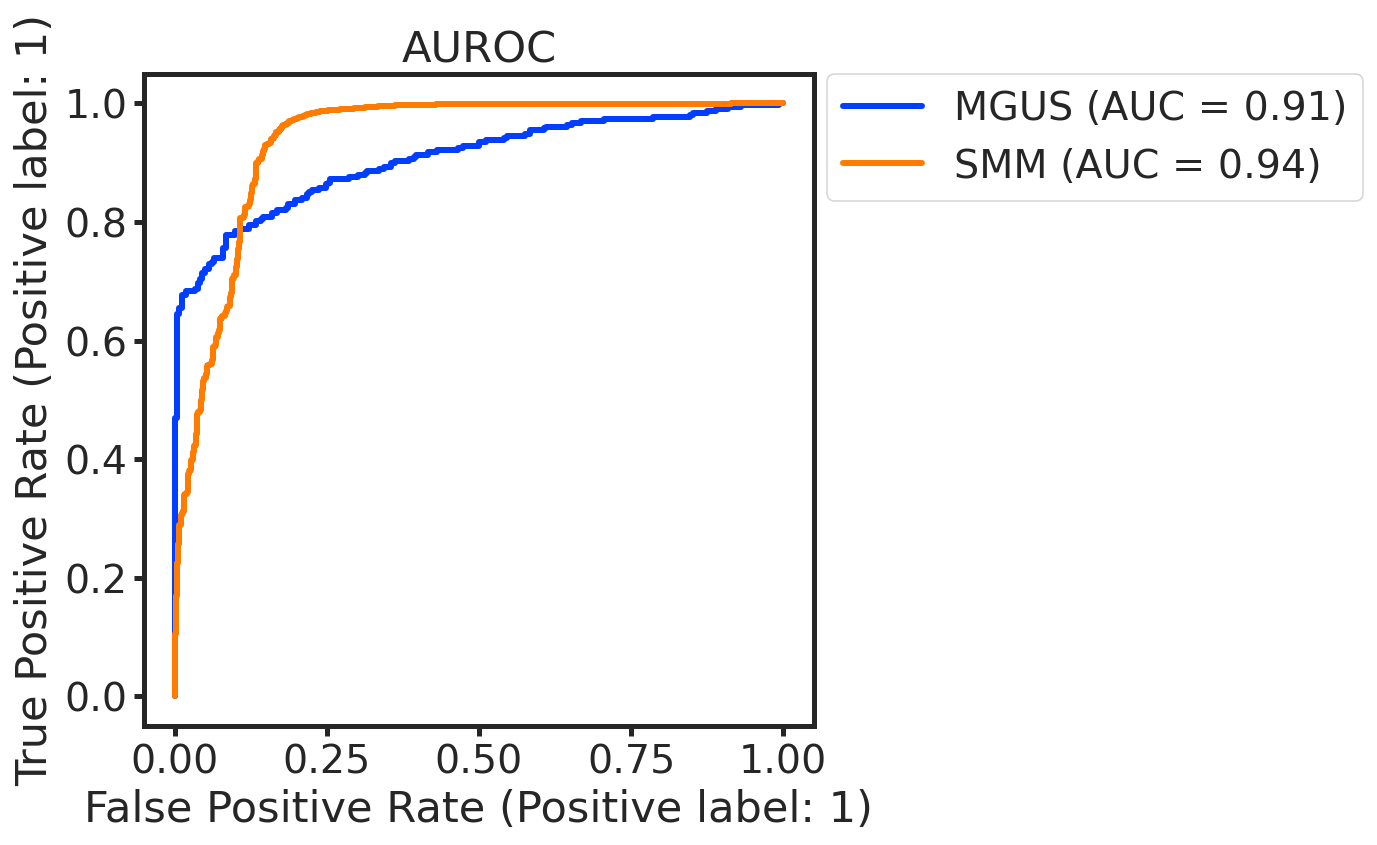

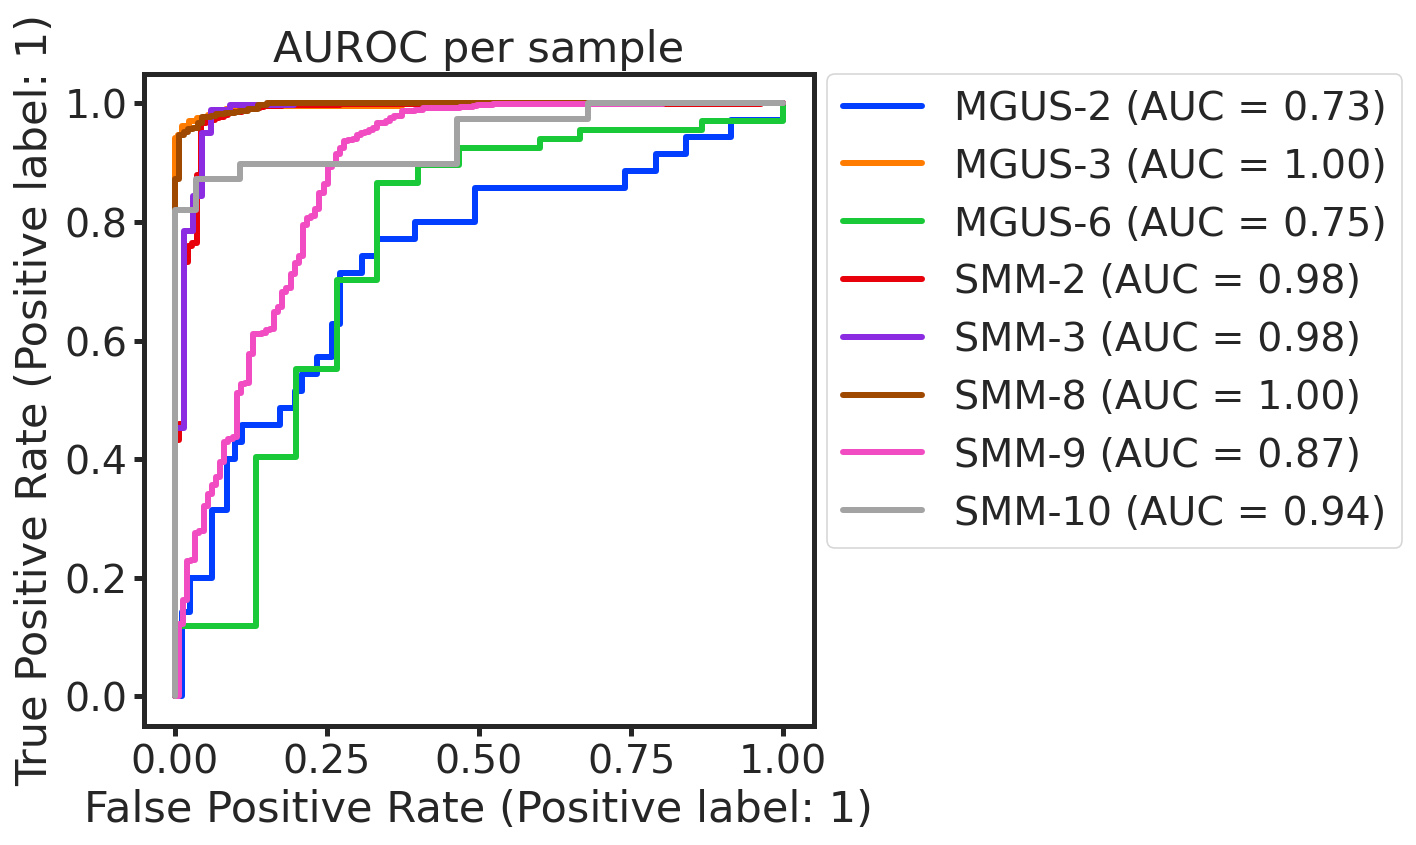

In [112]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
groupedby_diseasestage = adata.obs[adata.obs['person'].isin(Mixed_samples)].groupby(['disease_stage'])
for stage, grp_df in groupedby_diseasestage:
    print(stage)
    y_pred = grp_df['p_hat'].values
    y_true = grp_df['ground_truth'] == "malignant"
    try:
        sklearn.metrics.RocCurveDisplay.from_predictions(y_true, y_pred, name=f'{stage}', ax=ax)
    except ValueError:
        print(f'Error {stage}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"AUROC") 
plt.savefig(f'figures/AUROC_Combined_{Mixed_samples}.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_Combined_{Mixed_samples}.svg', 
            transparent=True, bbox_inches='tight')

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
groupedby_person = adata.obs[adata.obs['person'].isin(Mixed_samples)].groupby(['person'])
for person, grp_df in groupedby_person:
    y_pred = grp_df['p_hat'].values
    y_true = grp_df['ground_truth'] == "malignant"
    try:
        info = {'person':person, 'auroc':sklearn.metrics.roc_auc_score(y_true, y_pred)}
        sklearn.metrics.RocCurveDisplay.from_predictions(y_true, y_pred, name=f'{person}', ax=ax)
    except ValueError:
        print(f'{person}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"AUROC per sample") 
plt.savefig(f'figures/AUROC_persample_Combined_{Mixed_samples}.png', 
            dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'figures/AUROC_persample_Combined_{Mixed_samples}.svg', 
            transparent=True, bbox_inches='tight')


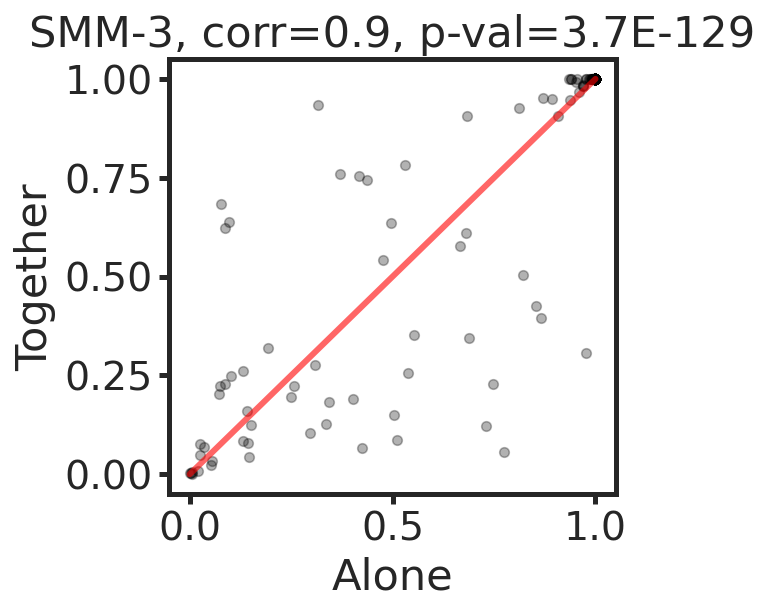

In [131]:
import scipy.stats

p_hat_alone = pd.read_csv(f'figures/new_labels_df_SMM-3.csv', index_col=0)['p_hat'].values

together_df = pd.read_csv(f'figures/new_labels_df_AllMixedPrecursors.csv', index_col=0)
p_hat_together = together_df[together_df['cellnames'].apply(lambda x: 'SMMl-3' in x)]['p_hat'].values
plt.figure(figsize=(4, 4))
plt.scatter(p_hat_together, p_hat_alone, c='k', alpha=0.3)
plt.xlabel(f'Alone')
plt.ylabel('Together')
plt.title(f"SMM-3, corr={round(scipy.stats.pearsonr(p_hat_together, p_hat_alone)[0], 2)}, p-val={format(scipy.stats.pearsonr(p_hat_together, p_hat_alone)[1], '.1E')}")
plt.plot([0, 1], [0, 1], c='red', alpha=0.6)
plt.savefig(f'figures/scatterplot_34PCsAllMixed_48PCsAlone_SMM-3.png', 
        dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'figures/scatterplot_34PCsAllMixed_48PCsAlone_SMM-3.svg', 
        transparent=True, bbox_inches='tight')

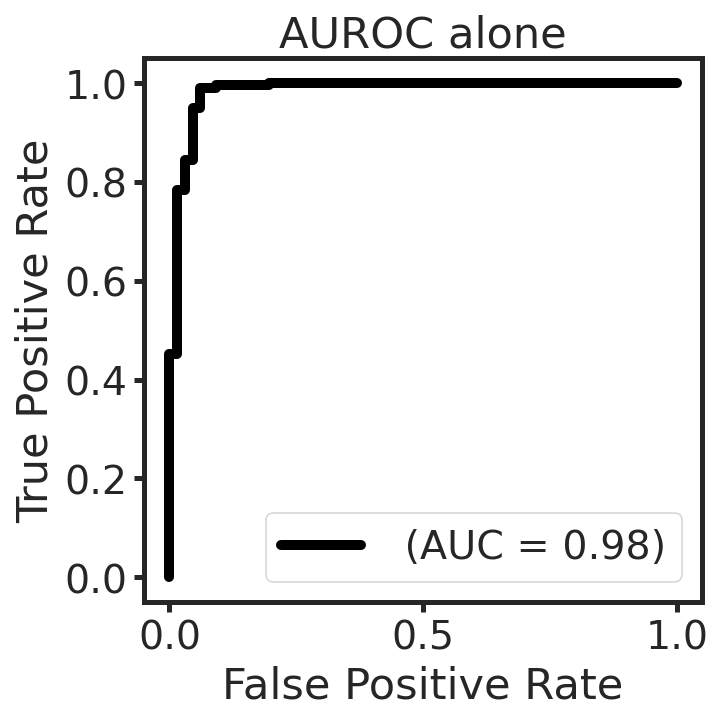

In [136]:
y_pred = pd.read_csv(f'figures/new_labels_df_SMM-3.csv', index_col=0)['p_hat'].values
y_true = adata_full.obs['ground_truth'][adata_full.obs['person'].isin(['SMM-3'])].values == 'malignant'

plt.figure(figsize=(5, 5))
plot_roc_curve(y_true, y_pred, name=f'', color='black')

plt.title(f"AUROC alone") 
plt.savefig(f'figures/AUROC_SMM-3_Alone_48_PCs.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_SMM-3_Alone_48_PCs.svg', 
            transparent=True, bbox_inches='tight')

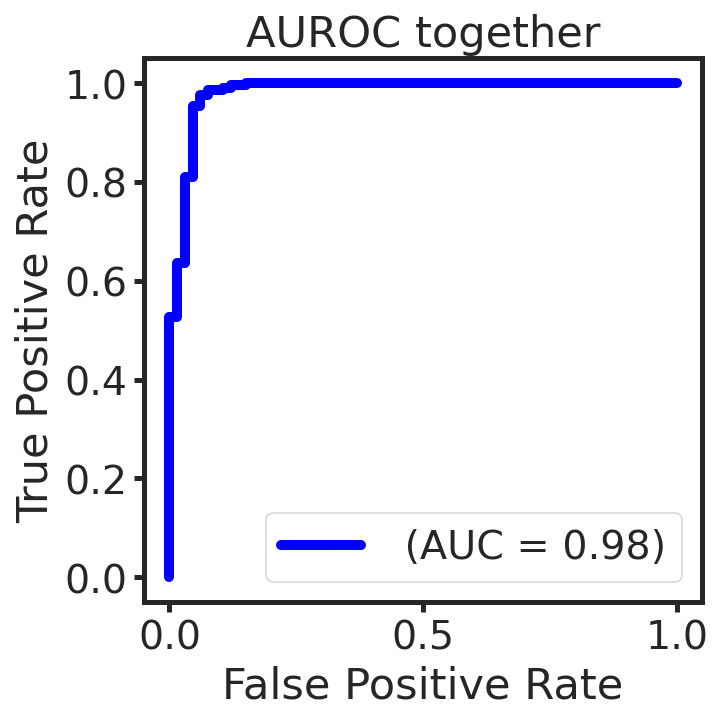

In [135]:
together_df = pd.read_csv(f'figures/new_labels_df_AllMixedPrecursors.csv', index_col=0)
p_hat_together = together_df[together_df['cellnames'].apply(lambda x: 'SMMl-3' in x)]['p_hat'].values

y_pred = p_hat_together
y_true = adata_full.obs['ground_truth'][adata_full.obs['person'].isin(['SMM-3'])].values == 'malignant'

plt.figure(figsize=(5, 5))
plot_roc_curve(y_true, y_pred, name=f'', color='blue')

plt.title(f"AUROC together") 
plt.savefig(f'figures/AUROC_SMM-3_Together_34_PCs.png', 
            dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(f'figures/AUROC_SMM-3_Together_34_PCs.svg', 
            transparent=True, bbox_inches='tight')